In [26]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit
from sklearn.preprocessing import quantile_transform, StandardScaler
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [2]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}
pass_HLT = {}
pass_L1 = {}
weights = {}

## Collect Data

In [4]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)

# Append to datasets
datasets['HLT_data'] = HLT_objects[pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_data'] = EB_weights[pass_L1_idxs]
pass_L1['HLT_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['HLT_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_data'] = L1_objects[pass_L1_idxs]
weights['L1_data'] = EB_weights[pass_L1_idxs]
pass_L1['L1_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['L1_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['HLT_zerobias'] = HLT_objects[~pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['HLT_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['HLT_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['L1_zerobias'] = L1_objects[~pass_L1_idxs]
weights['L1_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['L1_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['L1_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['HLT_passedHLT'] = HLT_objects[pass_HLT_idxs][:, :, [0, 2, 3]]
weights['HLT_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['HLT_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['HLT_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_passedHLT'] = L1_objects[pass_HLT_idxs]
weights['L1_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['L1_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['L1_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

In [5]:
# Read MC data. Remove E.

filenames = ['Ztautau',
             #'HHbbttHadHad.h5', 
             'ZZ4lep',  
             #'jjJZ4.h5', 
             #'jjJZ2.h5', 
             'qqa', 
             'HNL7p5_ctau1_eemu',
             'Zprime2EJs',
             'HAHMggfZdZd2l2nu']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename+'.h5', 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]
        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets['HLT_'+filename] = combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

In [6]:
# Read other MC data.

filenames = ['HHbbttHadHad',   
             'jjJZ4', 
             'jjJZ2'
            ]
data_path = '../../../../ntuples/L1_MC/'

for filename in filenames:
    with h5py.File(data_path+'HLT_'+filename+'_04-24-2024.h5', 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        HLT_combined_data = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
        datasets['HLT_'+filename] = HLT_combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)
        datasets['L1_'+filename] = L1_objects
        weights['L1_'+filename] = np.ones(len(L1_objects))
        pass_L1['L1_'+filename] = pass_L1_idxs
        pass_HLT['L1_'+filename] = pass_HLT_idxs

In [7]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [8]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, data in datasets.items():

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [9]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, data in datasets.items():
    if tag.startswith('L1'):
        data[:, 13:16, 0] *= 1000

## Make plots of the data

In [14]:
def plot_kinematics(datasets, weights, var='pt', object='jets'):
    '''Plots a histogram of the variable 'var' across 'object's in 'data'.
    var: should be either 'pt', 'eta', or 'phi'.
    object: should be either 'jets', 'electrons', 'photons', 'muons', or 'MET'.
    label: what the call the histogram in the legend.'''
    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    bins = {'pt': np.linspace(0, 2000, 35),
            'eta': np.linspace(-5, 5, 35),
            'phi': np.linspace(-np.pi, np.pi, 35)}

    idx_1 = {'jets': 0,
            'electrons': 10,
            'muons': 13,
            'photons': 16,
            'MET': 19}

    idx_2 = {'pt': 0,
            'eta': 1,
            'phi': 2}

    for tag, data in datasets.items():
        var_data = data[:, idx_1[object], idx_2[var]]
        mask = data[:, idx_1[object], 0] > 0 # require that the event has at least one of the given object
        plt.hist(var_data[mask], bins=bins[var], label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=weights[tag][mask])

    plt.yscale('log')
    plt.xlabel(f'{object} {var}', fontsize=22)
    plt.ylabel('density', fontsize=22)
    plt.title(f'Leading {object} {var}', fontsize=30)
    plt.grid()
    plt.legend(fontsize=18, bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

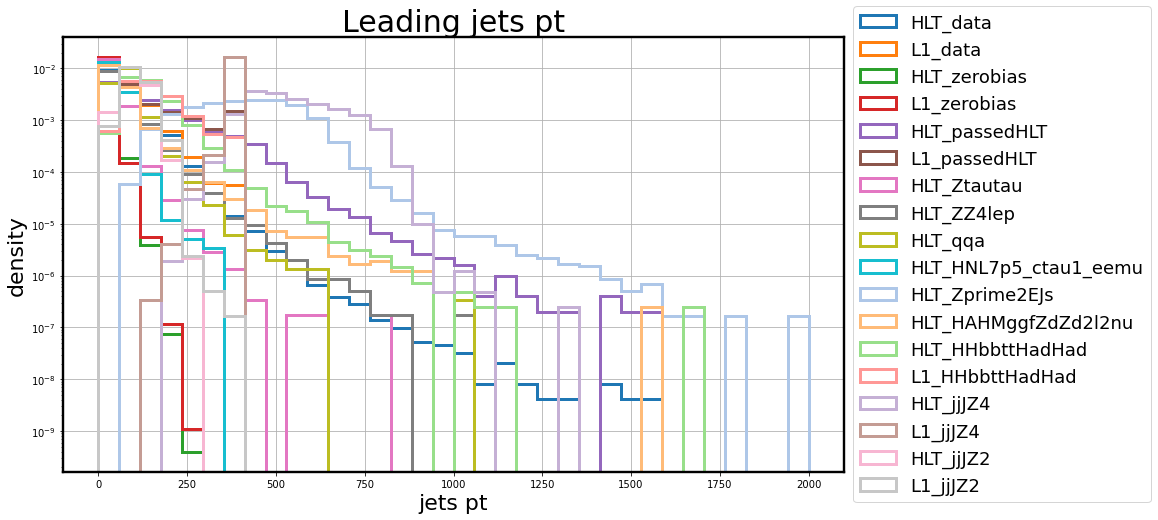

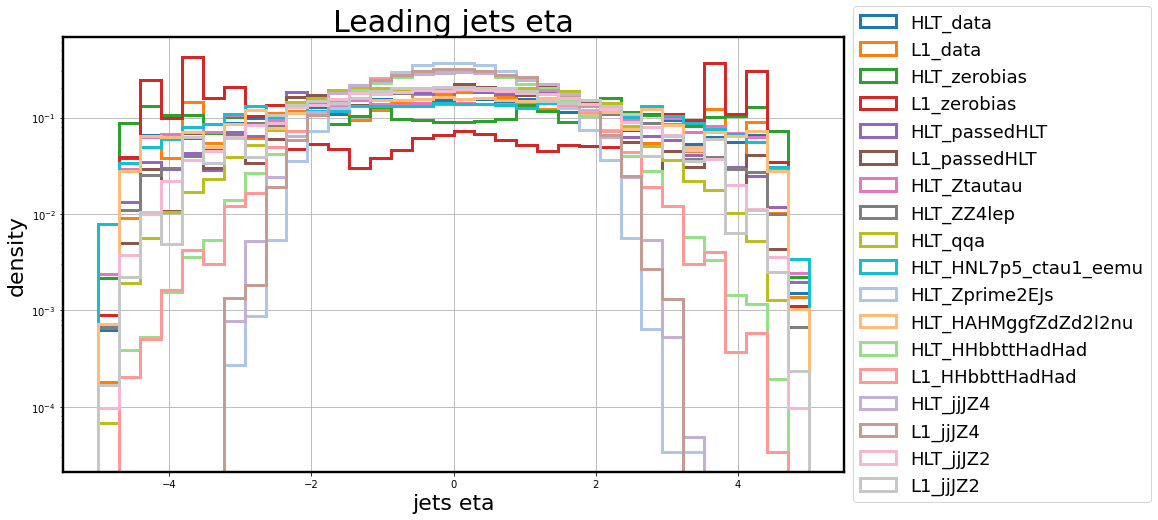

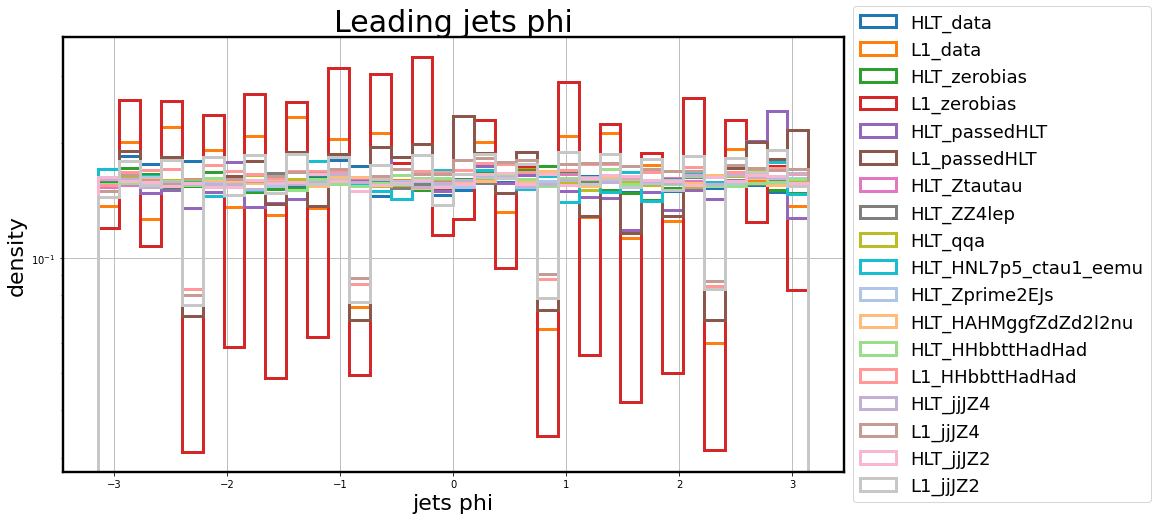

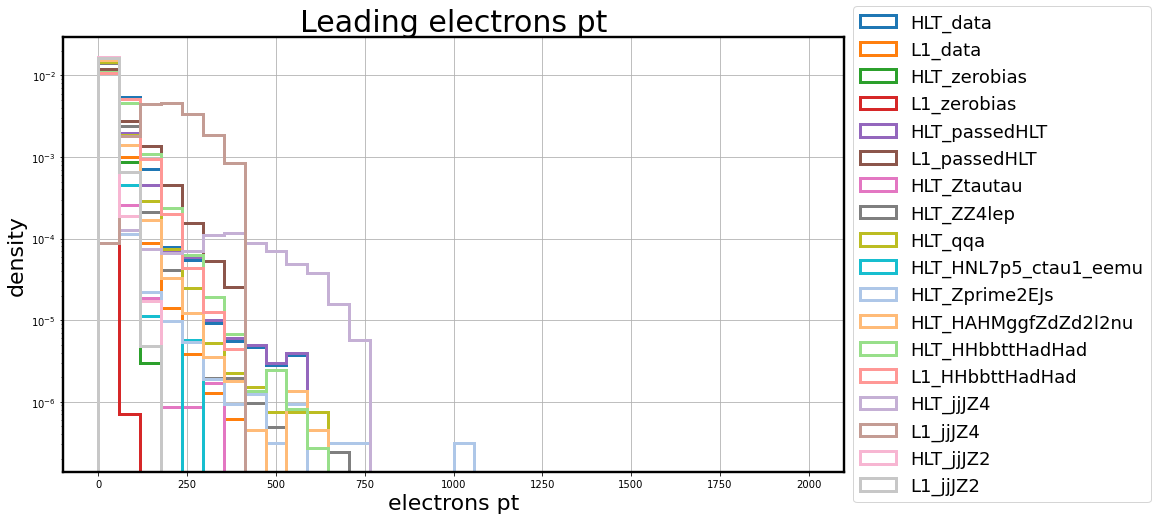

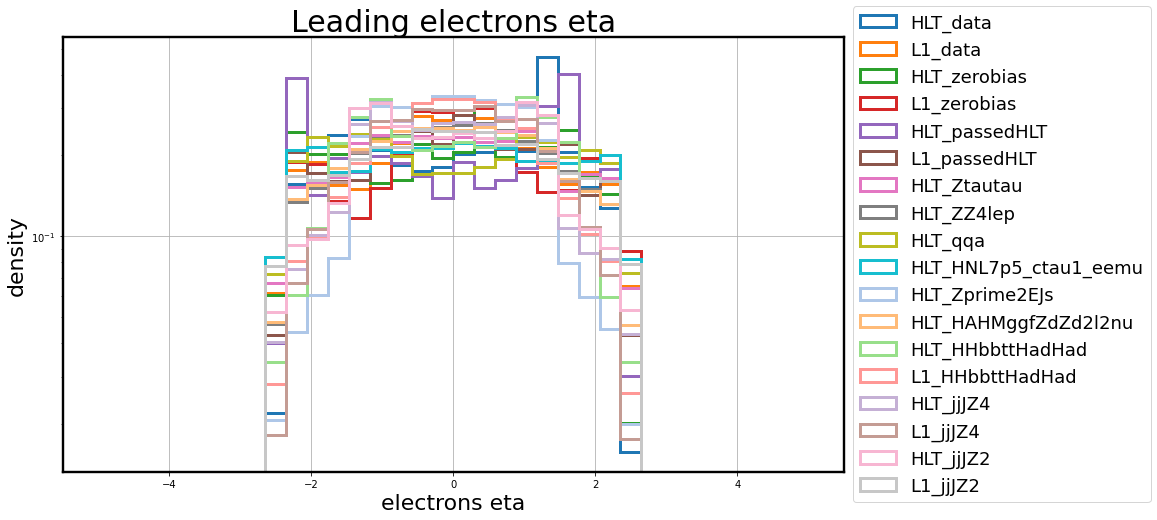

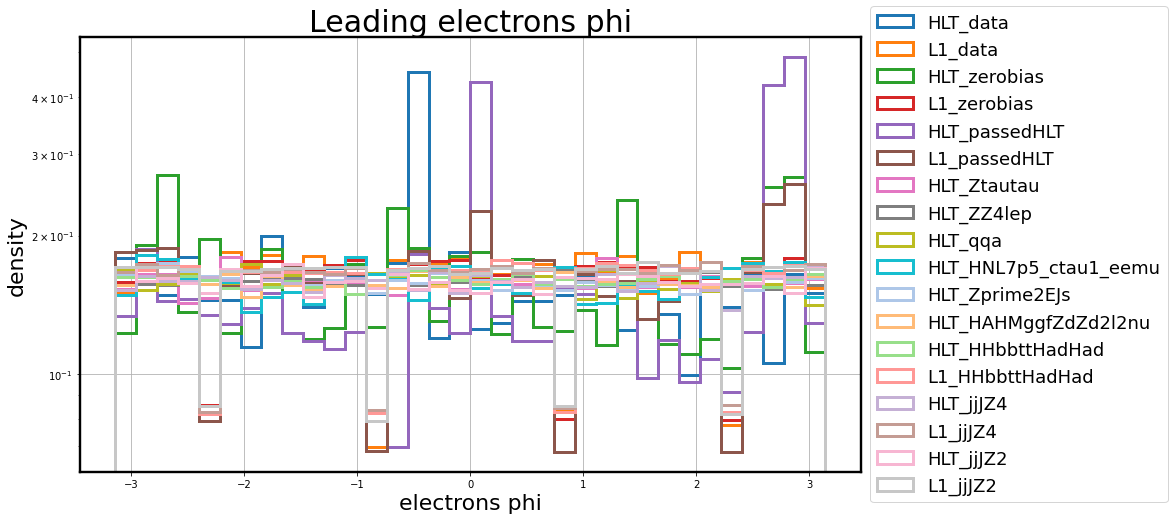

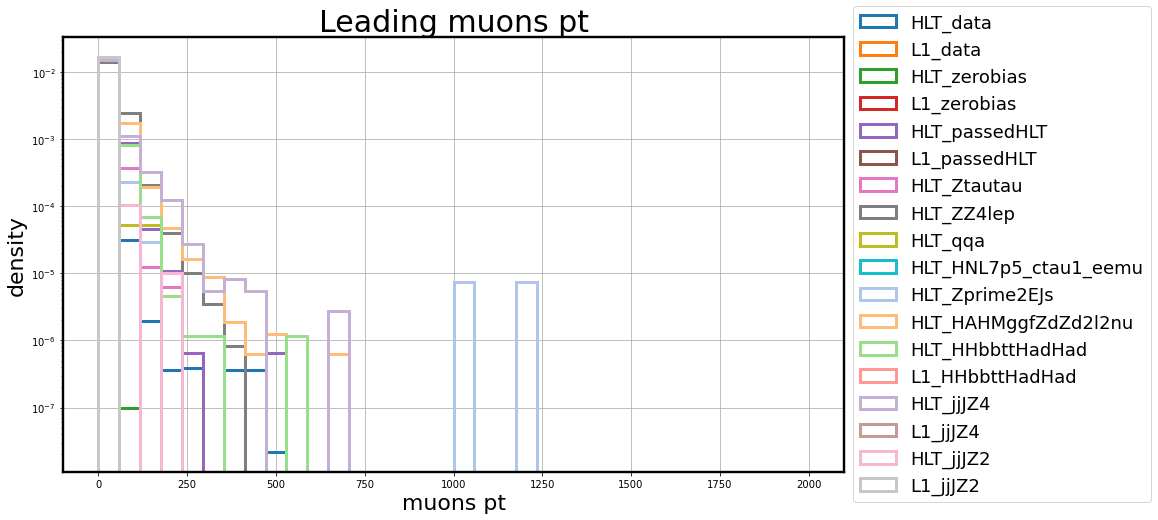

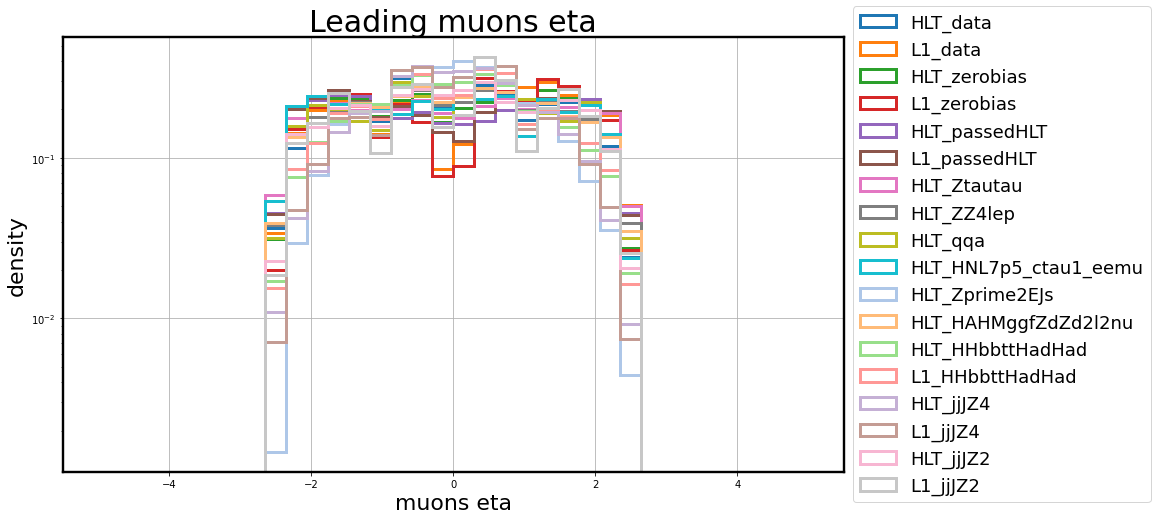

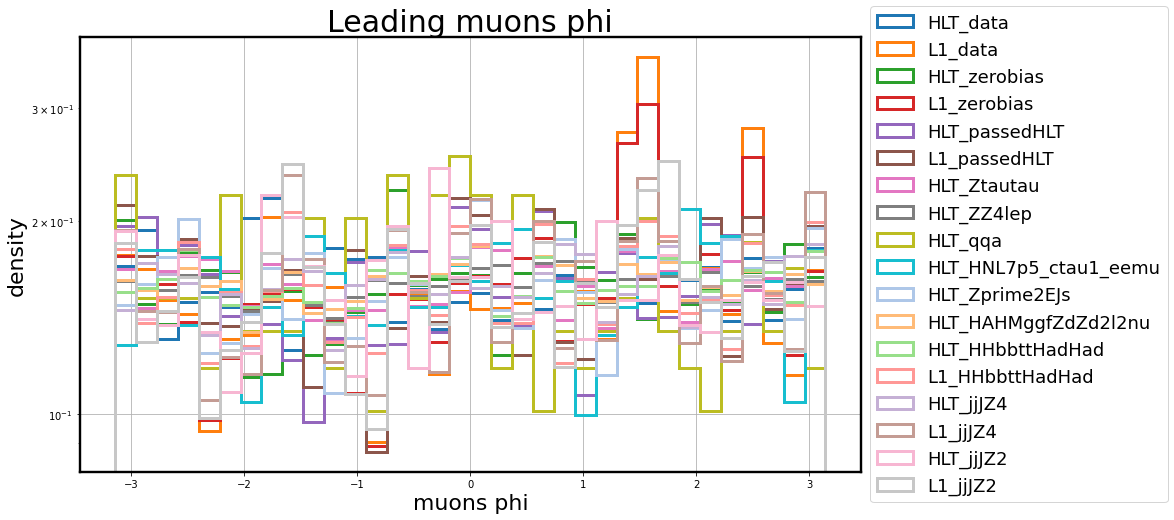

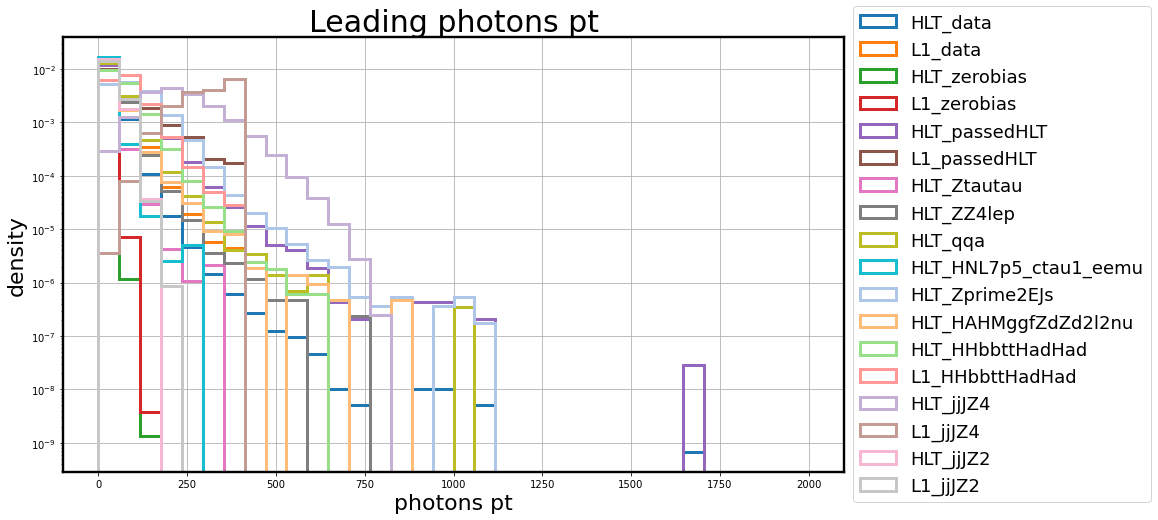

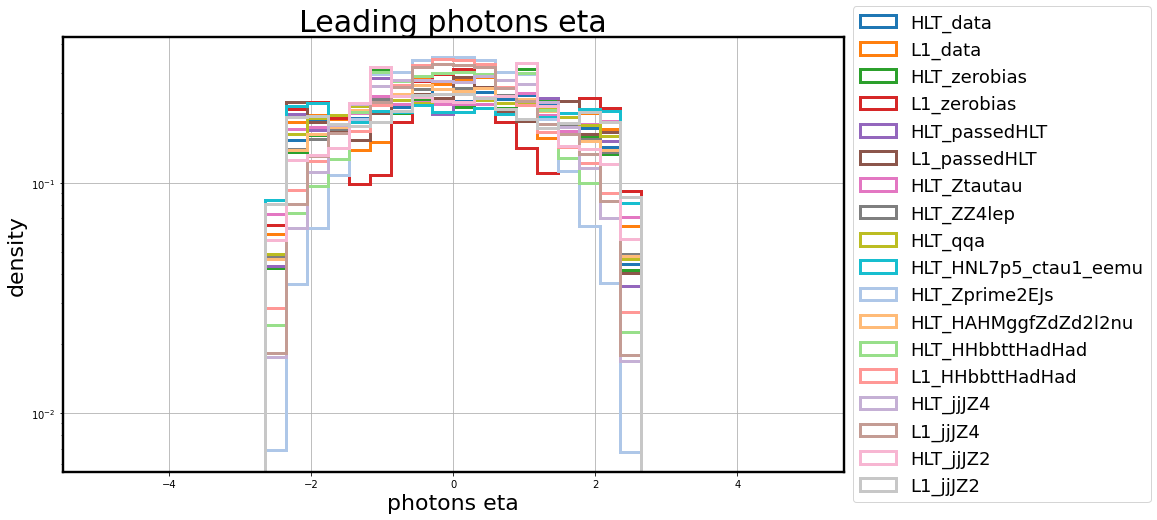

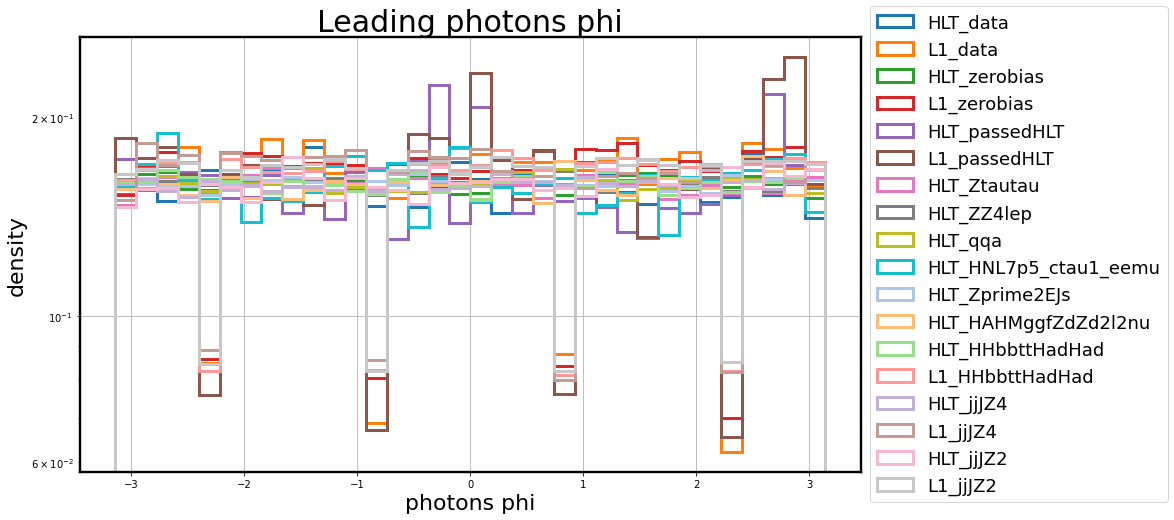

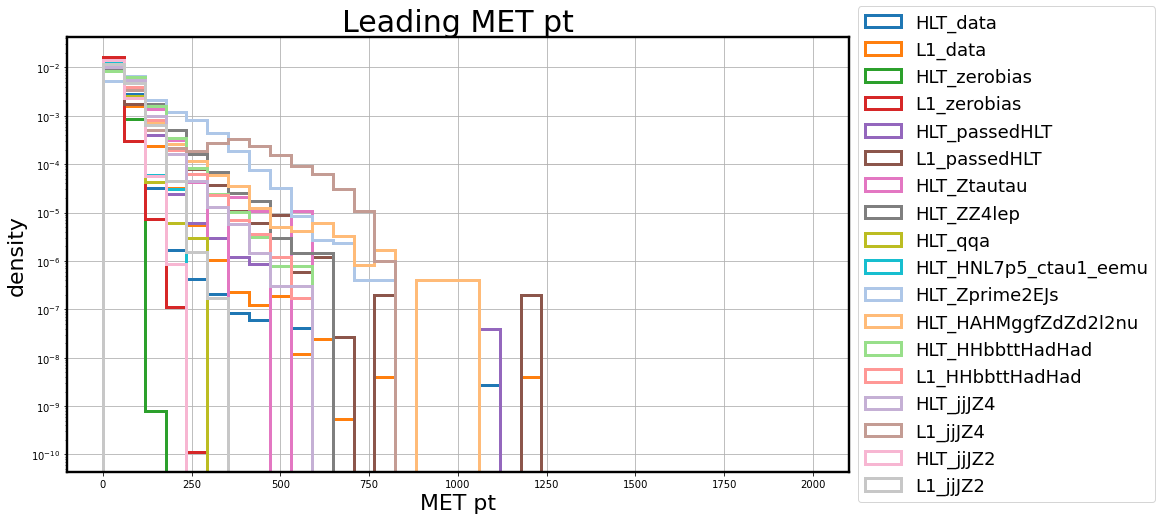

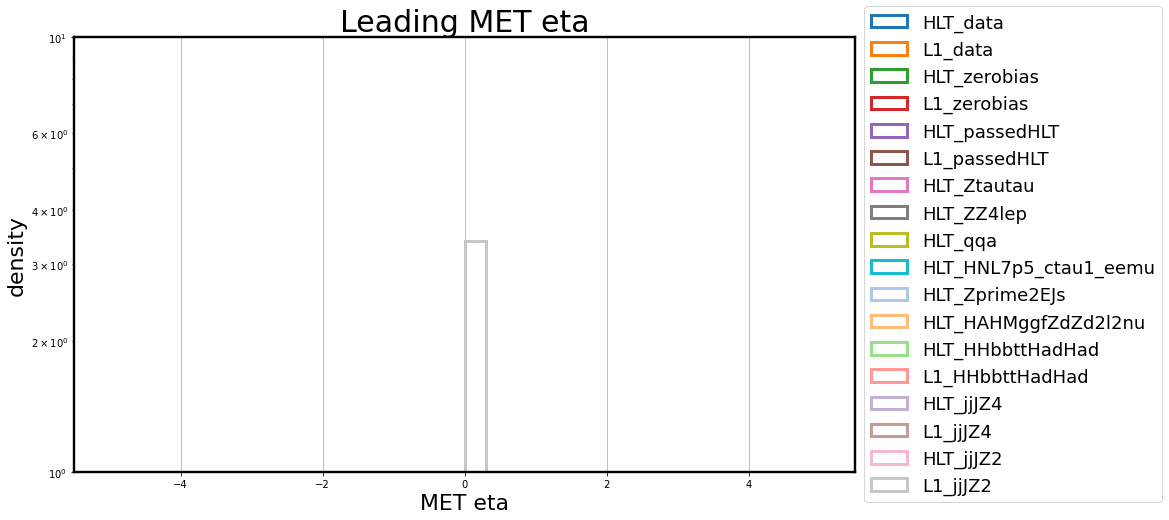

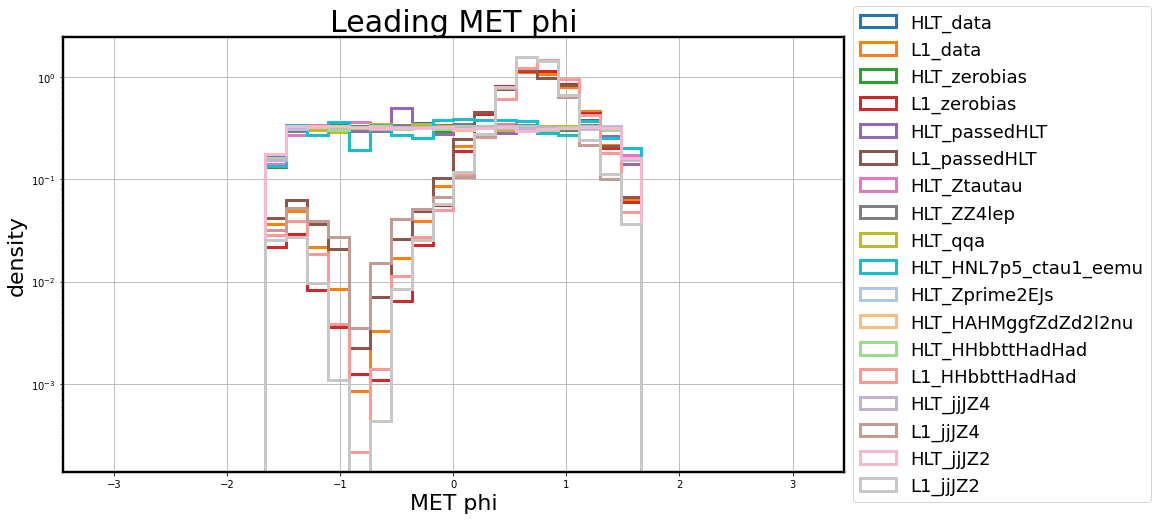

In [15]:
for object in ['jets', 'electrons', 'muons', 'photons', 'MET']:
    for var in ['pt', 'eta', 'phi']:
        plot_kinematics(datasets=datasets, weights=weights, object=object, var=var)

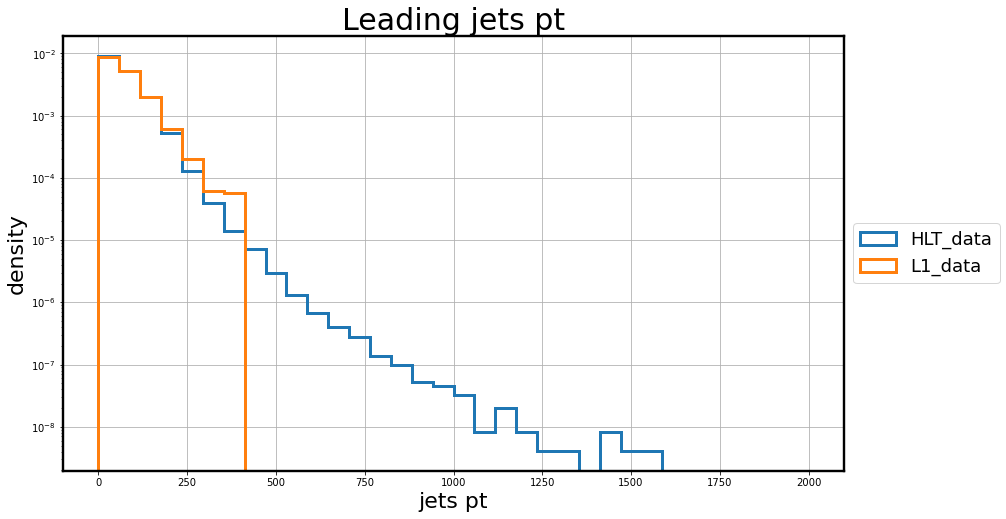

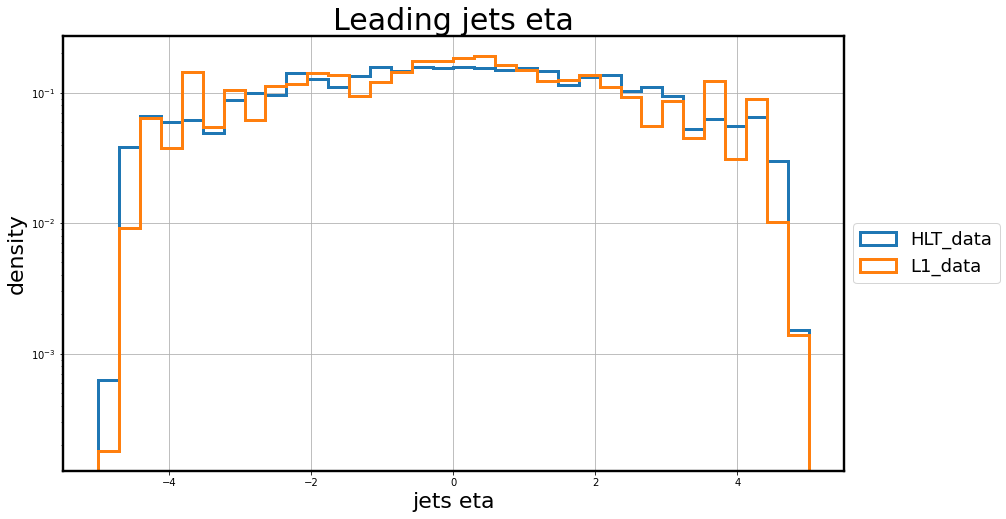

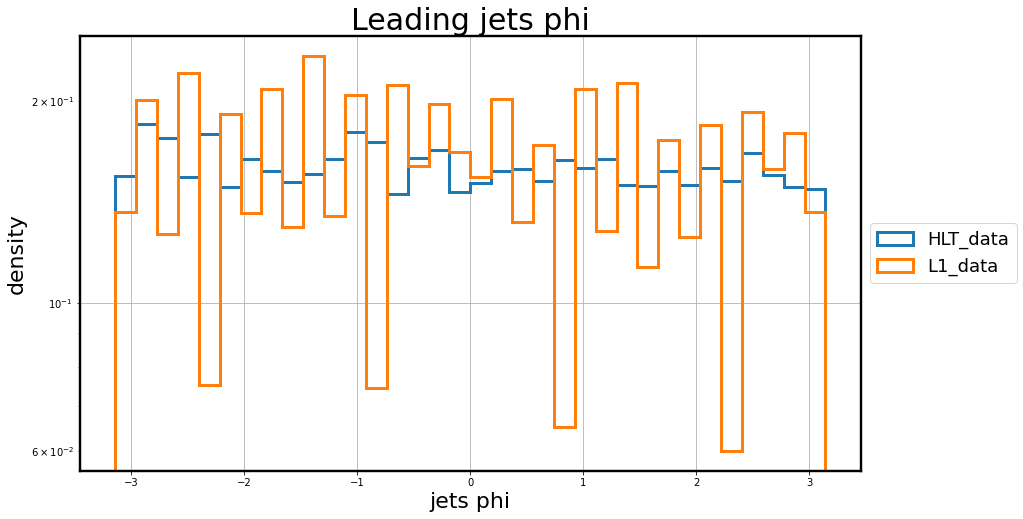

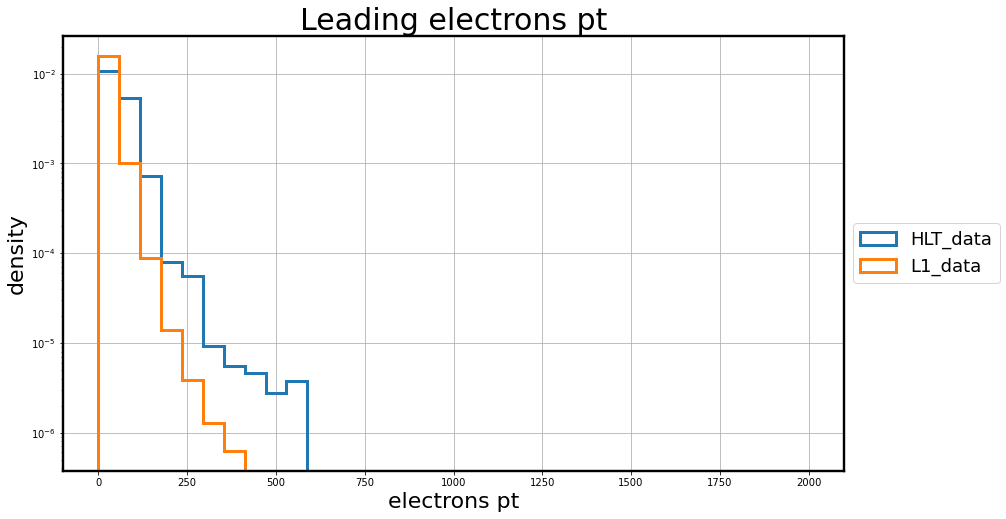

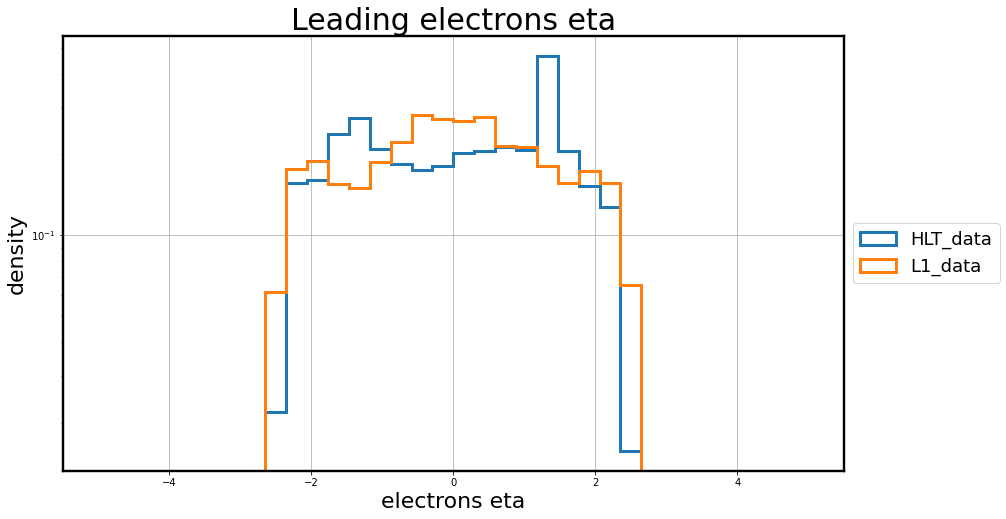

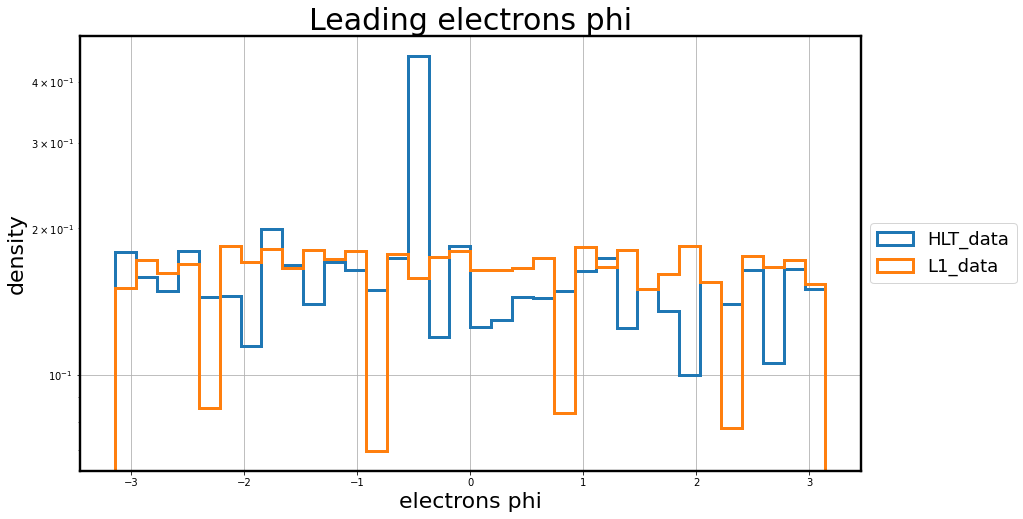

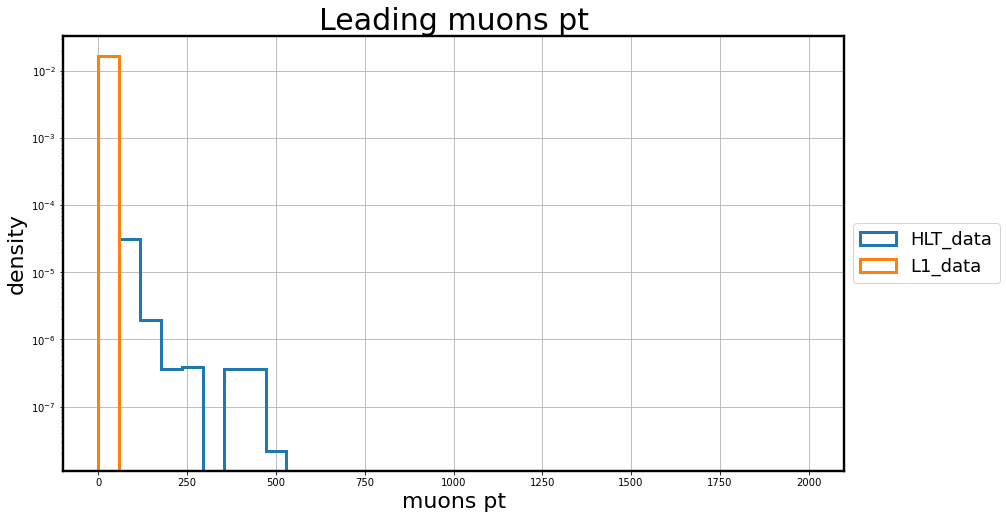

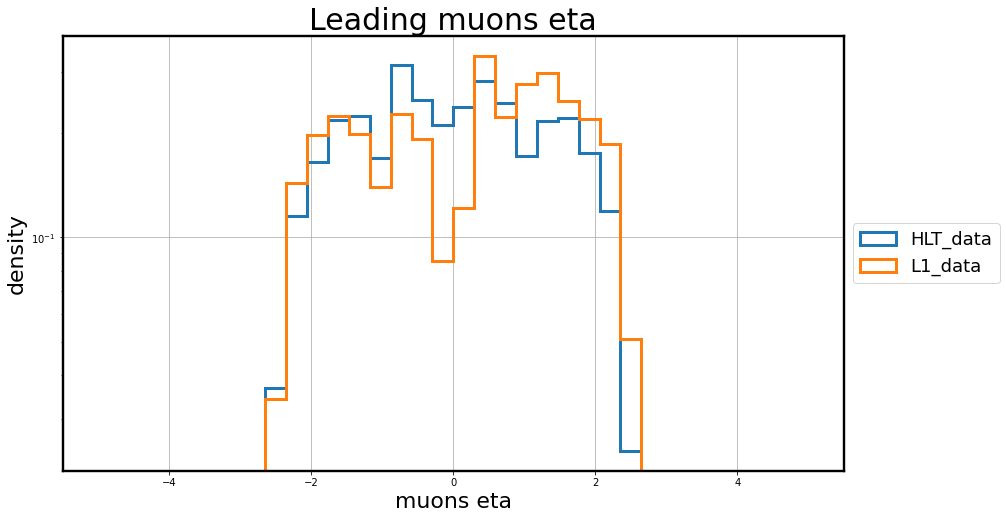

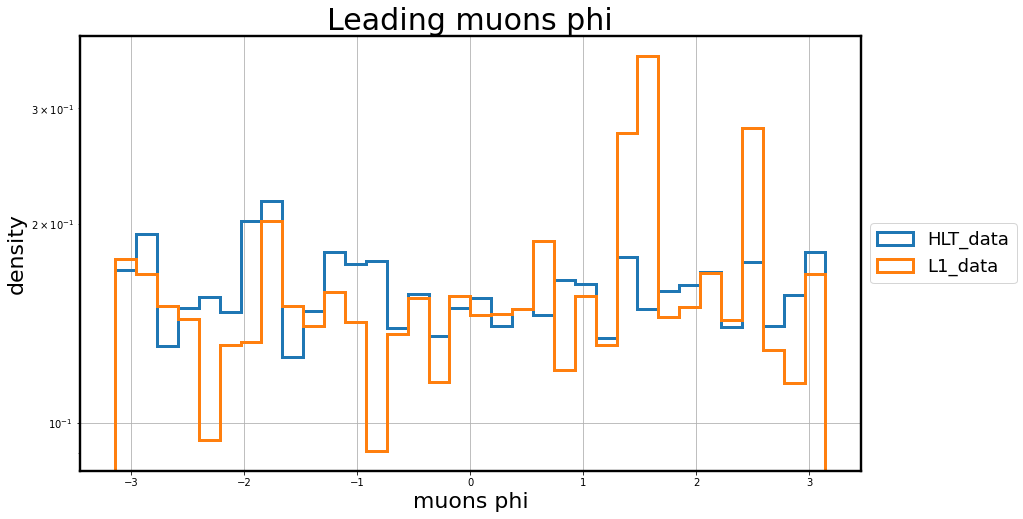

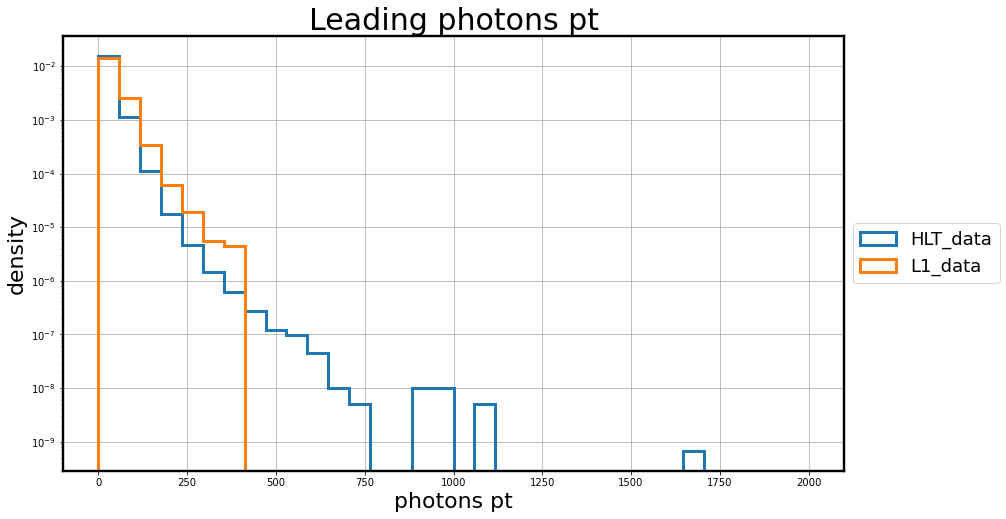

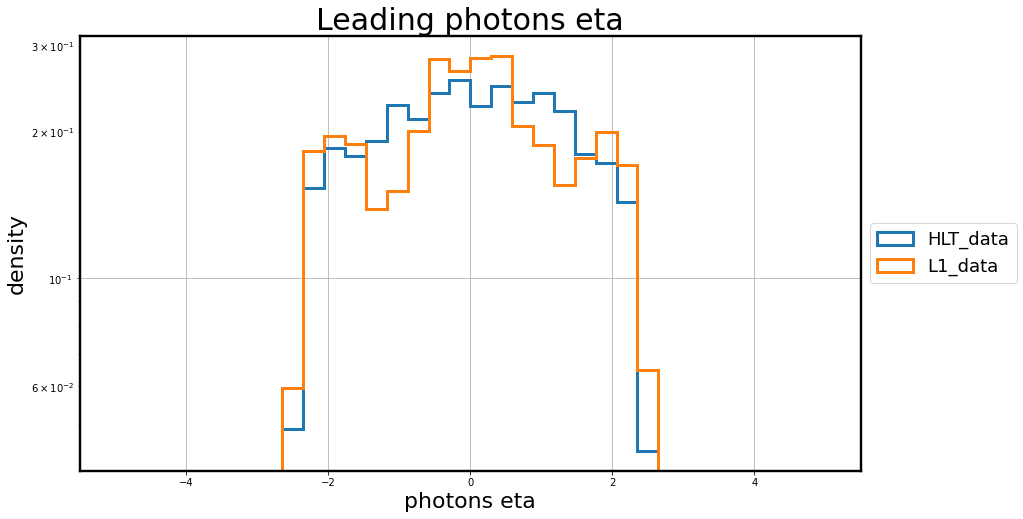

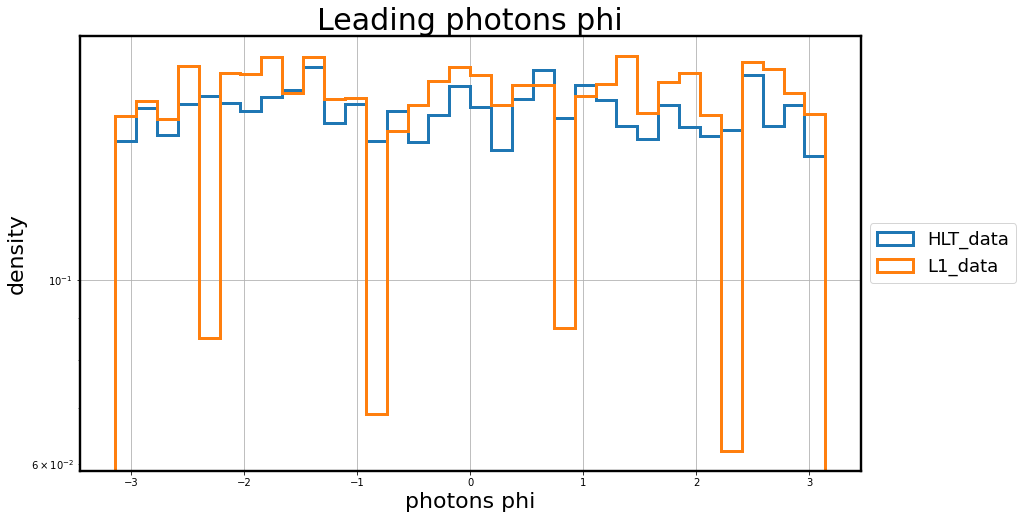

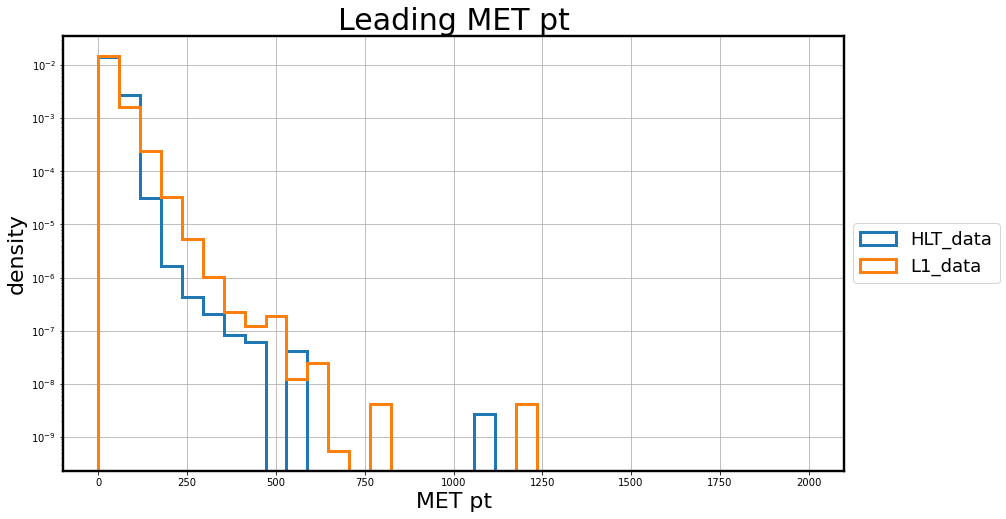

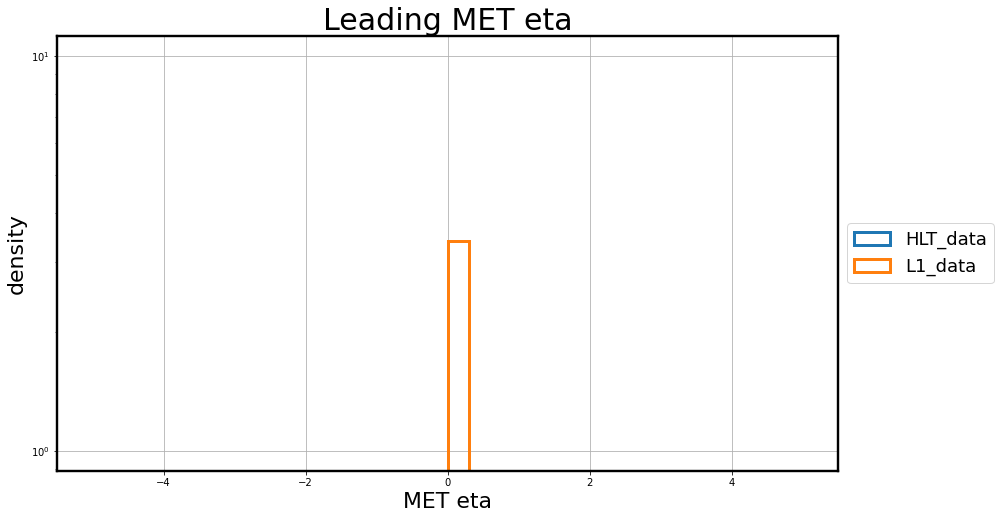

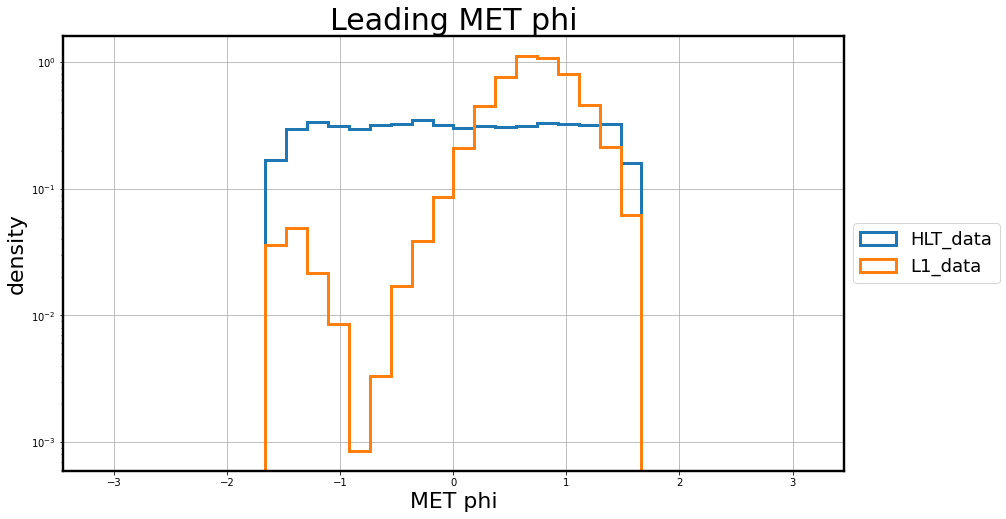

In [16]:
good_keys = ['HLT_data', 'L1_data']
plot_datasets = {key: value for key, value in datasets.items() if key in good_keys}

for object in ['jets', 'electrons', 'muons', 'photons', 'MET']:
    for var in ['pt', 'eta', 'phi']:
        plot_kinematics(datasets=plot_datasets, weights=weights, object=object, var=var)

In [17]:
def plot_event(event, dataset_tag=''):
    '''Visual representation of an event. Plots objects in the eta-phi plane, with the pt being
    represented as the size of the marker.'''
    labels = {
        'Jet': 'blue',
        'Electron': 'yellow',
        'Muon': 'green',
        'Photon': 'red',
        'MET': 'black'
    }
    colors = 10*['blue'] + 3*['yellow'] + 3*['green'] + 3*['red'] + ['black']

    
    pt = event[:, 0]
    eta = event[:, 1]
    phi = event[:, 2]

    plt.figure(figsize=(10, 7))
    plt.scatter(phi, eta, s=pt*10, c=colors)

    legend_handles = []
    for obj_type, color in labels.items():
        legend_handles.append(mpatches.Patch(color=color, label=obj_type))

    plt.legend(handles=legend_handles, fontsize=14)

    plt.xlabel('Phi', fontsize=16)
    plt.ylabel('Eta', fontsize=16)
    plt.title(f'Spatial Distribution of Objects in {dataset_tag} Event', fontsize=20)
    plt.grid(True)
    plt.show()

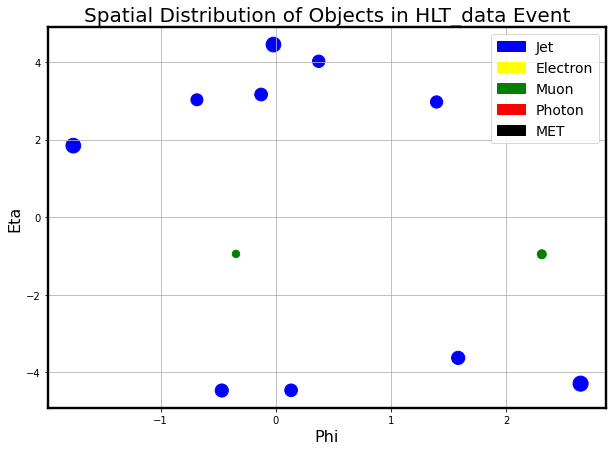

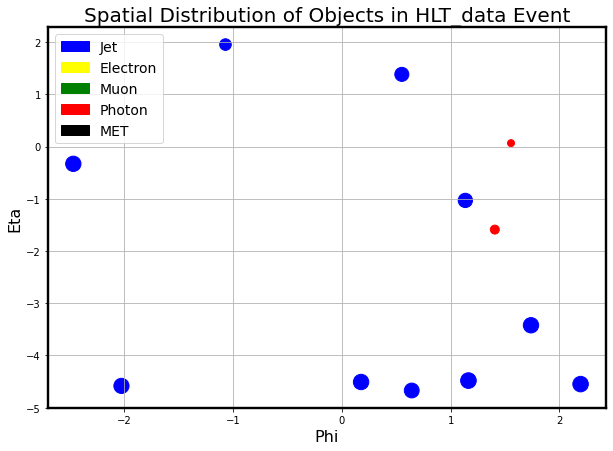

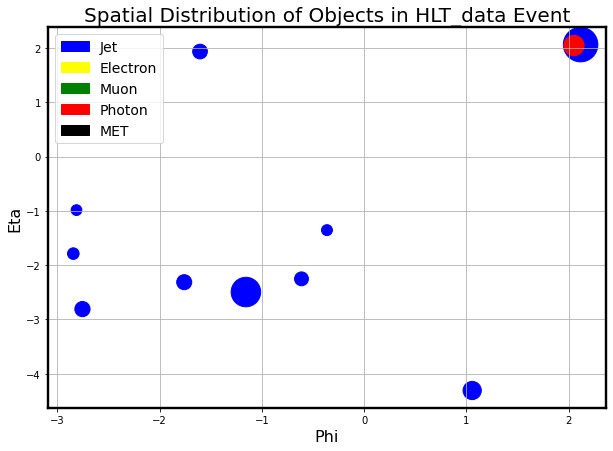

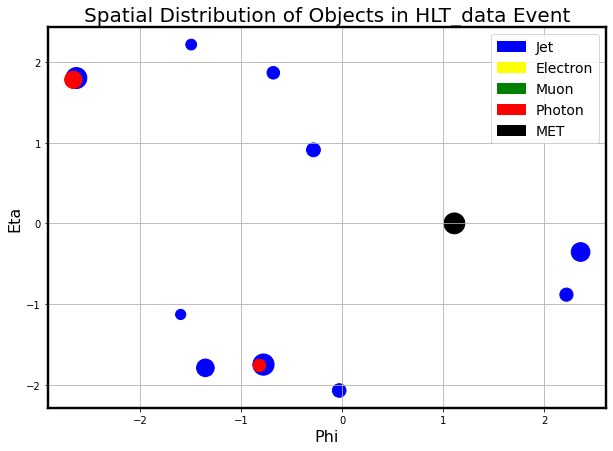

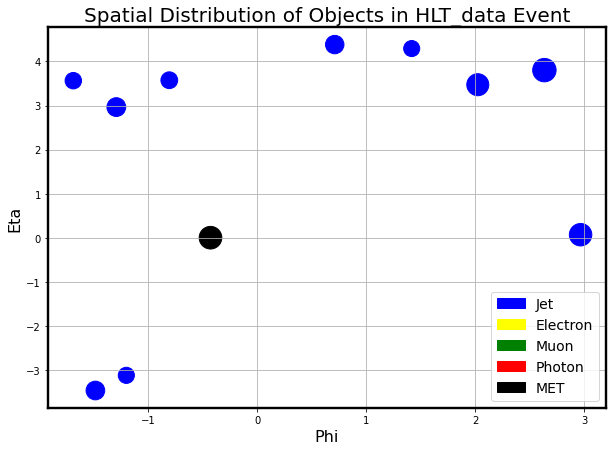

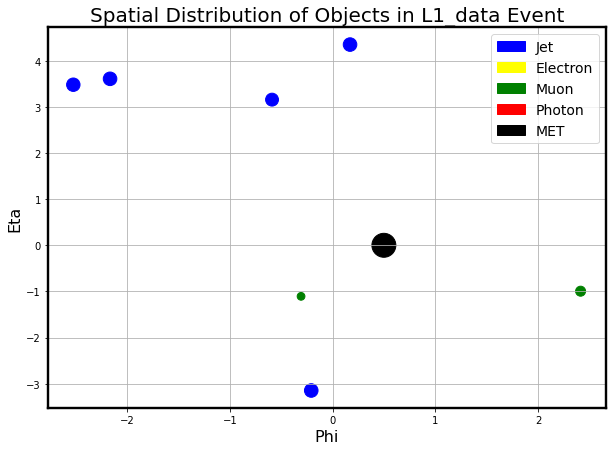

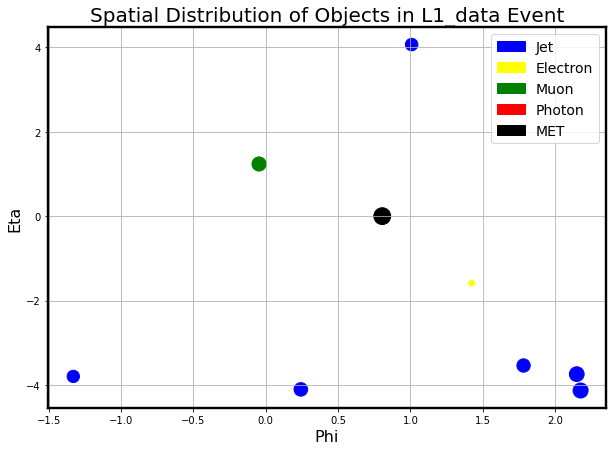

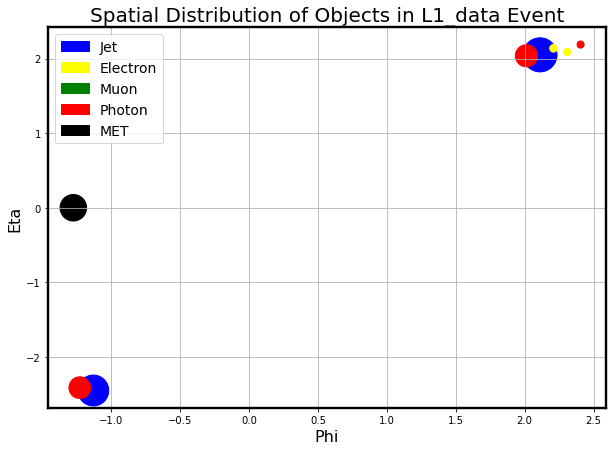

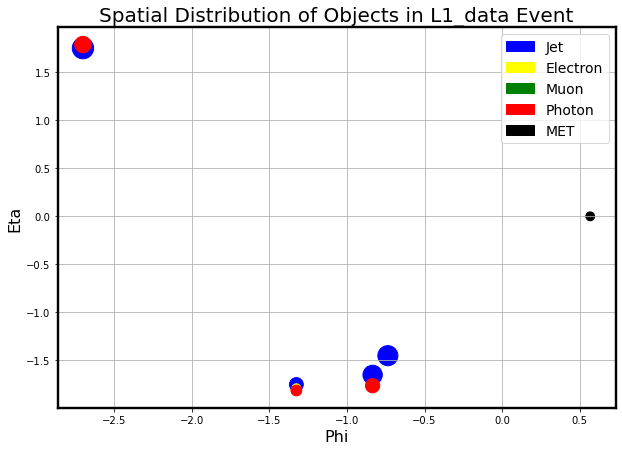

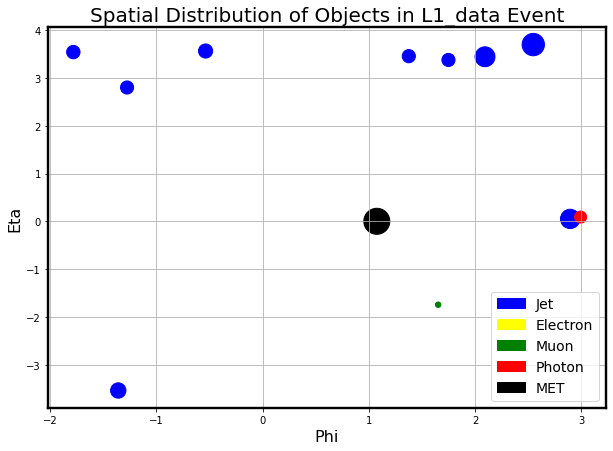

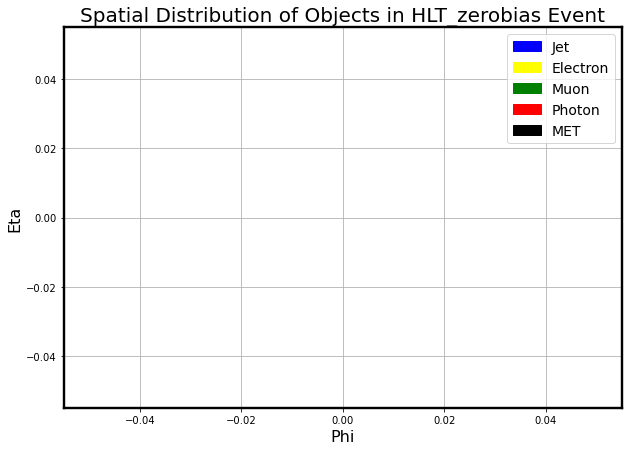

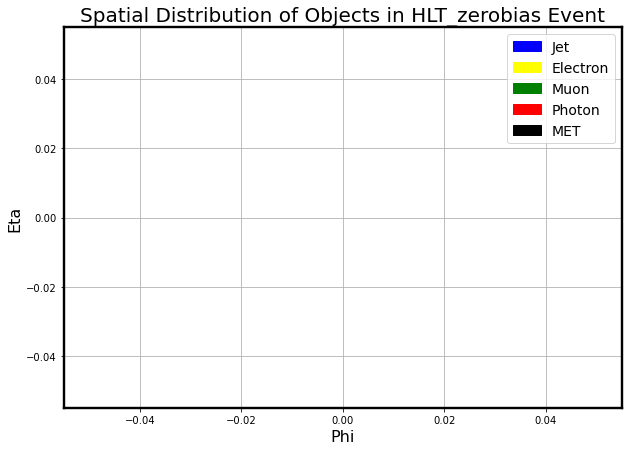

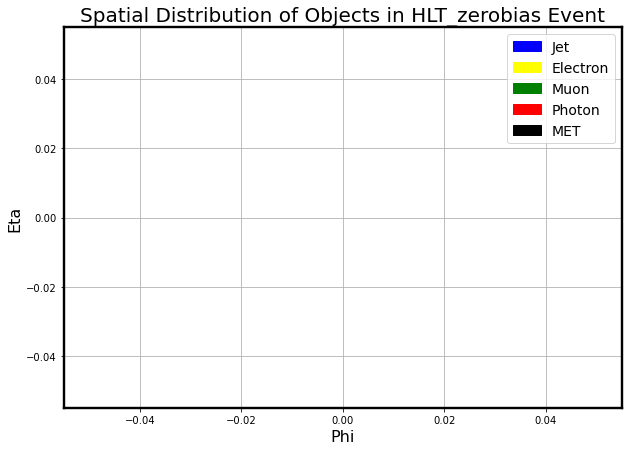

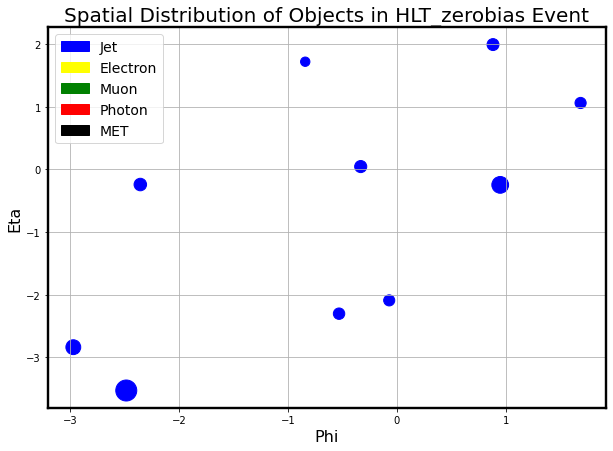

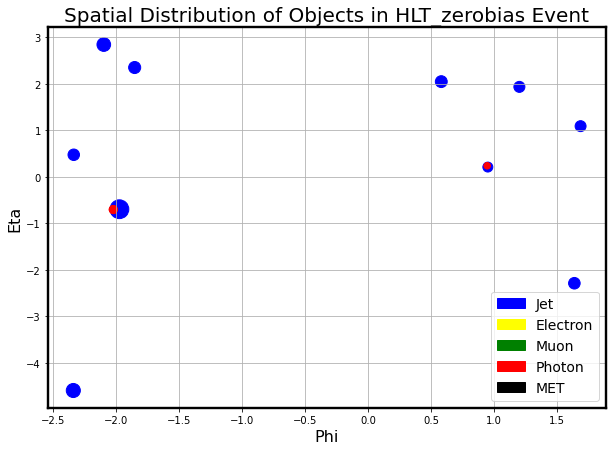

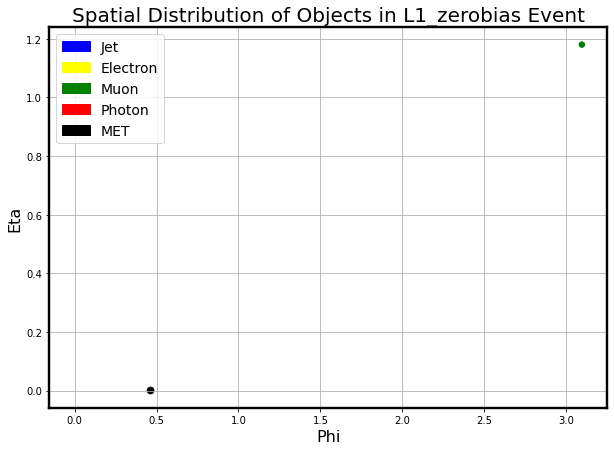

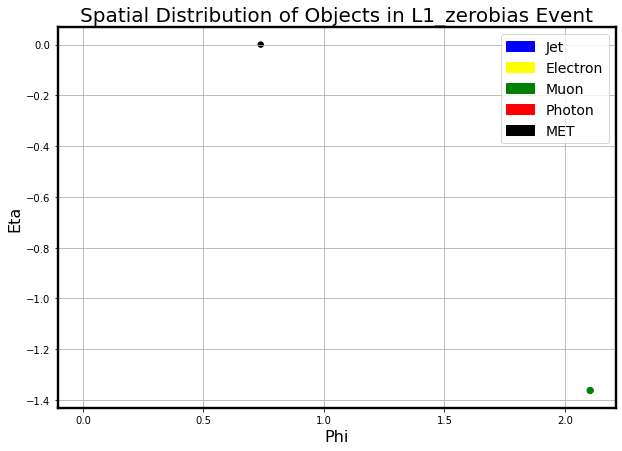

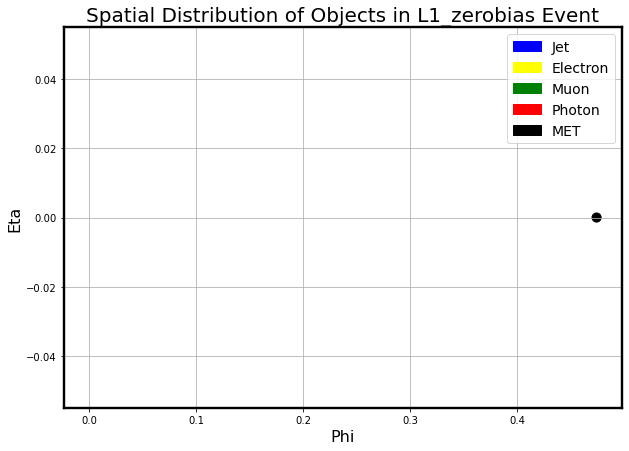

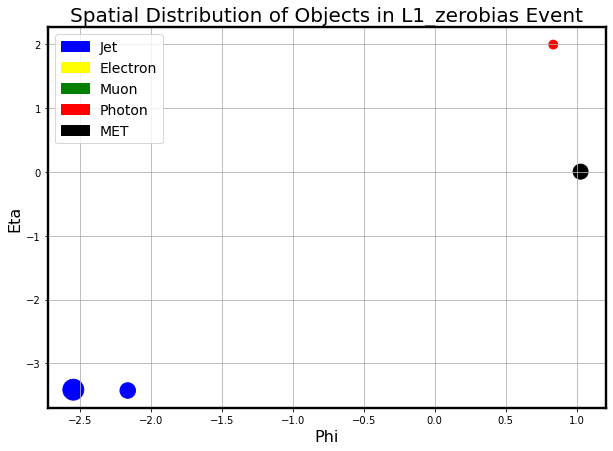

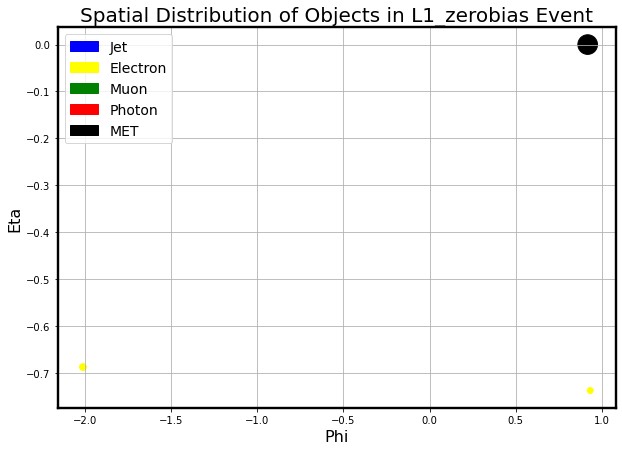

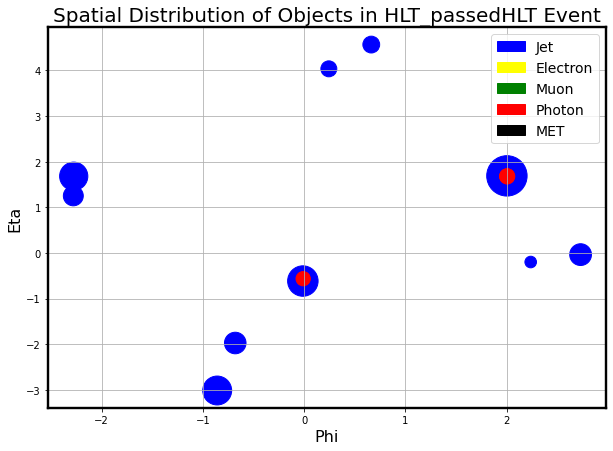

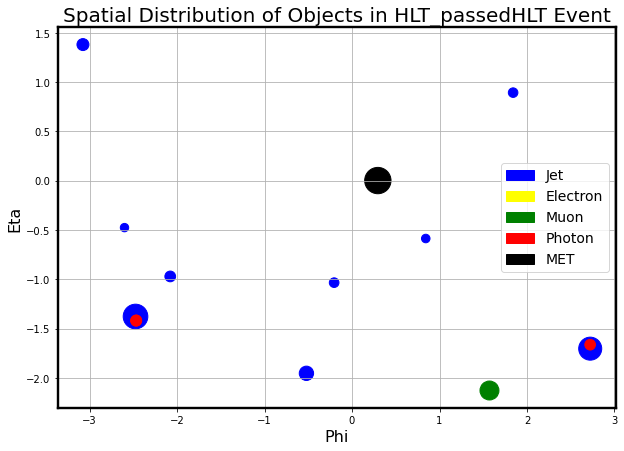

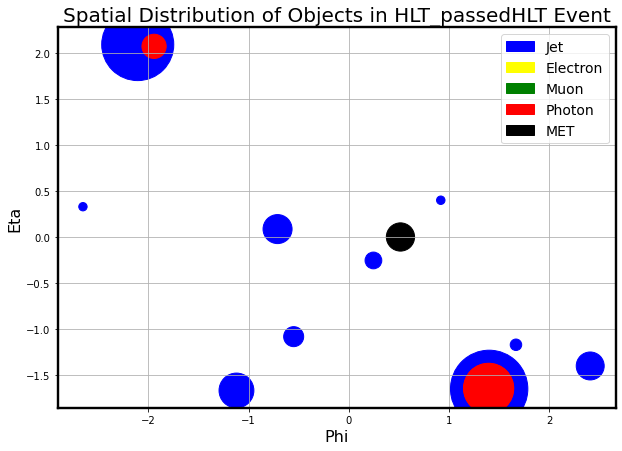

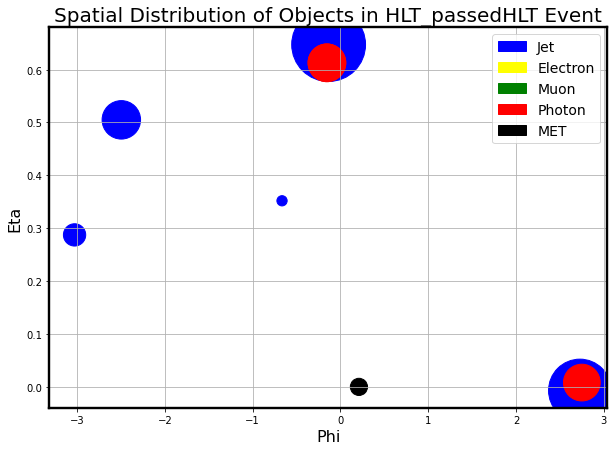

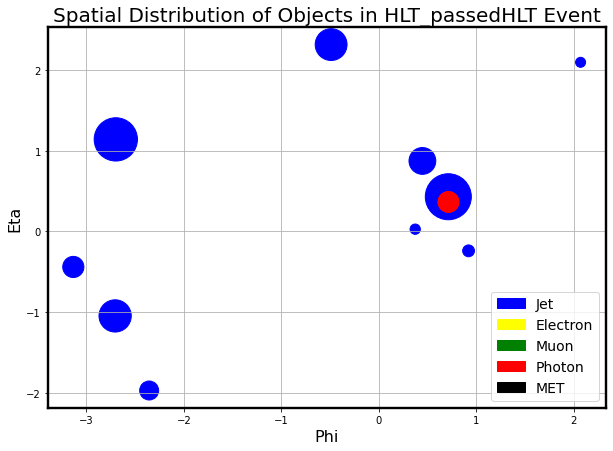

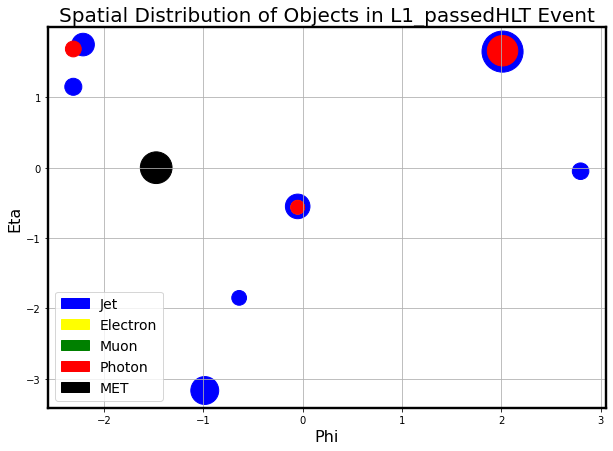

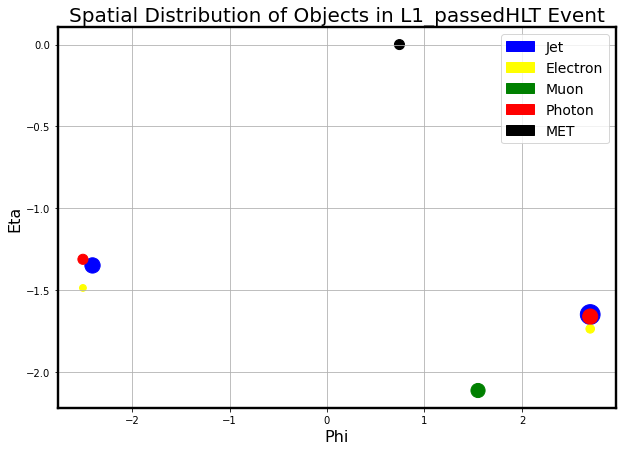

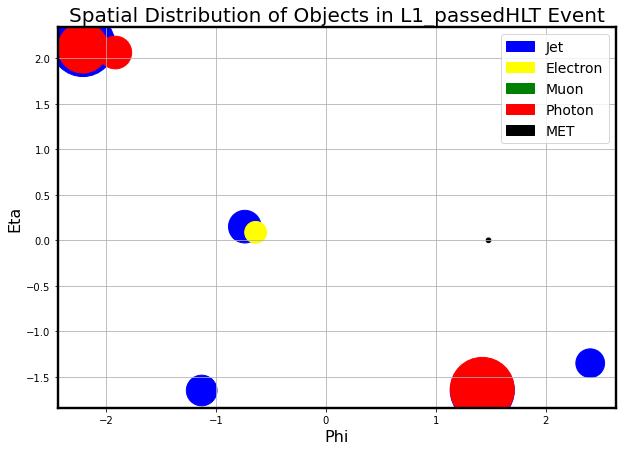

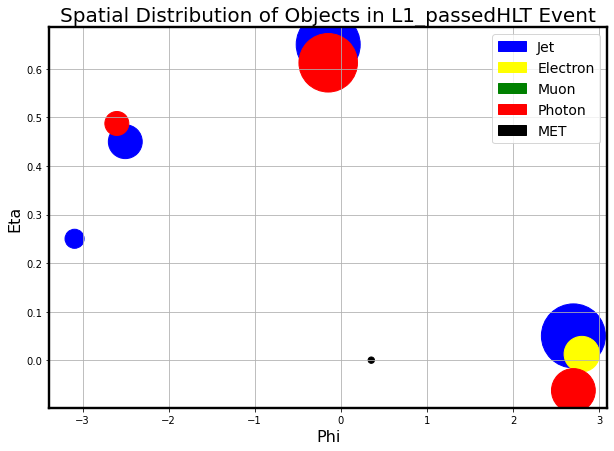

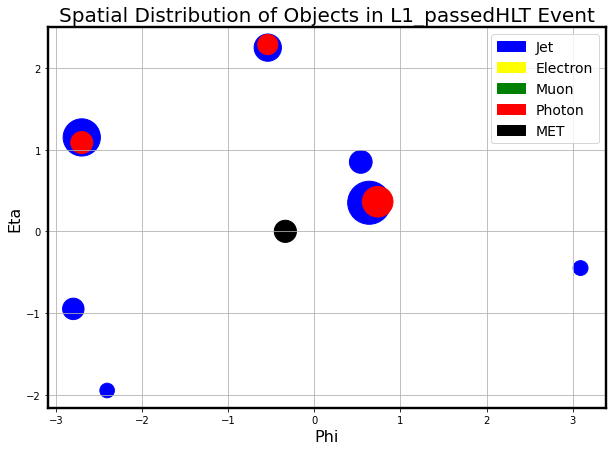

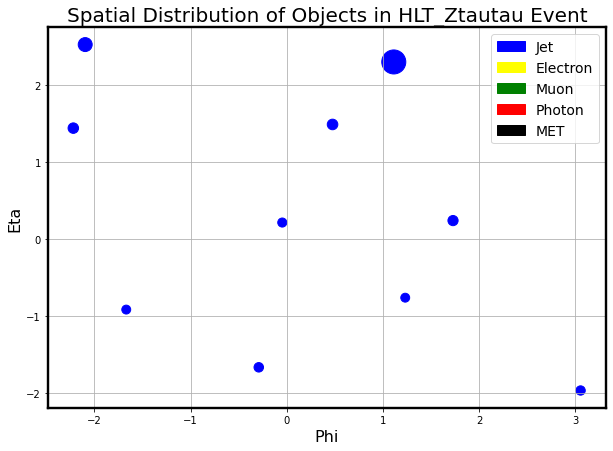

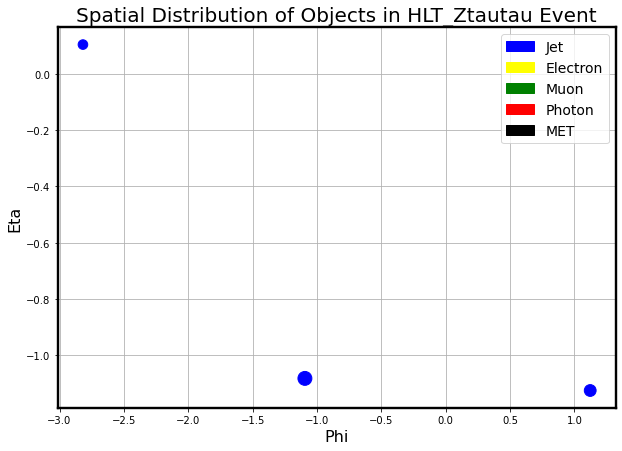

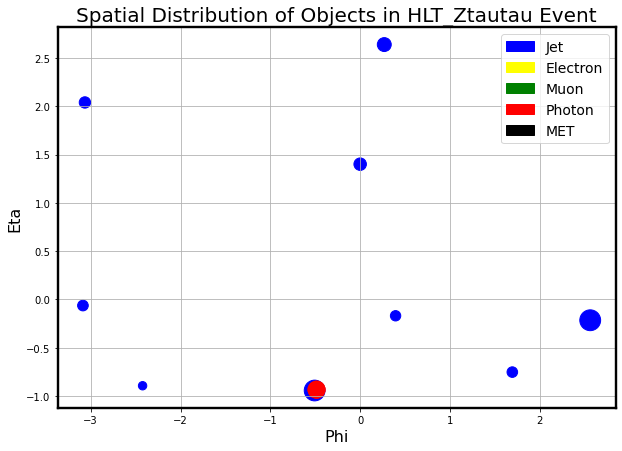

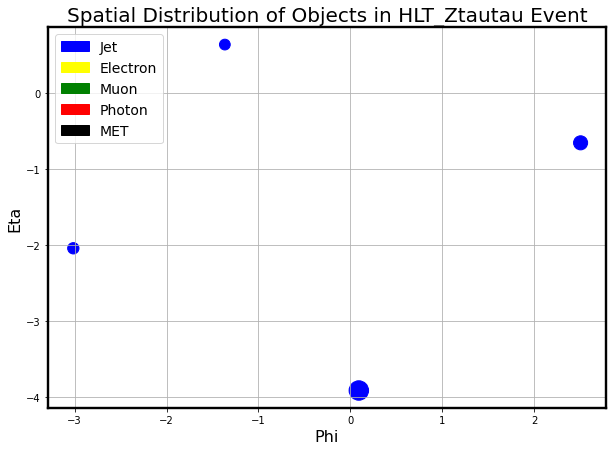

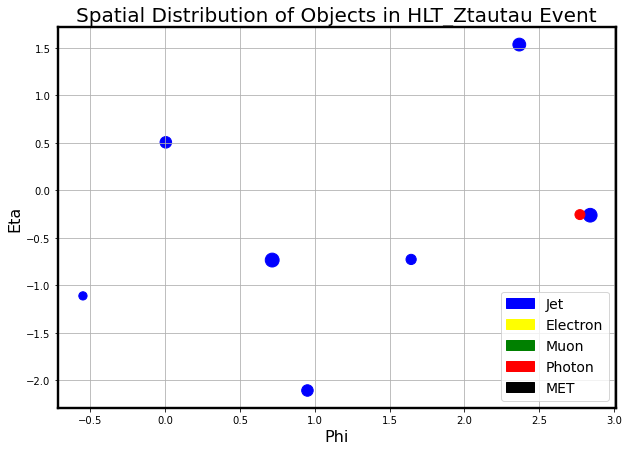

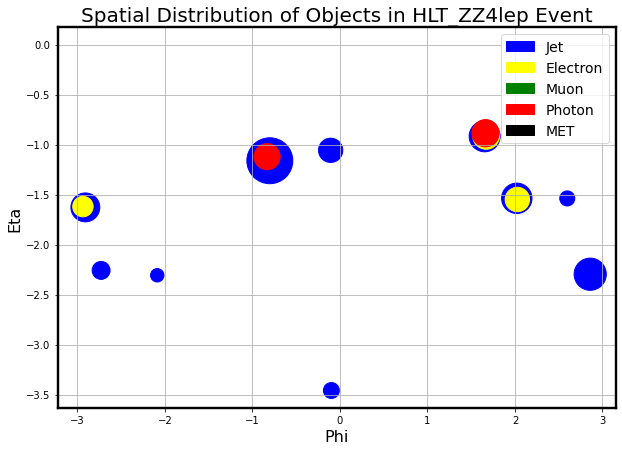

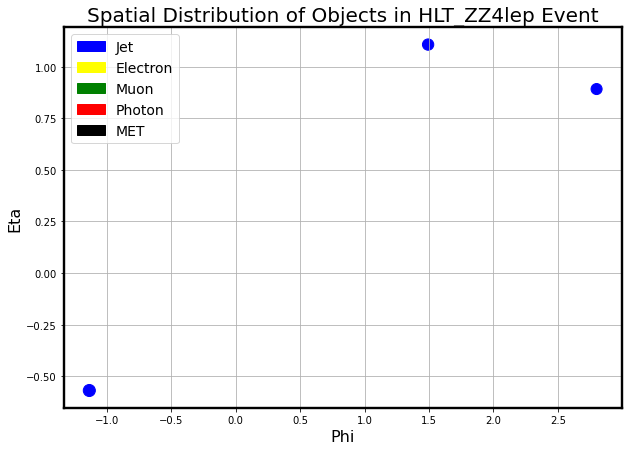

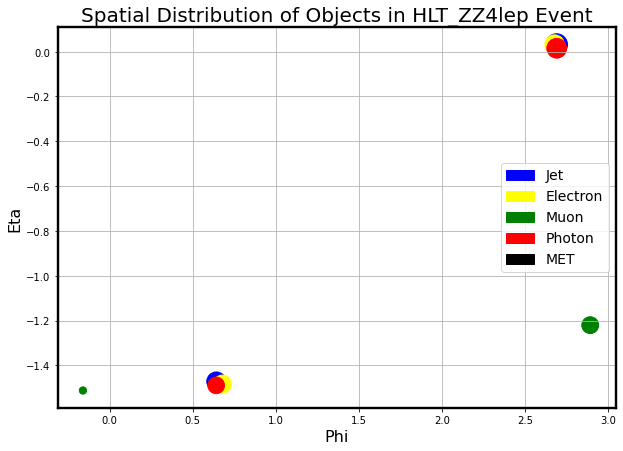

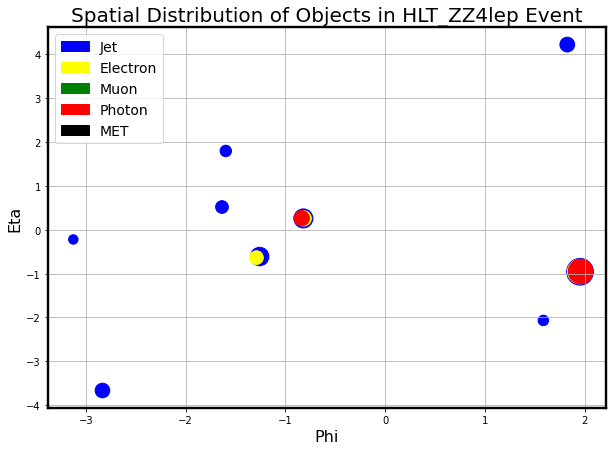

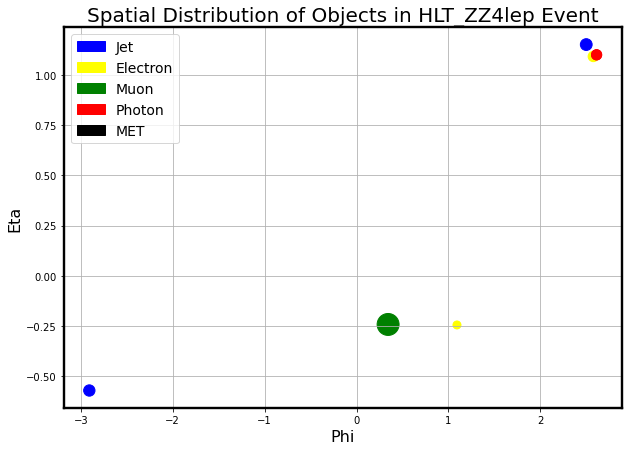

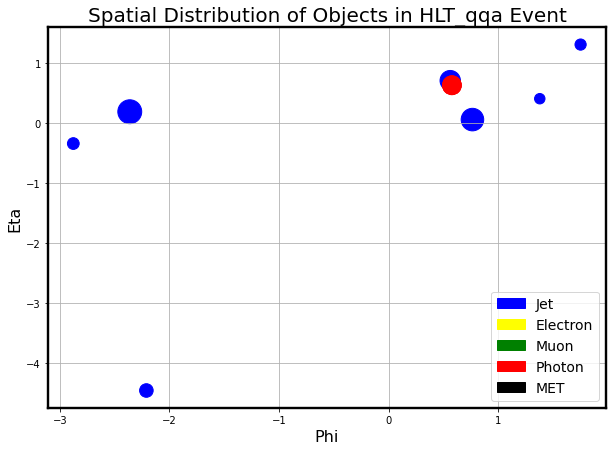

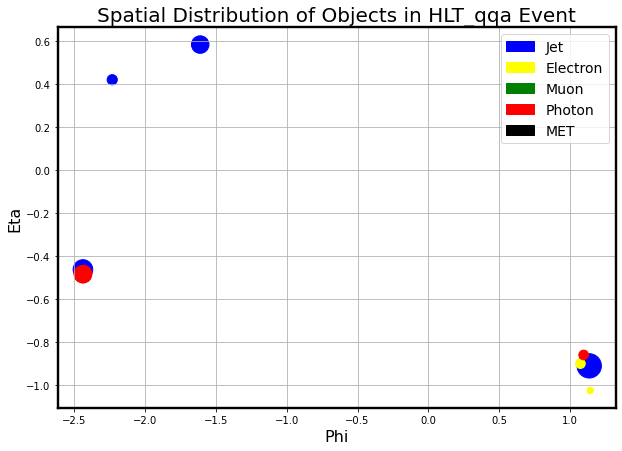

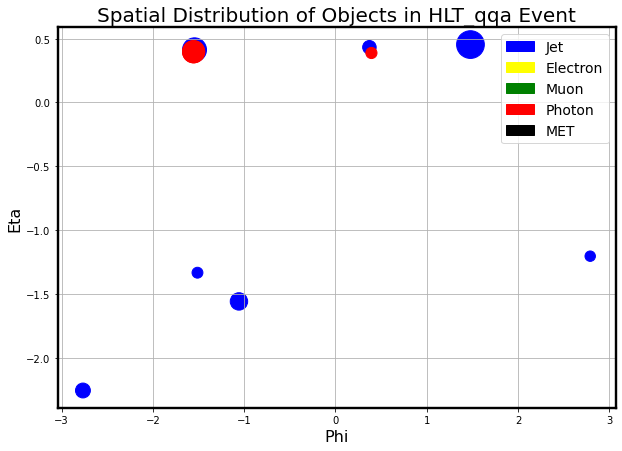

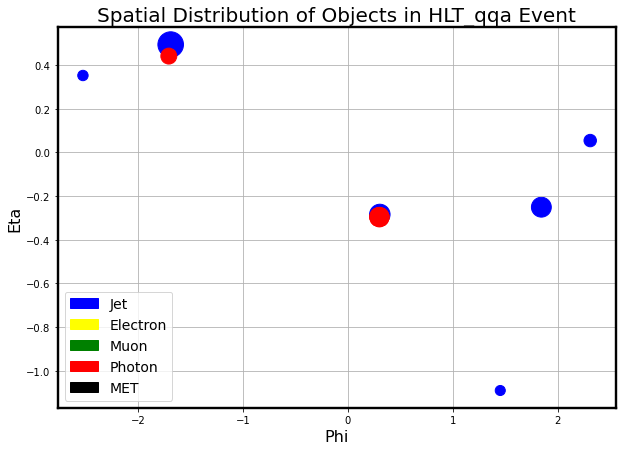

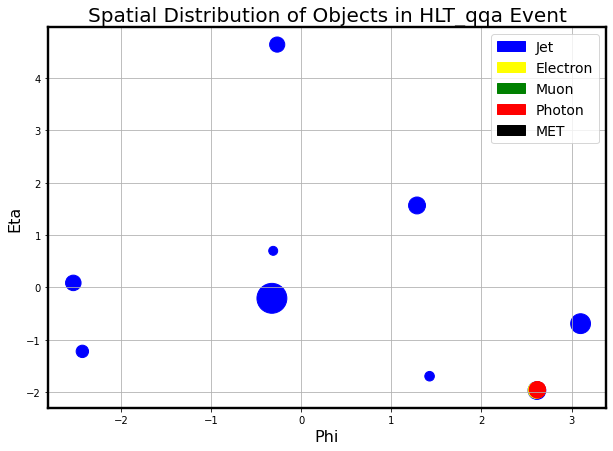

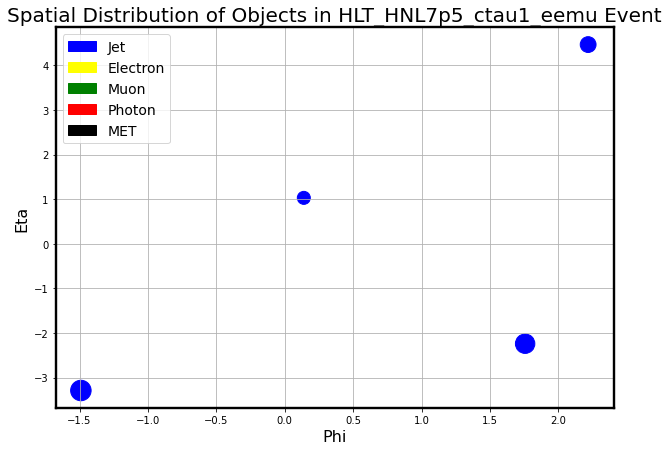

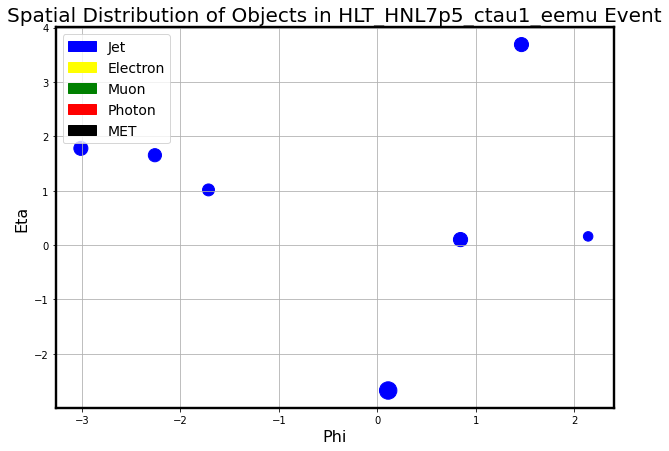

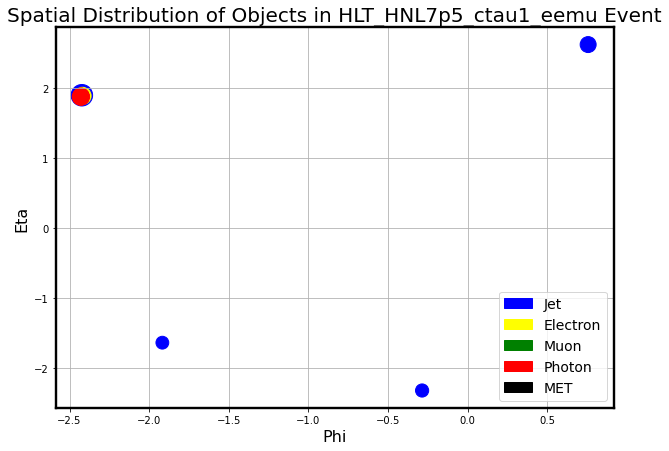

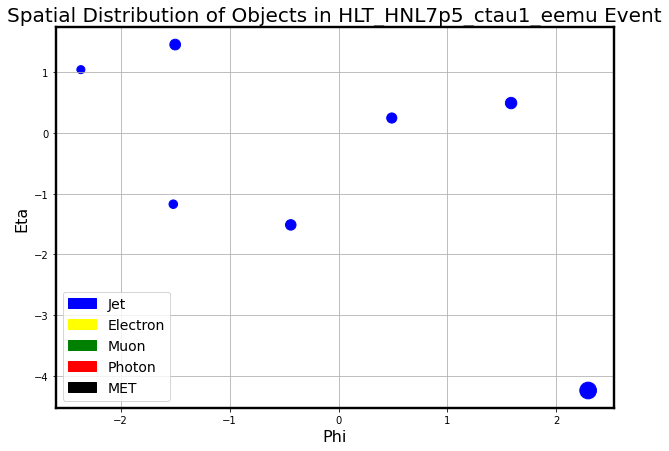

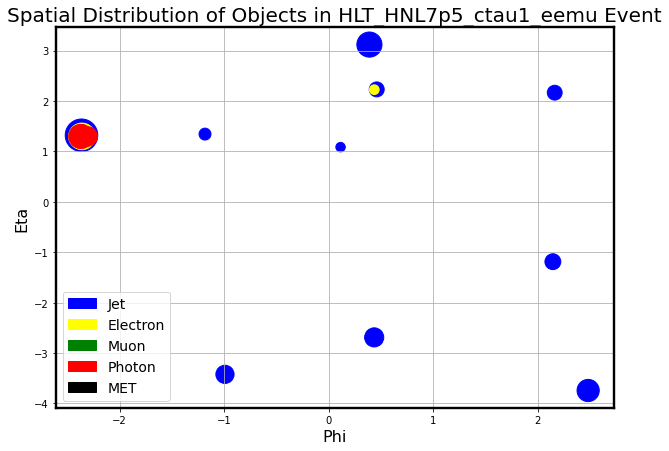

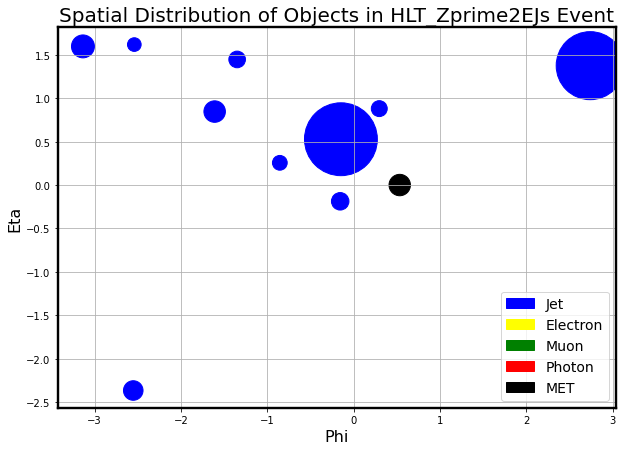

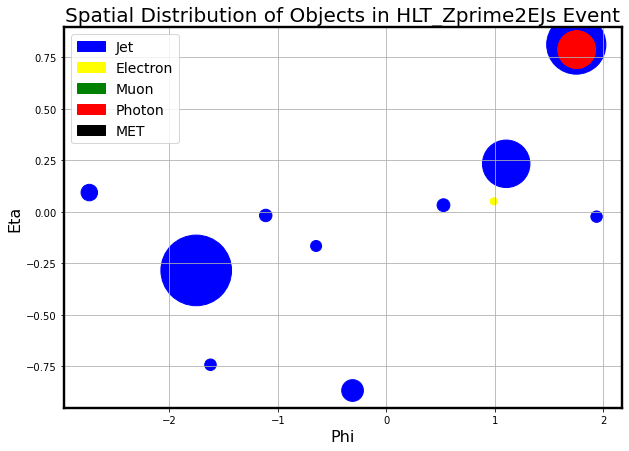

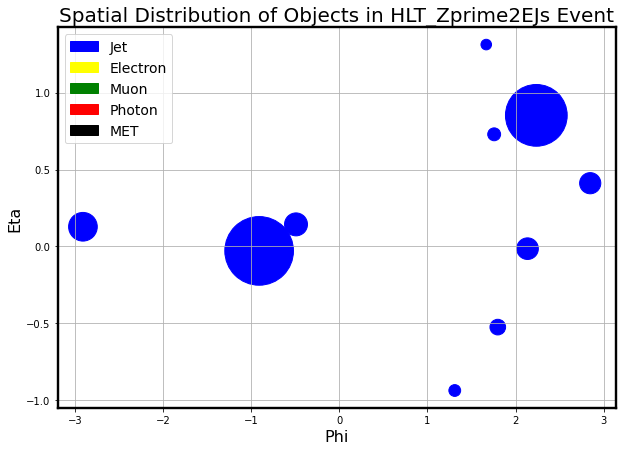

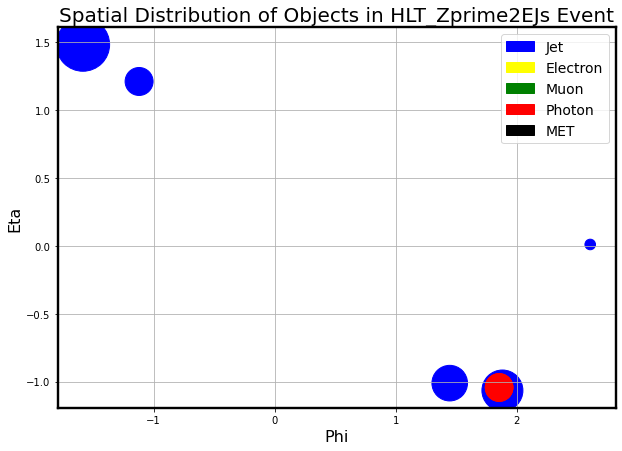

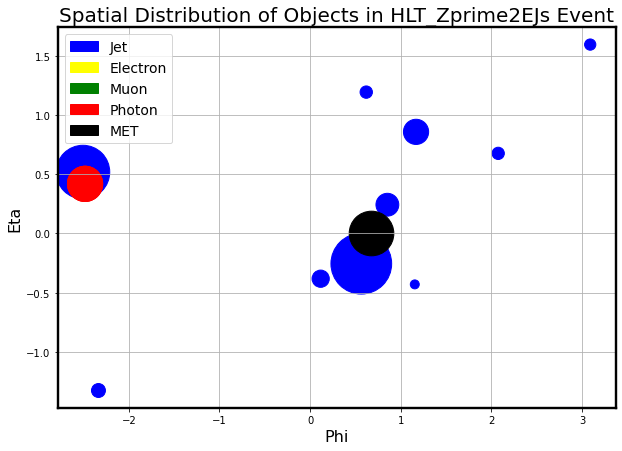

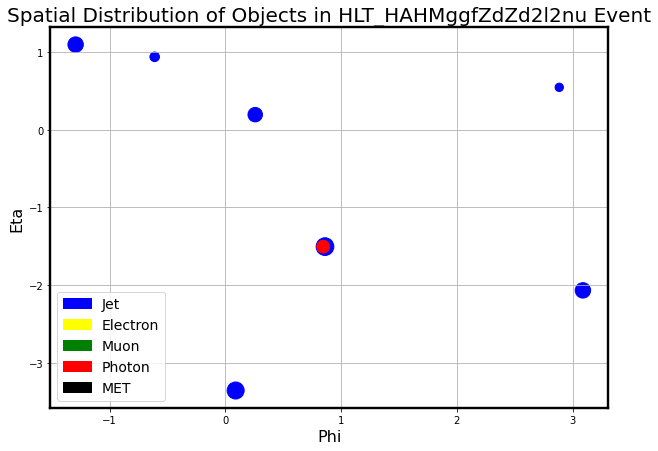

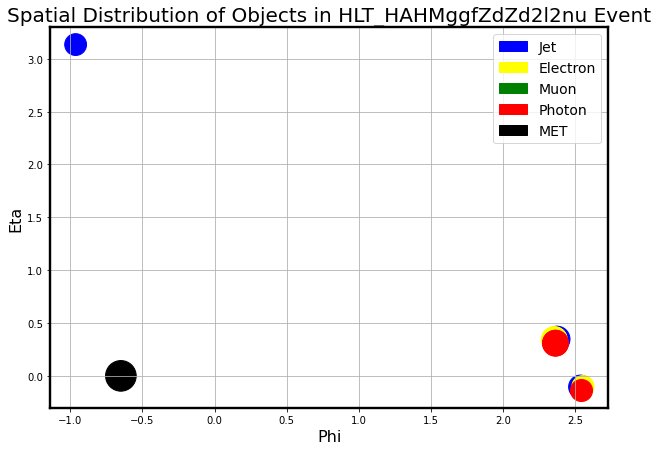

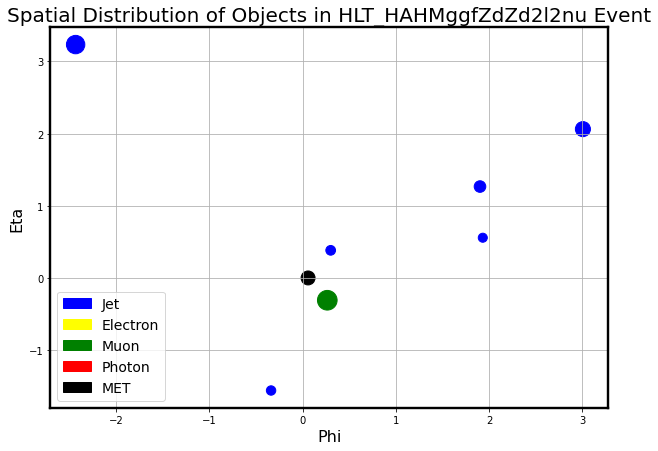

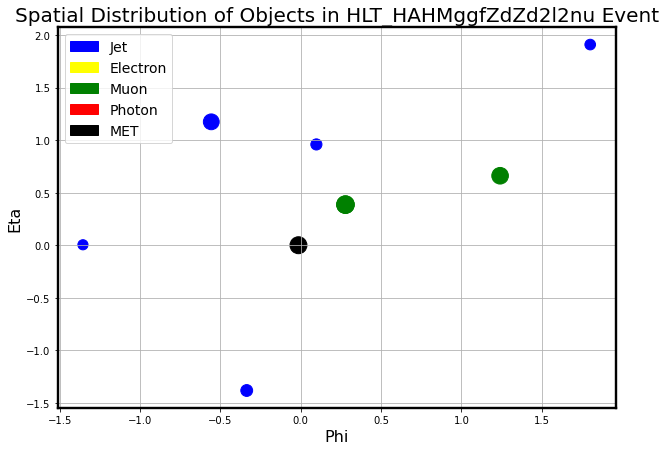

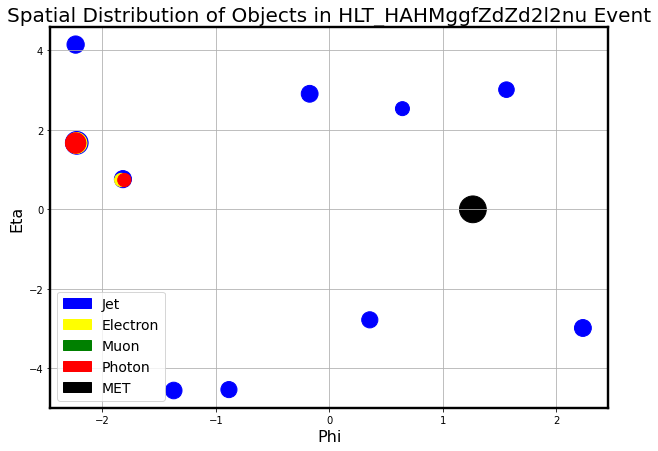

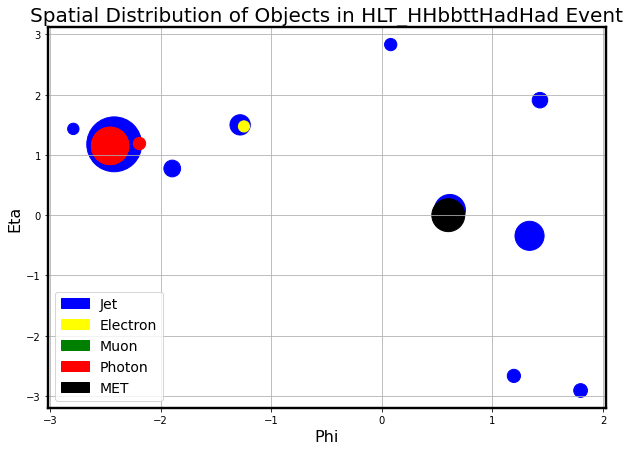

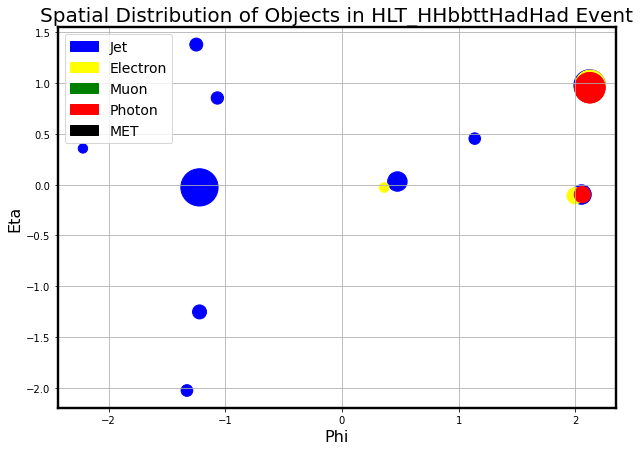

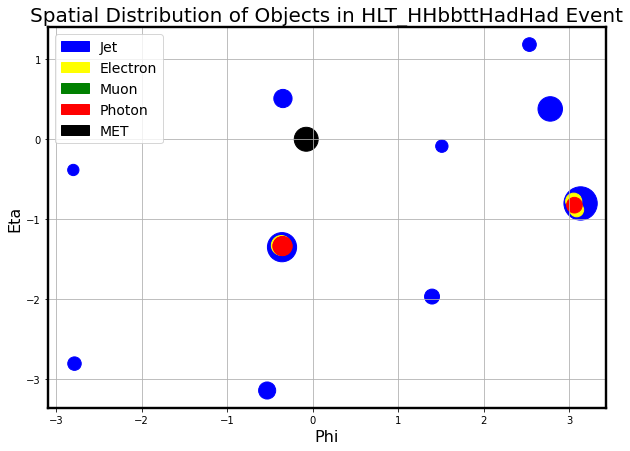

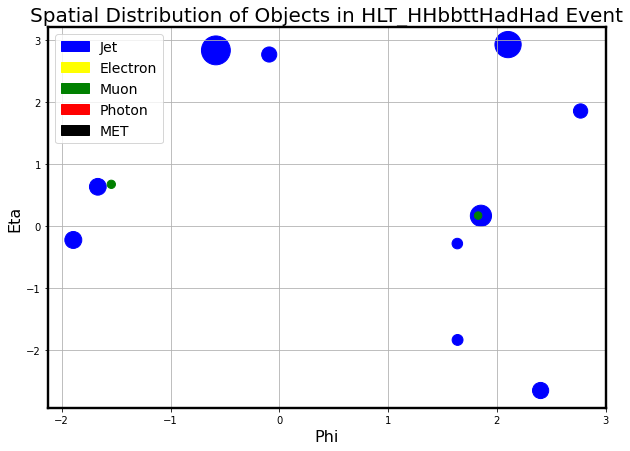

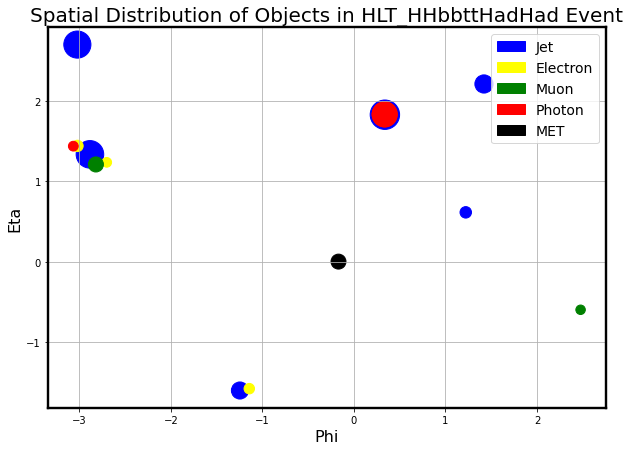

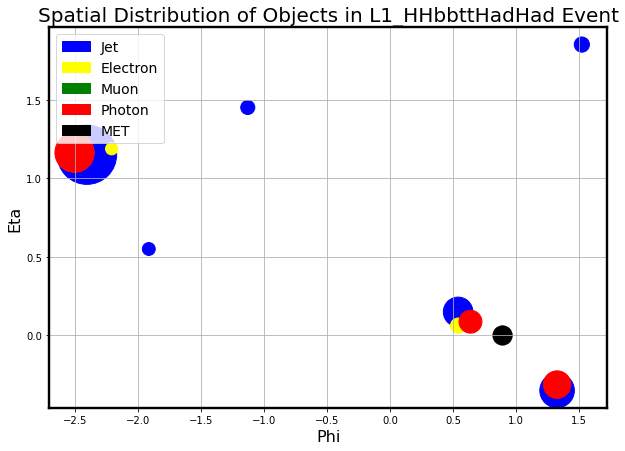

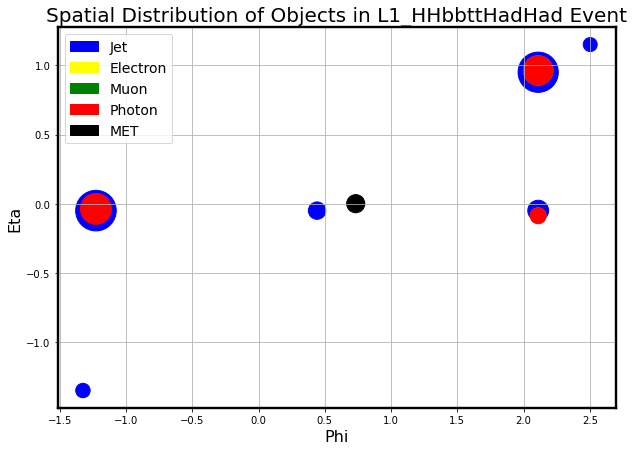

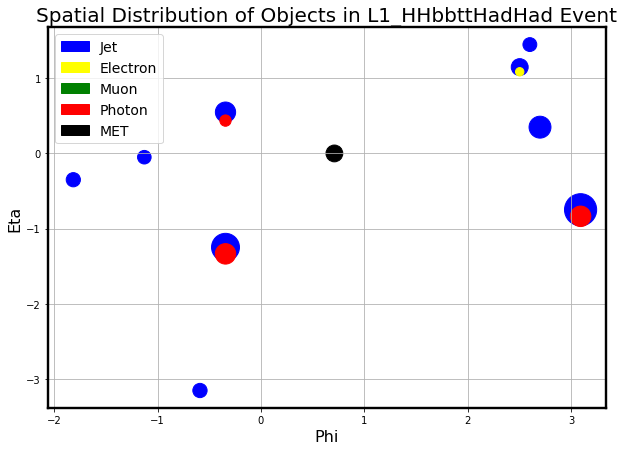

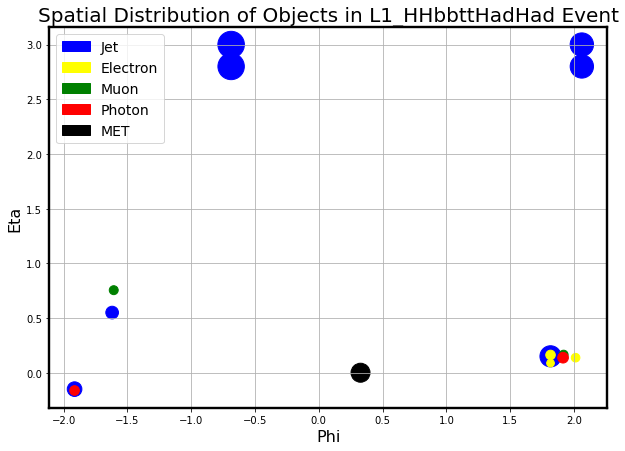

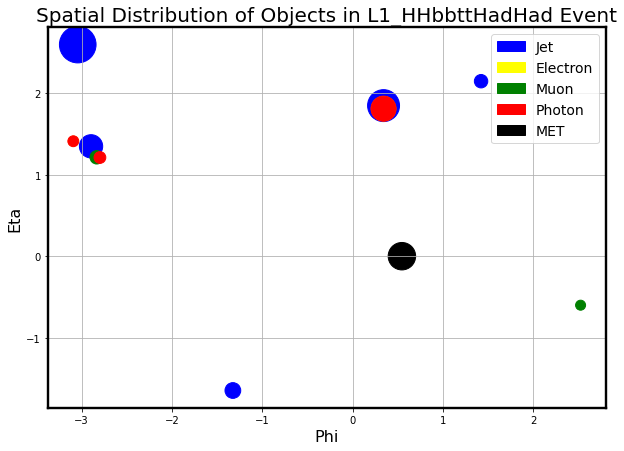

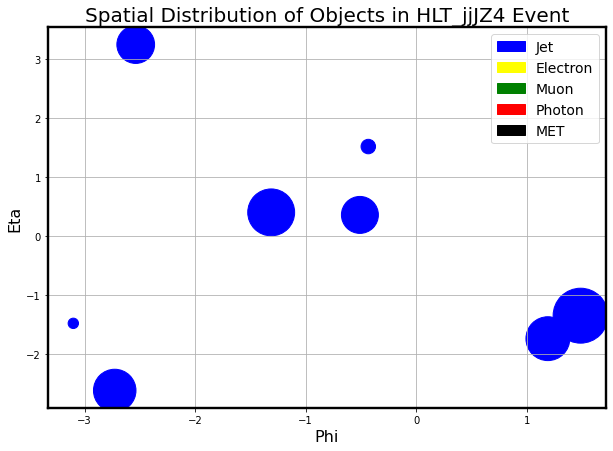

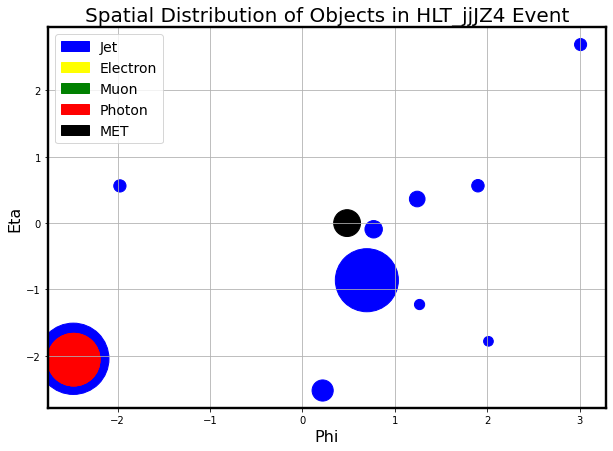

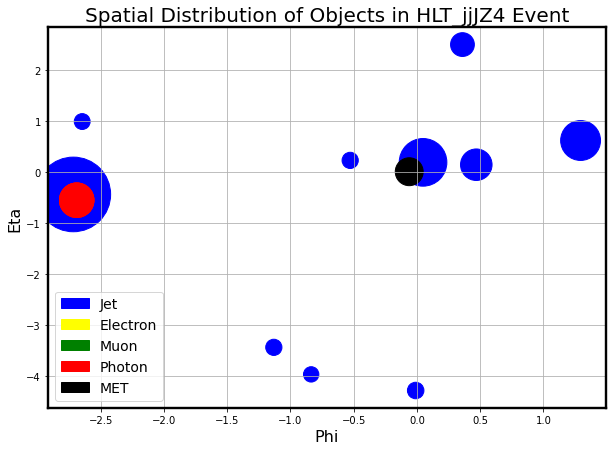

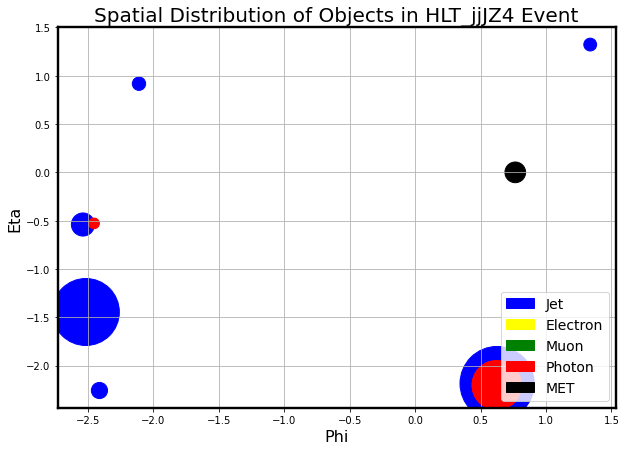

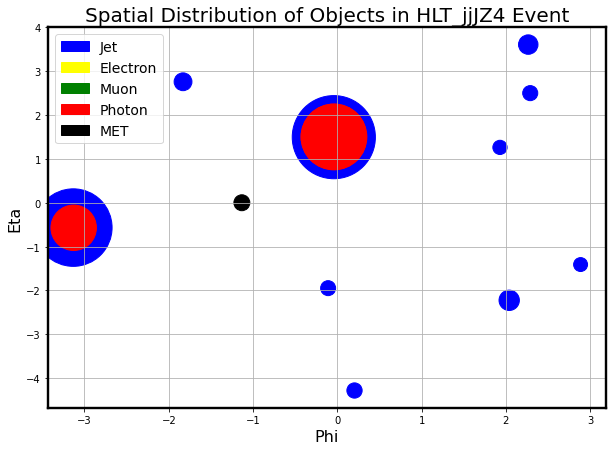

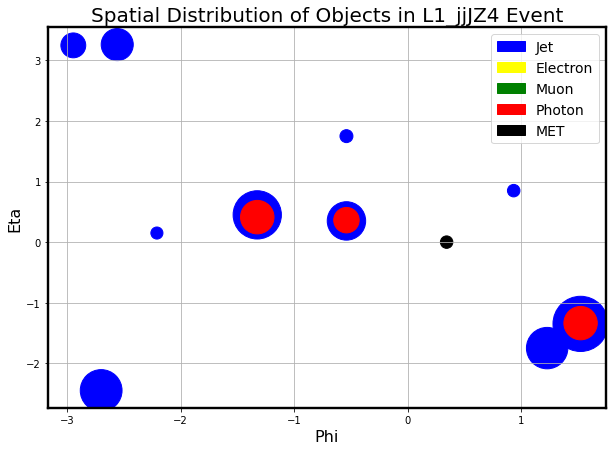

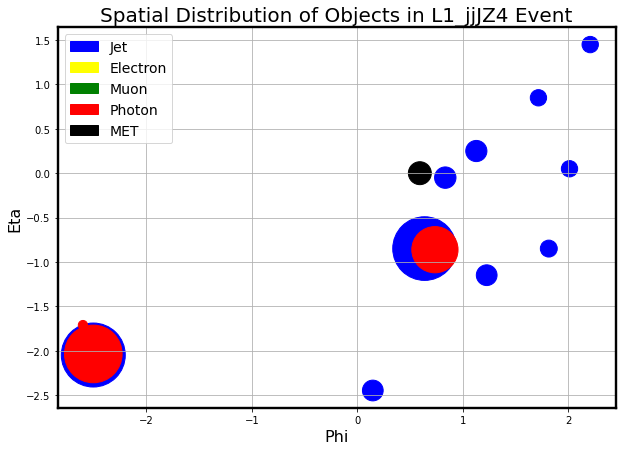

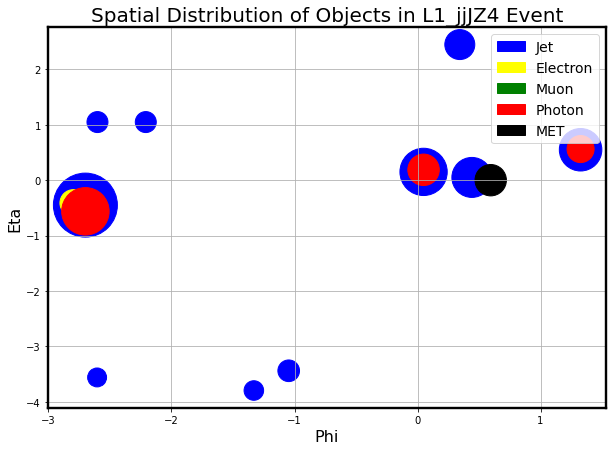

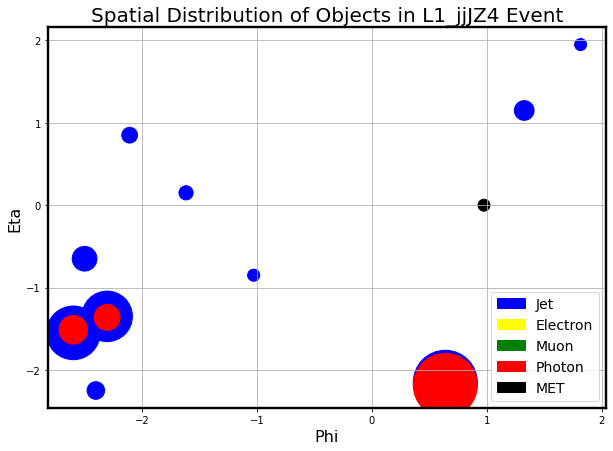

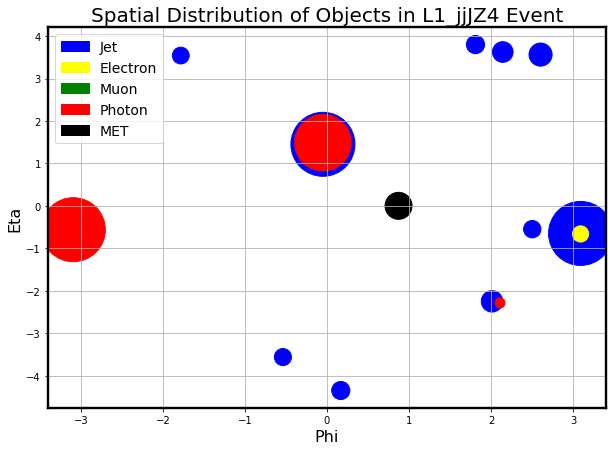

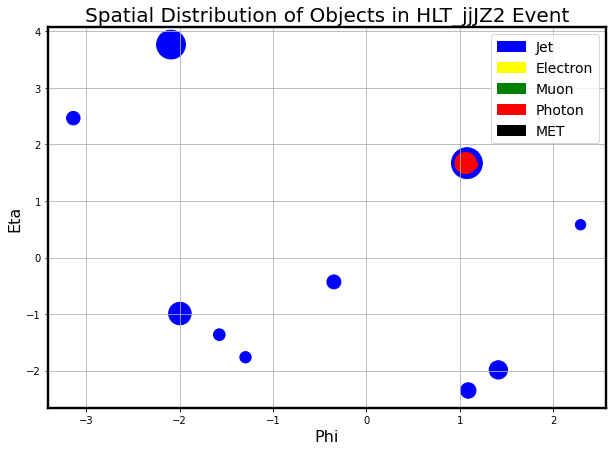

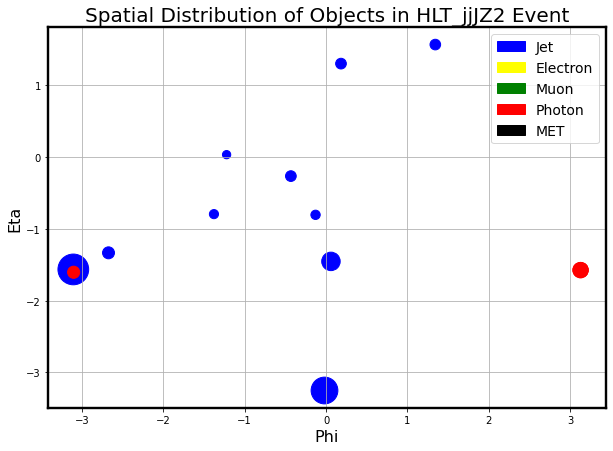

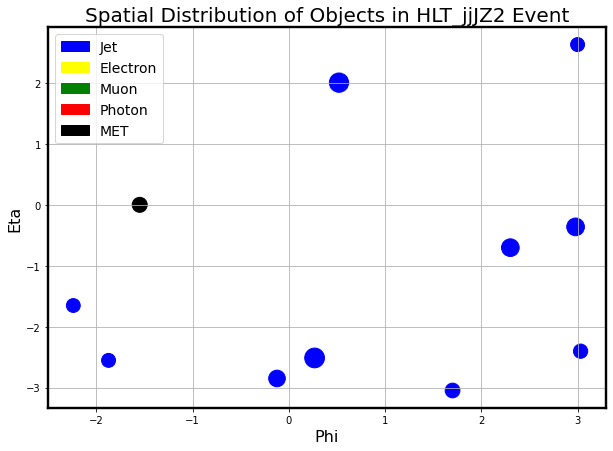

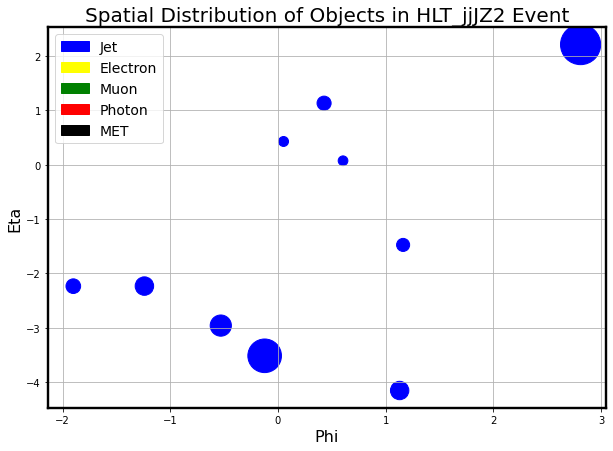

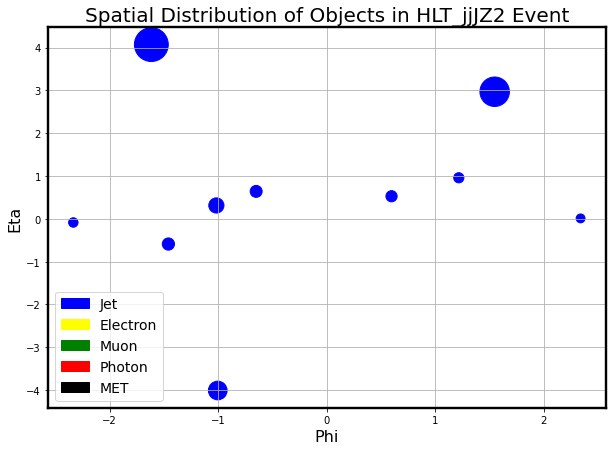

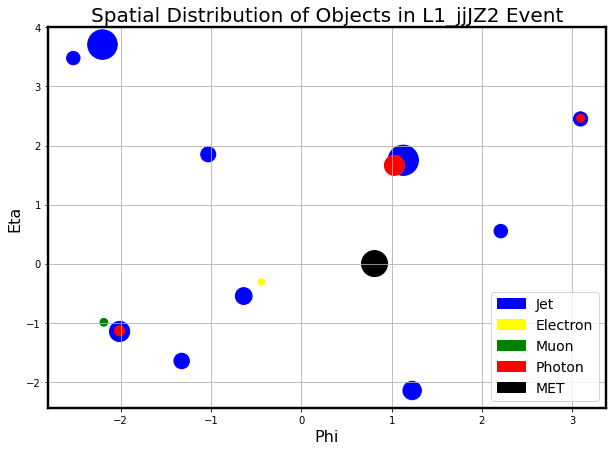

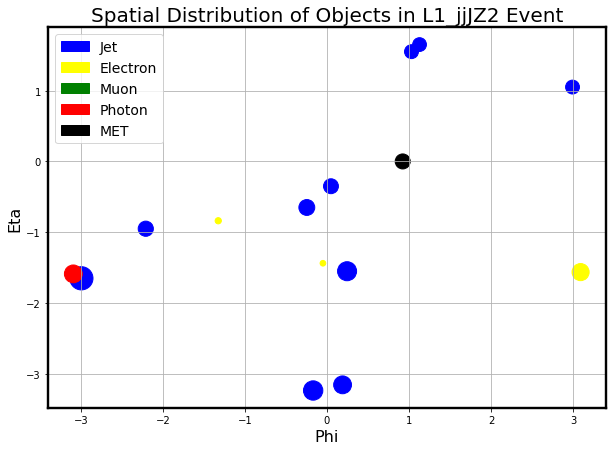

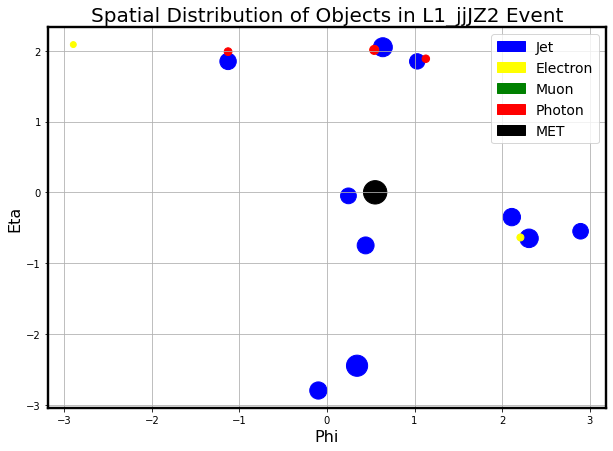

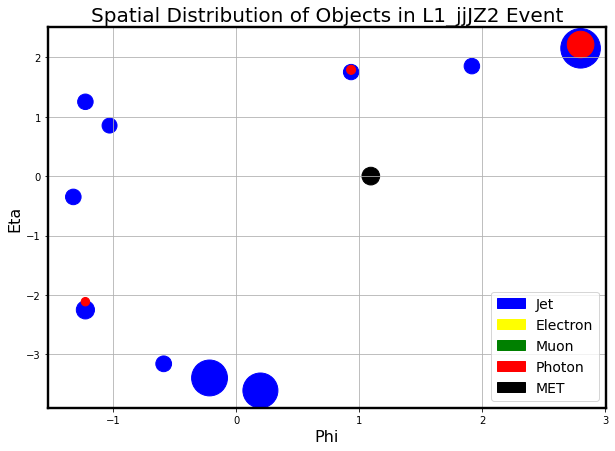

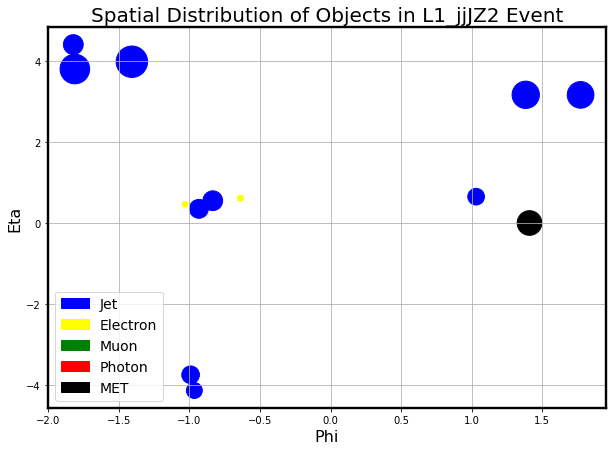

In [18]:
for tag, data in datasets.items():
    for i in range(5):
        plot_event(data[i], tag)

Event 0:


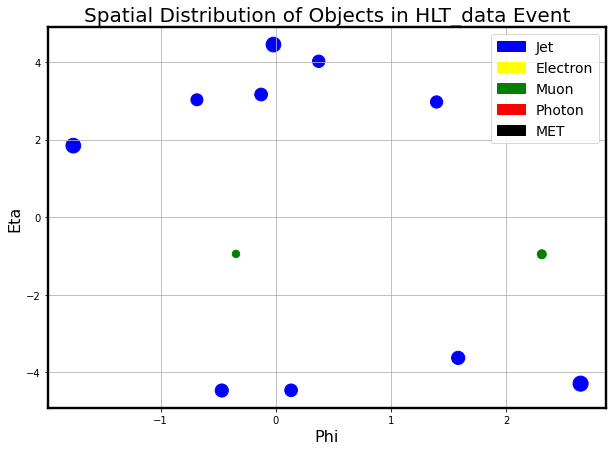

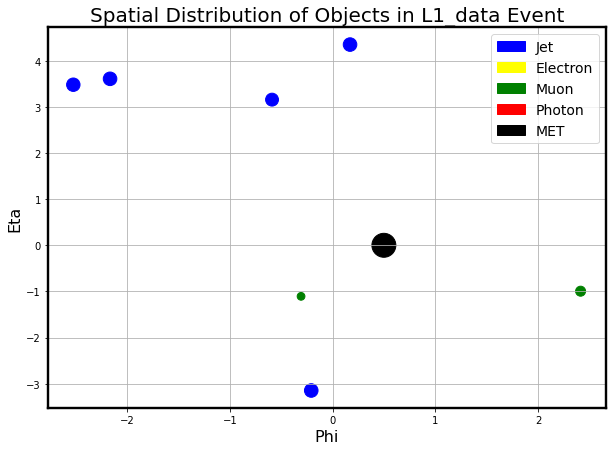





Event 1:


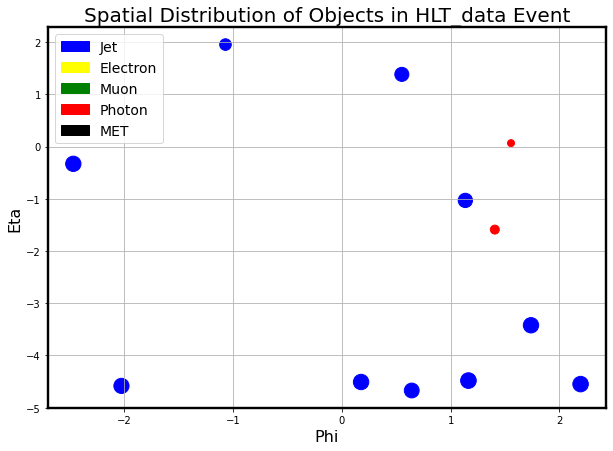

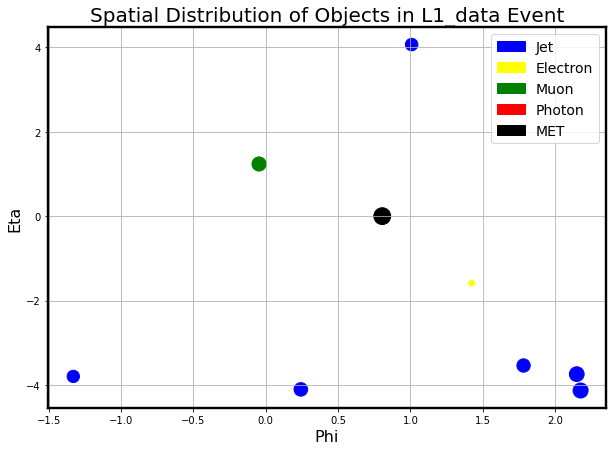





Event 2:


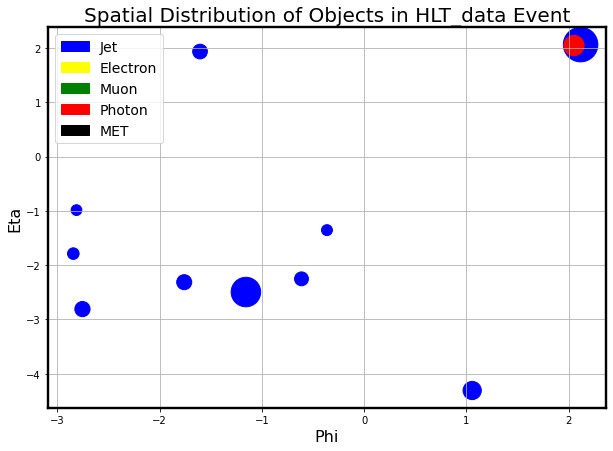

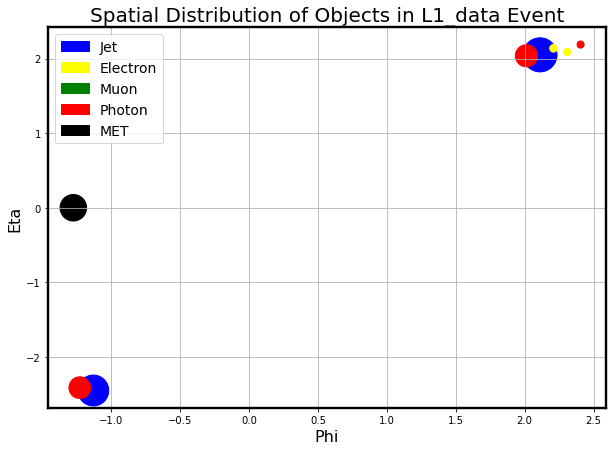





Event 3:


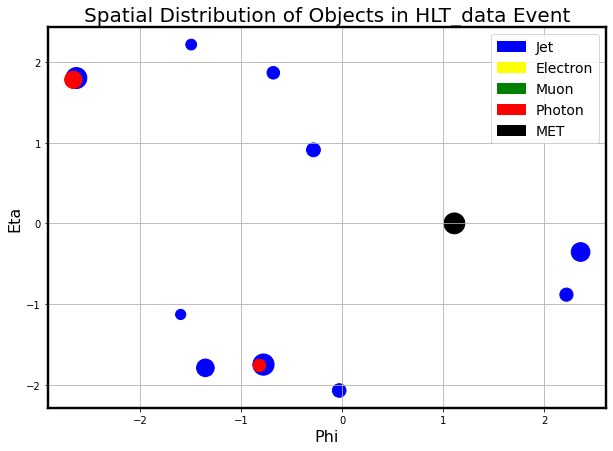

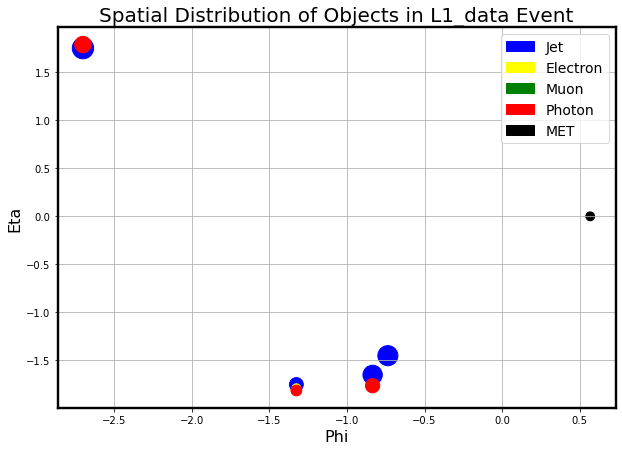





Event 4:


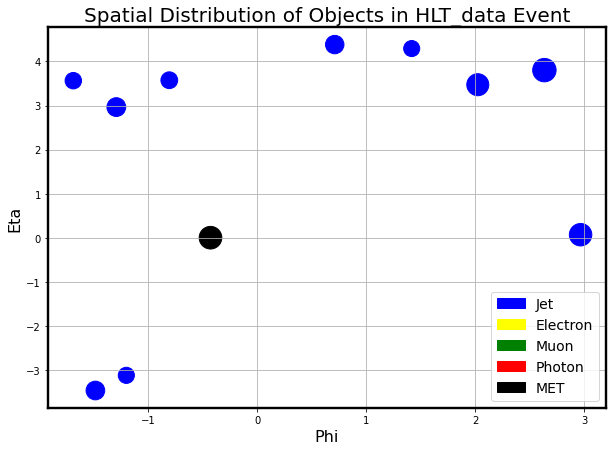

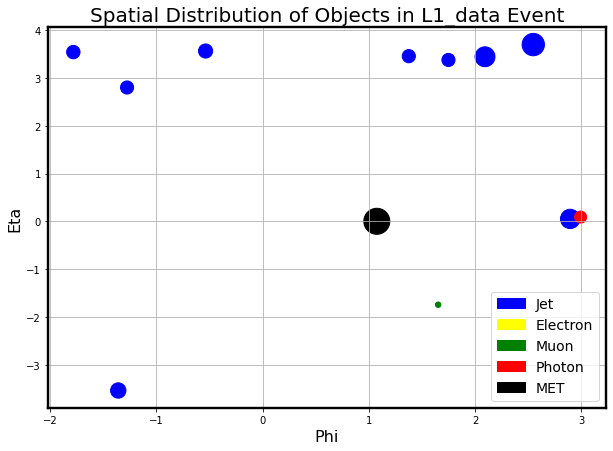

In [19]:
for i in range(5):
    print(f'Event {i}:')
    plot_event(datasets['HLT_data'][i], 'HLT_data')
    plot_event(datasets['L1_data'][i], 'L1_data')
    print('\n\n\n')

## Final preprocessing of data

In [10]:
"""Normalize pt """
for tag, data in datasets.items():
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= (sum_pt)

In [11]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [12]:
# Flatten ndarrays for use in DNN

for tag, data in datasets.items():
    datasets[tag] = np.reshape(data, newshape=(-1, 60))

for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 60)
L1_data: (219467, 60)
HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)


In [13]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

# HLT_tags = ['train', 'val', 'test_bkg', 'test2', 'zerobias', 'Ztautau', 'HHbbttHadHad', 'ZZ4lep', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']
# HLT_datasets = []
# HLT_weights = []

# L1_tags = ['train', 'val', 'test_bkg', 'test2', 'passed_HLT', 'passed_L1', 'passed_only_L1']
# L1_datasets = []
# L1_weights = []

random_seed = 0 # random seed for replication between notebooks

# HLT -----------------------------------
# Split indices
indices = np.arange(len(datasets['HLT_data']))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
datasets['HLT_train'] = datasets['HLT_data'][train_indices]
weights['HLT_train'] = weights['HLT_data'][train_indices]
datasets['L1_train'] = datasets['L1_data'][train_indices]
weights['L1_train'] = weights['L1_data'][train_indices]
pass_HLT['HLT_train'] = pass_HLT['HLT_data'][train_indices]
pass_HLT['L1_train'] = pass_HLT['L1_data'][train_indices]

# Val splits
datasets['HLT_val'] = datasets['HLT_data'][val_indices]
weights['HLT_val'] = weights['HLT_data'][val_indices]
datasets['L1_val'] = datasets['L1_data'][val_indices]
weights['L1_val'] = weights['L1_data'][val_indices]
pass_HLT['HLT_val'] = pass_HLT['HLT_data'][val_indices]
pass_HLT['L1_val'] = pass_HLT['L1_data'][val_indices]

# Test 1 splits
datasets['HLT_test1'] = datasets['HLT_data'][test_1_indices]
weights['HLT_test1'] = weights['HLT_data'][test_1_indices]
datasets['L1_test1'] = datasets['L1_data'][test_1_indices]
weights['L1_test1'] = weights['L1_data'][test_1_indices]
pass_HLT['HLT_test1'] = pass_HLT['HLT_data'][test_1_indices]
pass_HLT['L1_test1'] = pass_HLT['L1_data'][test_1_indices]

# Test_2 splits
datasets['HLT_test2'] = datasets['HLT_data'][test_2_indices]
weights['HLT_test2'] = weights['HLT_data'][test_2_indices]
datasets['L1_test2'] = datasets['L1_data'][test_2_indices]
weights['L1_test2'] = weights['L1_data'][test_2_indices]
pass_HLT['HLT_test2'] = pass_HLT['HLT_data'][test_2_indices]
pass_HLT['L1_test2'] = pass_HLT['L1_data'][test_2_indices]

# Remove old pre-split dataset
datasets.pop('HLT_data')
datasets.pop('L1_data')
weights.pop('HLT_data')
weights.pop('L1_data')
pass_HLT.pop('HLT_data')
pass_HLT.pop('L1_data')

# Printing
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)
HLT_train: (109733, 60)
L1_train: (109733, 60)
HLT_val: (21946, 60)
L1_val: (21946, 60)
HLT_test1: (43894, 60)
L1_test1: (43894, 60)
HLT_test2: (43894, 60)
L1_test2: (43894, 60)


## Network Infrastructure

In [14]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)

    return ae, encoder, decoder

In [15]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [16]:
# Define parameters
INPUT_DIM = datasets['HLT_train'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3
STOP_PATIENCE = 8
LR_PATIENCE = 4
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [ ]:
# Train multiple models
for i in range(21, 100):
    if i == 0: print('Starting!')

    # Initialize models
    HLT_AE, HLT_encoder, HLT_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
    L1_AE, L1_encoder, L1_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
    HLT_AE.compile(optimizer='adam', loss=loss_fn)
    L1_AE.compile(optimizer='adam', loss=loss_fn)

    # Initialize callbacks
    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=0, min_lr=1e-6)
    callbacks = [early_stopping, reduce_lr]
    
    # train HLT model
    print(f'Starting training of HLT model {i}!')
    history_HLT = HLT_AE.fit(x=datasets['HLT_train'], y=datasets['HLT_train'], validation_data=(datasets['HLT_val'], datasets['HLT_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['HLT_train'], verbose=0)
    HLT_AE.save_weights(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras')
    HLT_encoder.save_weights(f'./trained_models/ensemble_5-13-2024/HLT_encoder_{i}.keras')
    HLT_decoder.save_weights(f'./trained_models/ensemble_5-13-2024/HLT_decoder_{i}.keras')
    print(f'Finished training of HLT model {i}!')
    
    
    # train L1 model
    print(f'Starting training of L1 model {i}!')
    history_L1 = L1_AE.fit(x=datasets['L1_train'], y=datasets['L1_train'], validation_data=(datasets['L1_val'], datasets['L1_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['L1_train'], verbose=0)
    L1_AE.save_weights(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras')
    L1_encoder.save_weights(f'./trained_models/ensemble_5-13-2024/L1_encoder_{i}.keras')
    L1_decoder.save_weights(f'./trained_models/ensemble_5-13-2024/L1_decoder_{i}.keras')
    print(f'Finished training of L1 model {i}!')

2024-05-20 21:19:00.644872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 21:19:00.675330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 21:19:00.675719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Starting training of HLT model 21!


2024-05-20 21:19:02.801247: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f085d768cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-20 21:19:02.801314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-20 21:19:02.807893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-20 21:19:02.832237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-20 21:19:02.992129: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Finished training of HLT model 21!
Starting training of L1 model 21!
Finished training of L1 model 21!
Starting training of HLT model 22!
Finished training of HLT model 22!
Starting training of L1 model 22!
Finished training of L1 model 22!
Starting training of HLT model 23!
Finished training of HLT model 23!
Starting training of L1 model 23!
Finished training of L1 model 23!
Starting training of HLT model 24!
Finished training of HLT model 24!
Starting training of L1 model 24!
Finished training of L1 model 24!
Starting training of HLT model 25!
Finished training of HLT model 25!
Starting training of L1 model 25!
Finished training of L1 model 25!
Starting training of HLT model 26!
Finished training of HLT model 26!
Starting training of L1 model 26!
Finished training of L1 model 26!
Starting training of HLT model 27!
Finished training of HLT model 27!
Starting training of L1 model 27!
Finished training of L1 model 27!
Starting training of HLT model 28!
Finished training of HLT model 28!

## Evaluate Models

In [17]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [18]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [29]:
def load_models(path):
    AE, encoder, decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
    AE.compile(optimizer='adam', loss=loss_fn)
    AE.load_weights(path)
    return AE

In [20]:
def fit_normalizers(models, data):
    scalers = []
    quantile_transformers = []
    for model in models:
        model_output = model.predict(data, verbose=0)
        model_AD_score = AD_score(data, model_output)
        
        # Fit StandardScaler
        scaler = StandardScaler()
        scaler.fit(model_AD_score.reshape(-1, 1))
        scalers.append(scaler)
        
        # Fit QuantileTransformer
        qt = QuantileTransformer(output_distribution='normal')
        qt.fit(model_AD_score.reshape(-1, 1))
        quantile_transformers.append(qt)
    
    return scalers, quantile_transformers

In [21]:
def normalize_scores(scores, scaler, qt):
    zscore_normalized = scaler.transform(scores.reshape(-1, 1)).flatten()
    quantile_normalized = qt.transform(scores.reshape(-1, 1)).flatten()
    return zscore_normalized, quantile_normalized

In [22]:
def ensemble_AD_scores(models, data, scalers, quantile_transformers):
    raw_scores = []
    zscore_normalized_scores = []
    quantile_normalized_scores = []

    for model, scaler, qt in zip(models, scalers, quantile_transformers):
        model_output = model.predict(data, verbose=0)
        model_AD_score = AD_score(data, model_output)

        raw_scores.append(model_AD_score)
        zscore_normalized, quantile_normalized = normalize_scores(model_AD_score, scaler, qt)
        zscore_normalized_scores.append(zscore_normalized)
        quantile_normalized_scores.append(quantile_normalized)
    
    avg_raw_scores = np.mean(raw_scores, axis=0)
    avg_zscore_normalized_scores = np.mean(zscore_normalized_scores, axis=0)
    avg_quantile_normalized_scores = np.mean(quantile_normalized_scores, axis=0)

    return avg_raw_scores, avg_zscore_normalized_scores, avg_quantile_normalized_scores

In [23]:
def ROC_curve(AD_scores_dict, weights_dict, bkg_tag, plot=True):
    """
    Plots ROC curve and returns AUC and FPRs for each dataset.
    
    inputs: 
    AD_scores: dictionary {datset_names: AD_scores}
    weights_dict: dictionary {dataset_names: sample weights}
    bkg_tag: the name of the dataset that correspondds to the background.
    
    returns:
    TPRs: dictionary {dataset_names: TPR at FPR=10e-4}
    AUCs: dictionary {dataset_names: AUC}
    """
    
    bkg_type = bkg_tag.split('_')[0] # HLT or L1
    target_fpr = 10**-4
    plt.figure(figsize=(8.5,6.8))
    
    TPRs = {}
    AUCs = {}
    
    for tag in AD_scores_dict.keys():
        if tag.startswith(bkg_type) and tag != bkg_tag:
        
            # Combine true labels, anomaly=1 and background=0
            trueVal = np.concatenate((np.ones(AD_scores_dict[tag].shape[0]), np.zeros(AD_scores_dict[bkg_tag].shape[0])))
            
            # Combine predictions from current dataset and background
            predVal_loss = np.concatenate((AD_scores_dict[tag], AD_scores_dict[bkg_tag]))
        
            sample_weights = np.concatenate((weights_dict[tag], weights_dict[bkg_tag]))
        
            # Calculate ROC curve and AUC, including weights
            fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss, tpr_loss)

            # Append to dictionaries
            idx = np.argmin(np.abs(fpr_loss - target_fpr))
            TPRs[tag] = tpr_loss[idx]
        
            # Plot ROC curve
            if plot:
                plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
        

            

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'trained over {bkg_type} objects', fontsize=20)
        
        # Additional plot elements
        
        #plt.title("ROC Curve", fontsize)
        plt.show()

    return TPRs, AUCs

Starting batch 0!
starting batch 0 ensembling of HLT_ZZ4lep data!
starting batch 0 ensembling of HLT_HHbbttHadHad data!
starting batch 0 ensembling of HLT_jjJZ2 data!
starting batch 0 ensembling of HLT_test1 data!
starting batch 0 ensembling of HLT_test2 data!
starting batch 0 ensembling of L1_HHbbttHadHad data!
starting batch 0 ensembling of L1_jjJZ2 data!
starting batch 0 ensembling of L1_test1 data!
starting batch 0 ensembling of L1_test2 data!


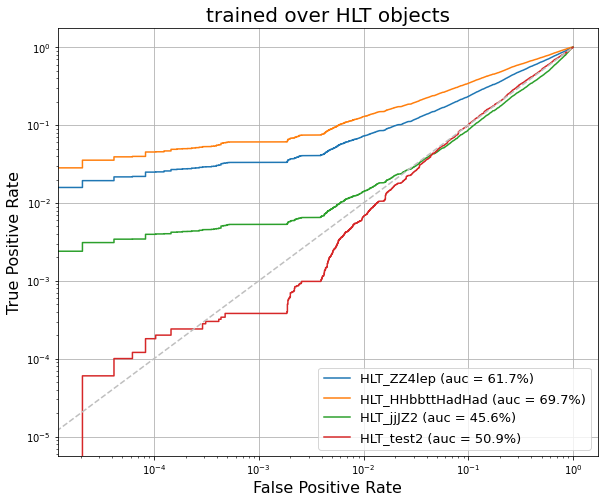

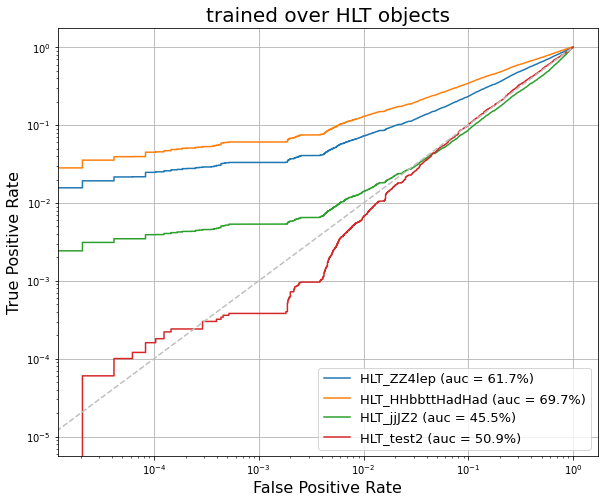

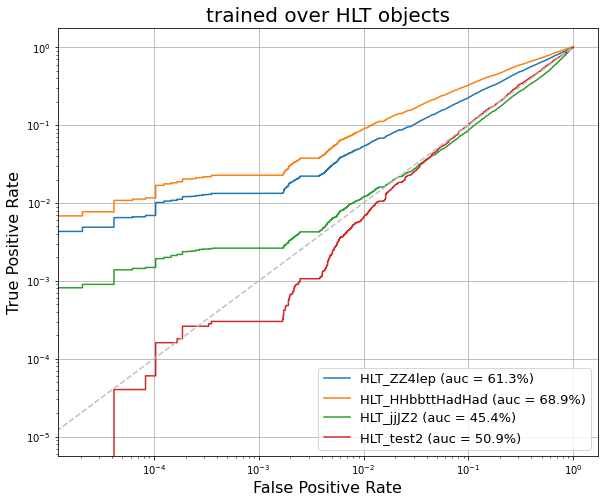

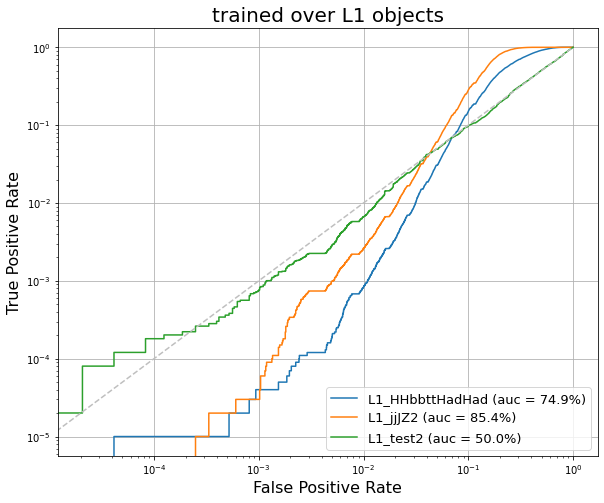

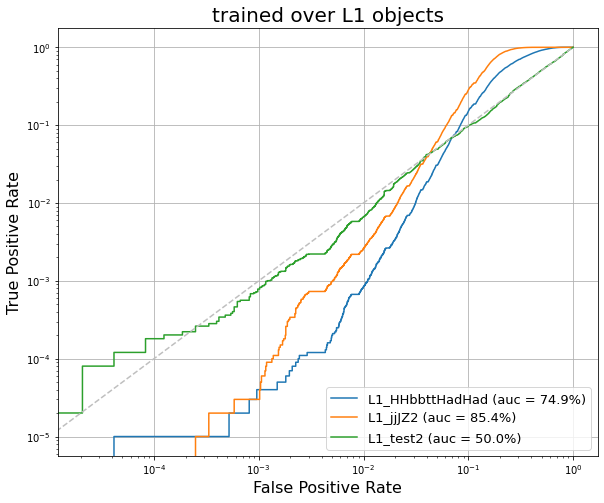

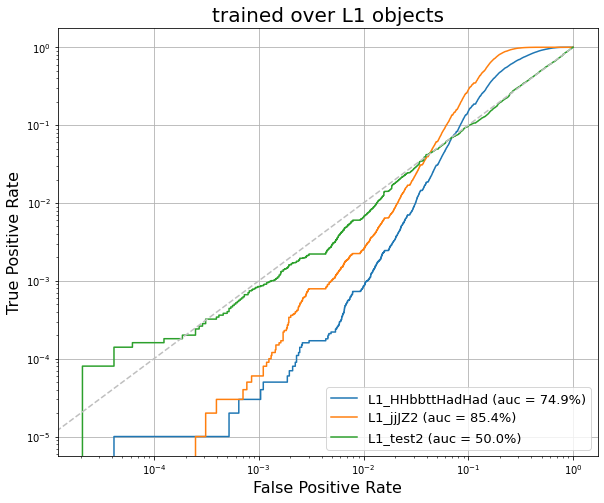


Starting batch 1!
starting batch 1 ensembling of HLT_ZZ4lep data!
starting batch 1 ensembling of HLT_HHbbttHadHad data!
starting batch 1 ensembling of HLT_jjJZ2 data!
starting batch 1 ensembling of HLT_test1 data!
starting batch 1 ensembling of HLT_test2 data!
starting batch 1 ensembling of L1_HHbbttHadHad data!
starting batch 1 ensembling of L1_jjJZ2 data!
starting batch 1 ensembling of L1_test1 data!
starting batch 1 ensembling of L1_test2 data!


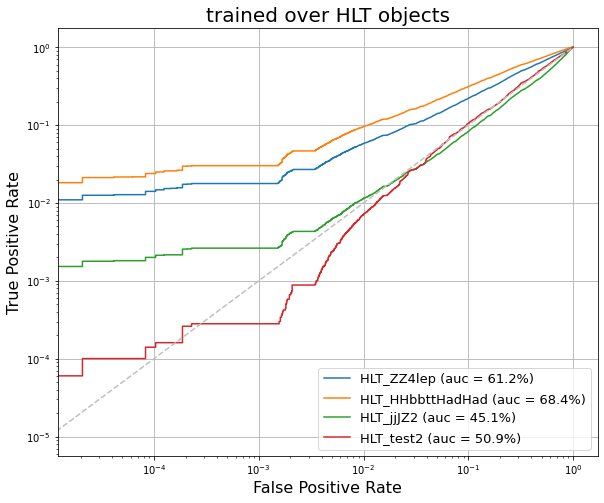

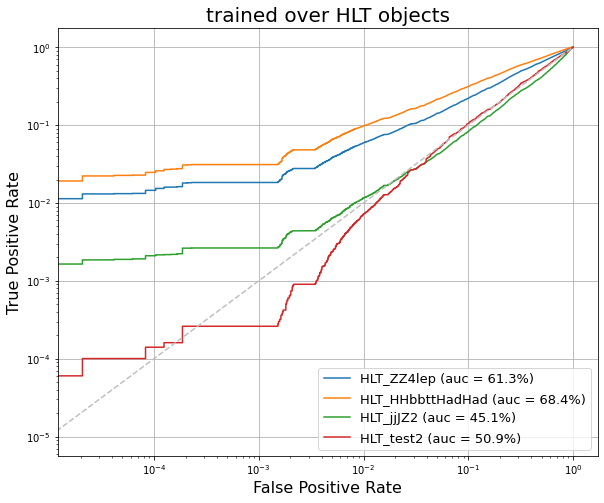

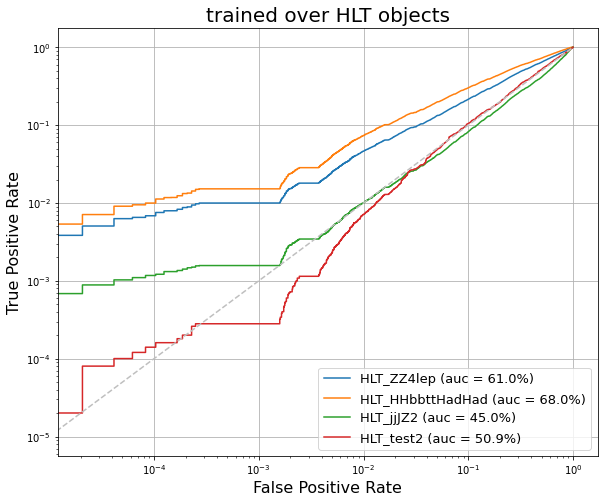

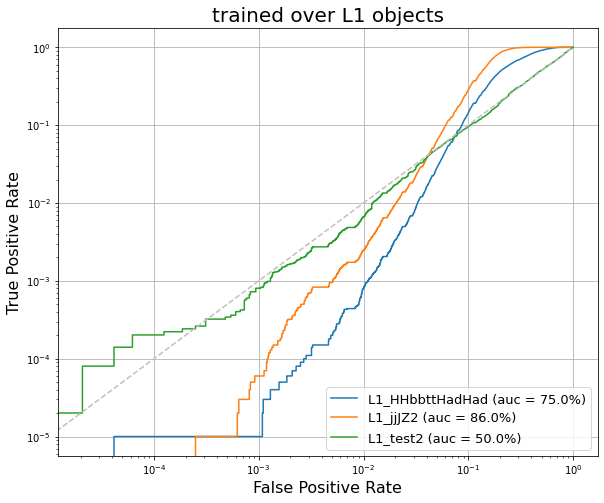

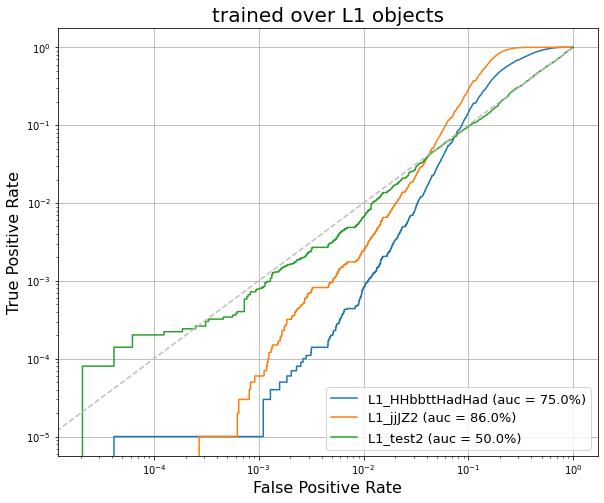

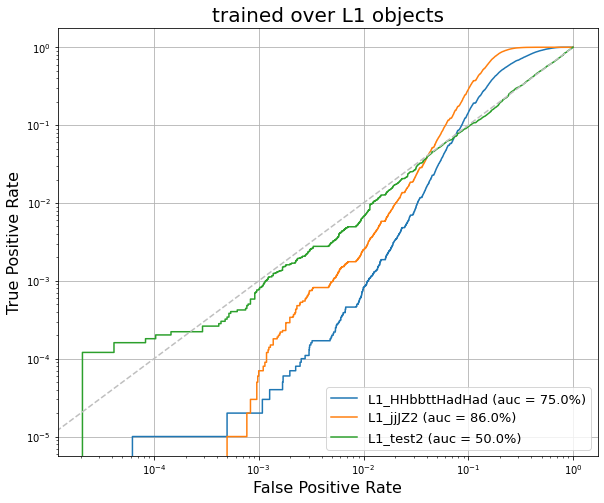


Starting batch 2!
starting batch 2 ensembling of HLT_ZZ4lep data!
starting batch 2 ensembling of HLT_HHbbttHadHad data!
starting batch 2 ensembling of HLT_jjJZ2 data!
starting batch 2 ensembling of HLT_test1 data!
starting batch 2 ensembling of HLT_test2 data!
starting batch 2 ensembling of L1_HHbbttHadHad data!
starting batch 2 ensembling of L1_jjJZ2 data!
starting batch 2 ensembling of L1_test1 data!
starting batch 2 ensembling of L1_test2 data!


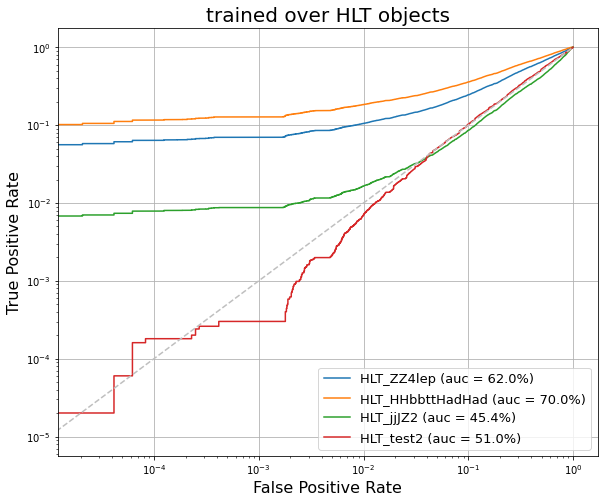

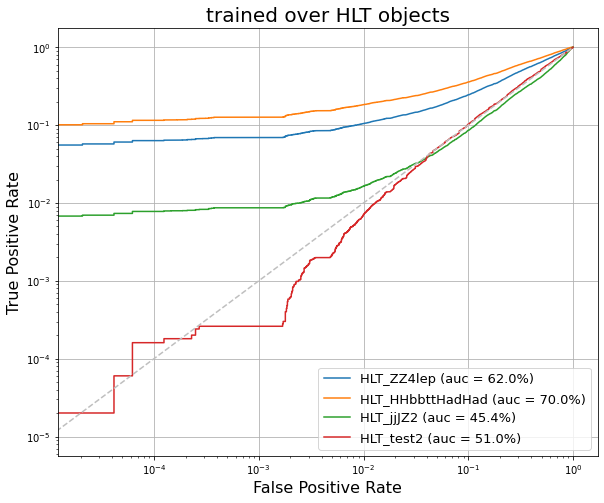

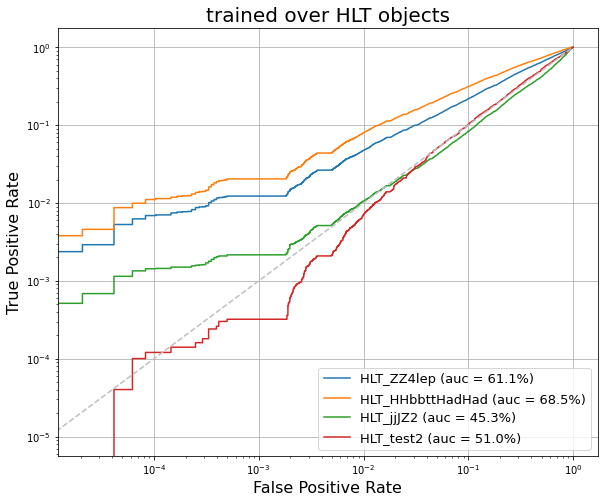

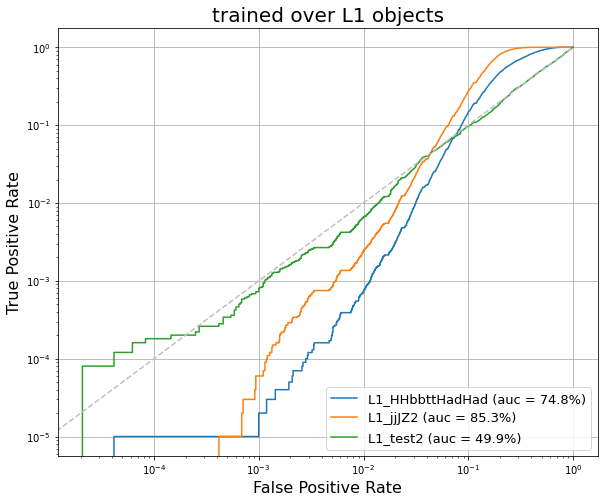

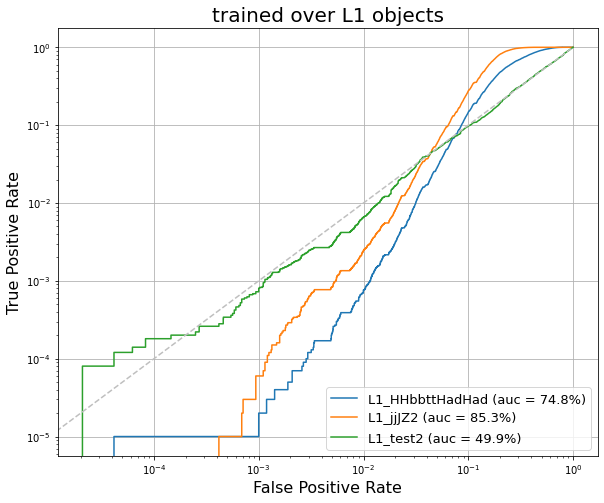

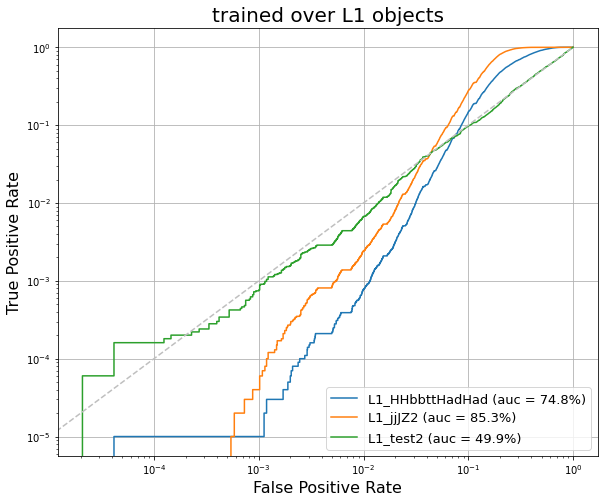


Starting batch 3!
starting batch 3 ensembling of HLT_ZZ4lep data!
starting batch 3 ensembling of HLT_HHbbttHadHad data!
starting batch 3 ensembling of HLT_jjJZ2 data!
starting batch 3 ensembling of HLT_test1 data!
starting batch 3 ensembling of HLT_test2 data!
starting batch 3 ensembling of L1_HHbbttHadHad data!
starting batch 3 ensembling of L1_jjJZ2 data!
starting batch 3 ensembling of L1_test1 data!
starting batch 3 ensembling of L1_test2 data!


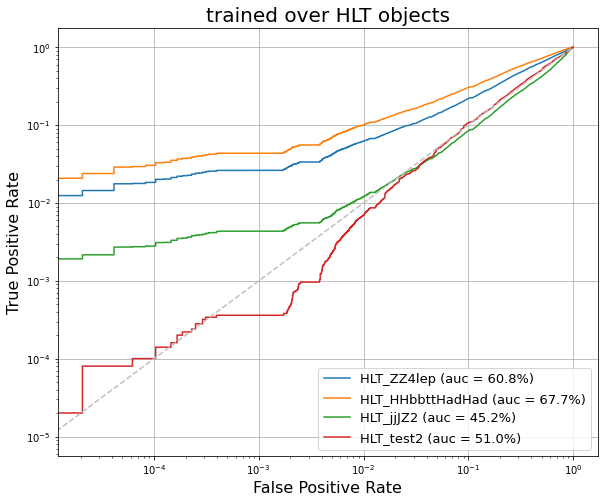

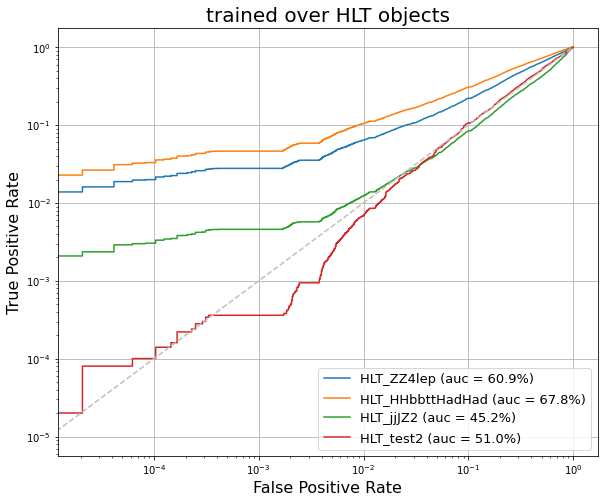

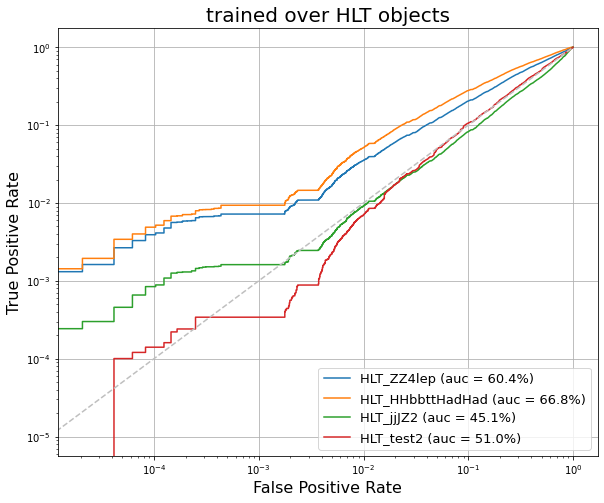

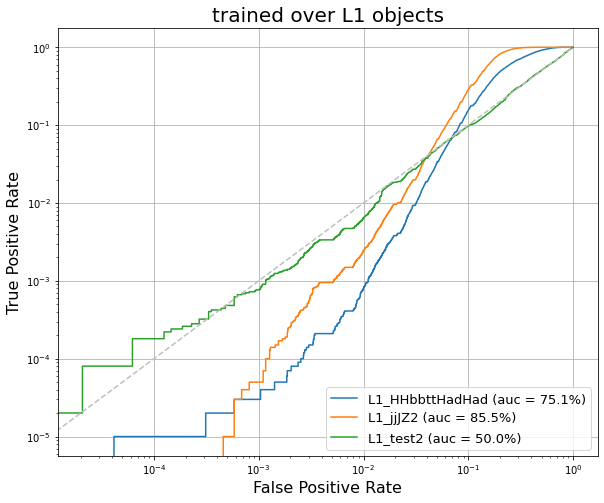

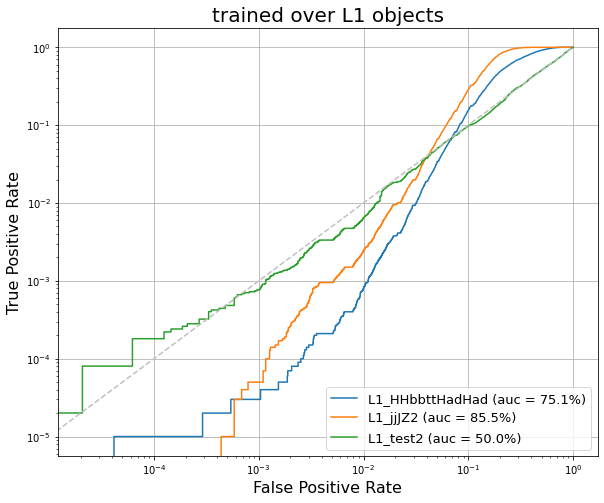

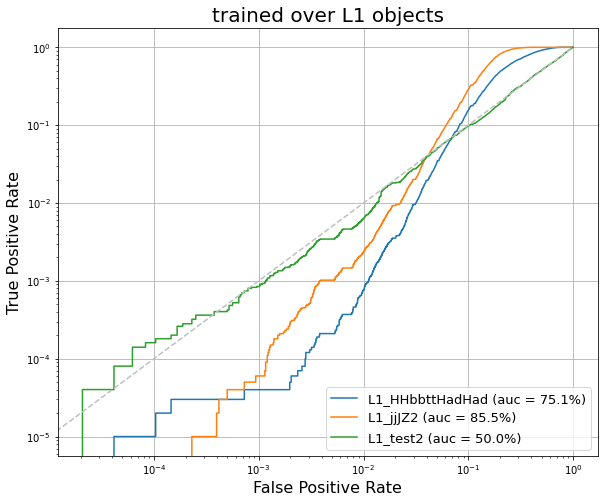


Starting batch 4!
starting batch 4 ensembling of HLT_ZZ4lep data!
starting batch 4 ensembling of HLT_HHbbttHadHad data!
starting batch 4 ensembling of HLT_jjJZ2 data!
starting batch 4 ensembling of HLT_test1 data!
starting batch 4 ensembling of HLT_test2 data!
starting batch 4 ensembling of L1_HHbbttHadHad data!
starting batch 4 ensembling of L1_jjJZ2 data!
starting batch 4 ensembling of L1_test1 data!
starting batch 4 ensembling of L1_test2 data!


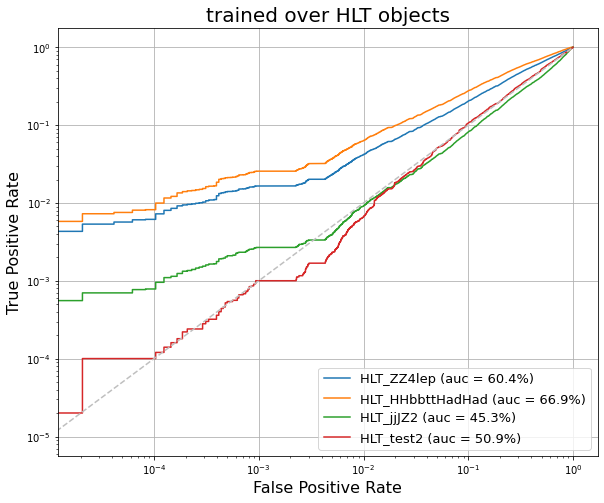

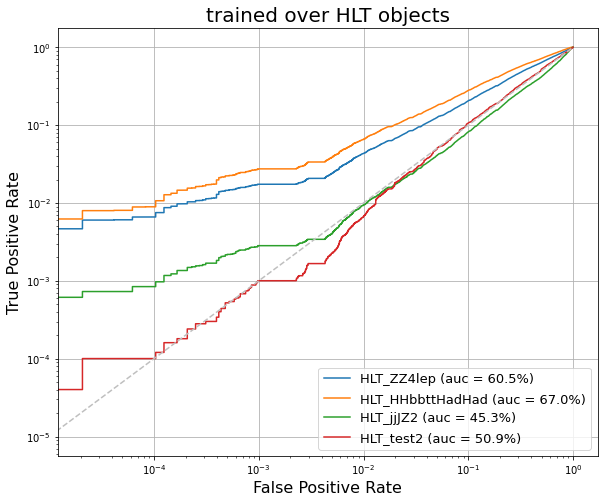

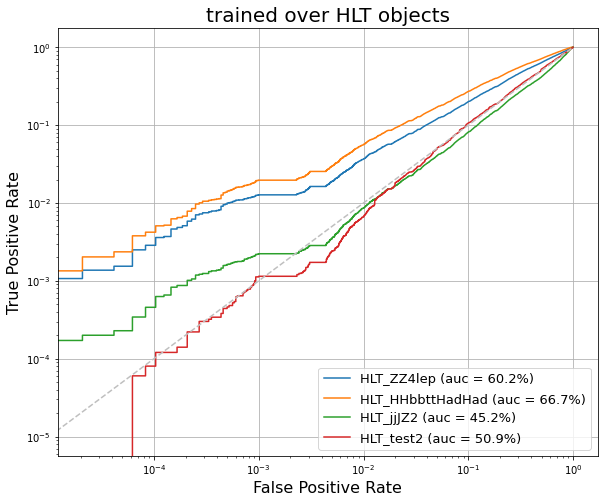

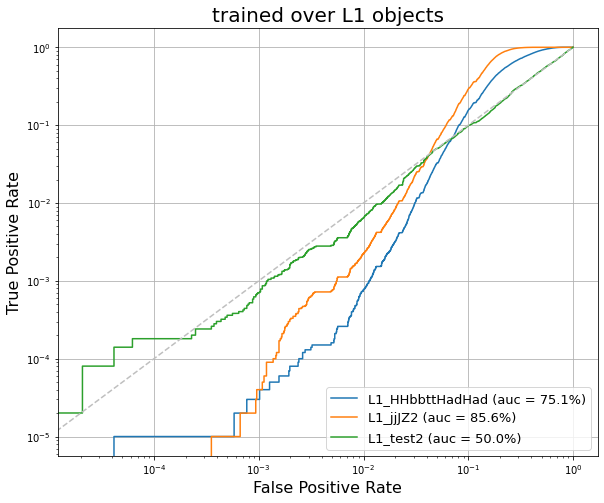

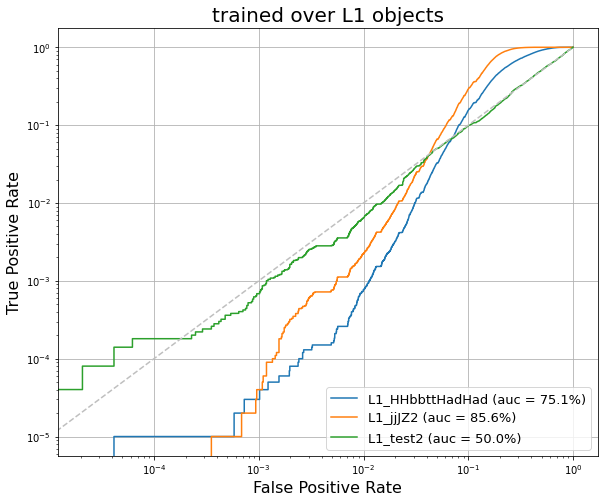

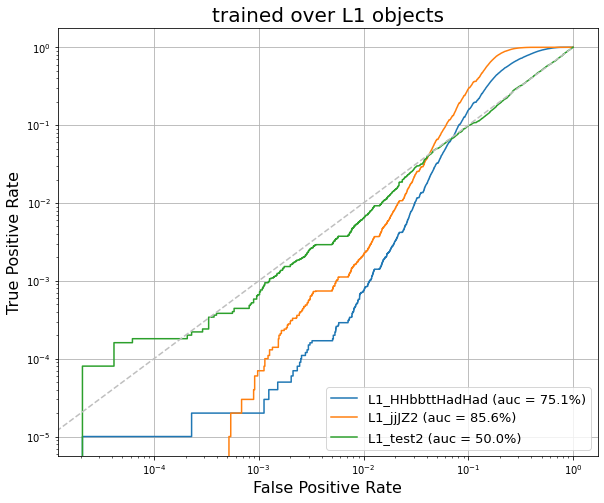


Starting batch 5!
starting batch 5 ensembling of HLT_ZZ4lep data!
starting batch 5 ensembling of HLT_HHbbttHadHad data!
starting batch 5 ensembling of HLT_jjJZ2 data!
starting batch 5 ensembling of HLT_test1 data!
starting batch 5 ensembling of HLT_test2 data!
starting batch 5 ensembling of L1_HHbbttHadHad data!
starting batch 5 ensembling of L1_jjJZ2 data!
starting batch 5 ensembling of L1_test1 data!
starting batch 5 ensembling of L1_test2 data!


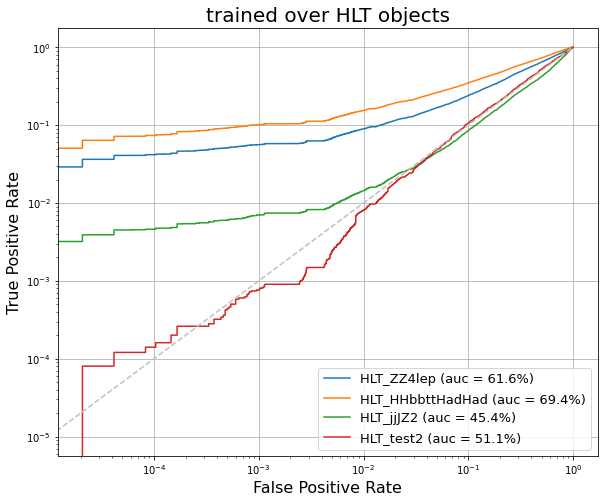

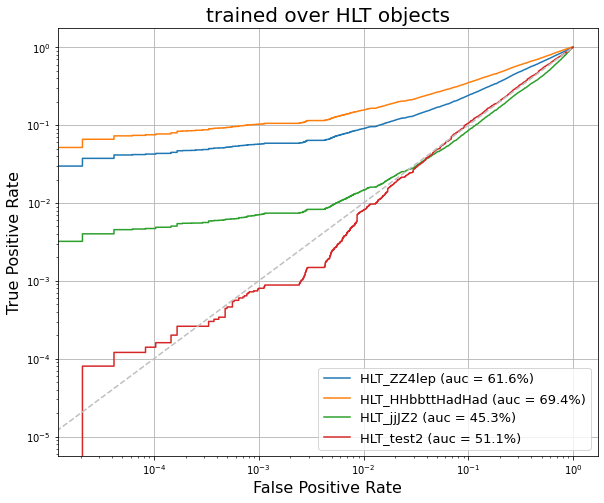

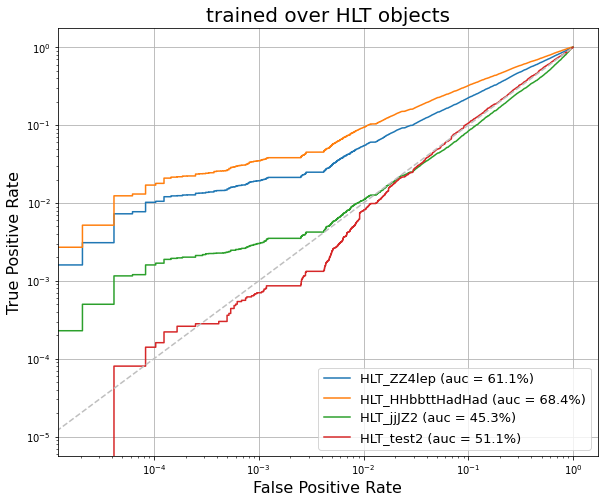

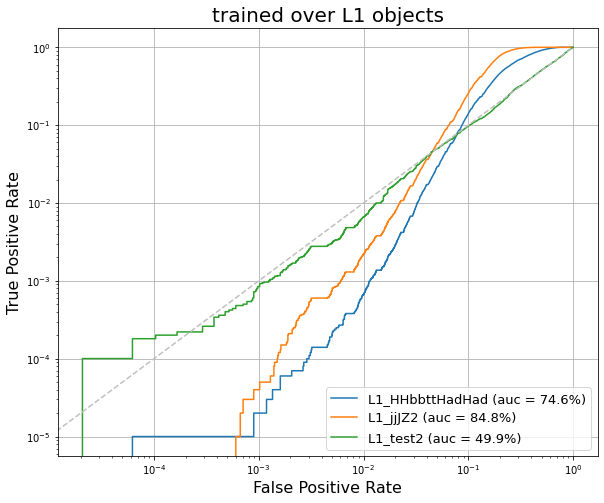

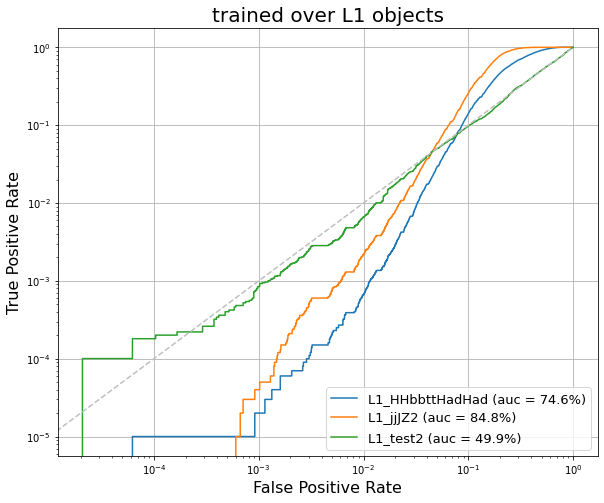

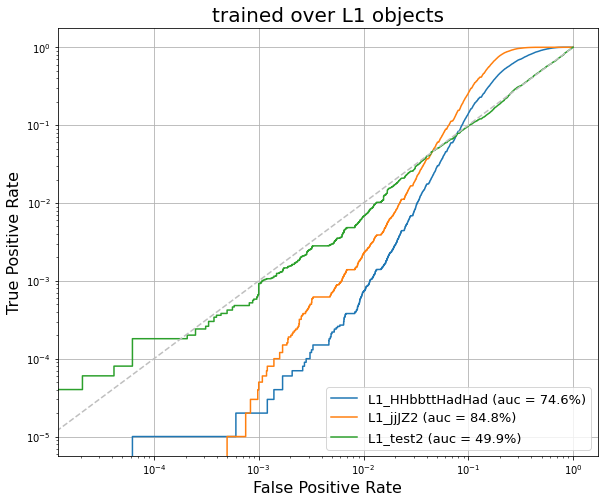


Starting batch 6!
starting batch 6 ensembling of HLT_ZZ4lep data!
starting batch 6 ensembling of HLT_HHbbttHadHad data!
starting batch 6 ensembling of HLT_jjJZ2 data!
starting batch 6 ensembling of HLT_test1 data!
starting batch 6 ensembling of HLT_test2 data!
starting batch 6 ensembling of L1_HHbbttHadHad data!
starting batch 6 ensembling of L1_jjJZ2 data!
starting batch 6 ensembling of L1_test1 data!
starting batch 6 ensembling of L1_test2 data!


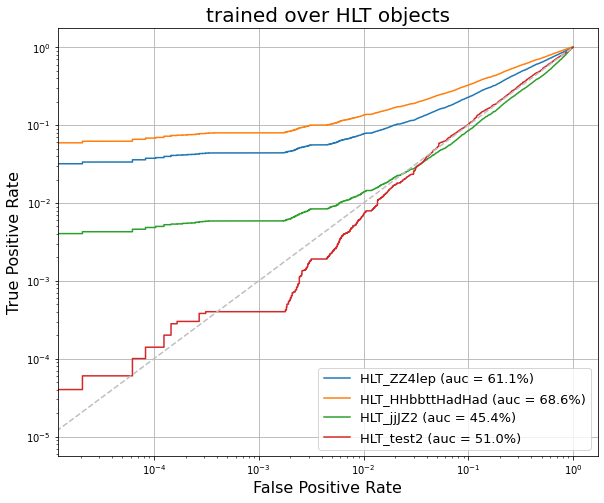

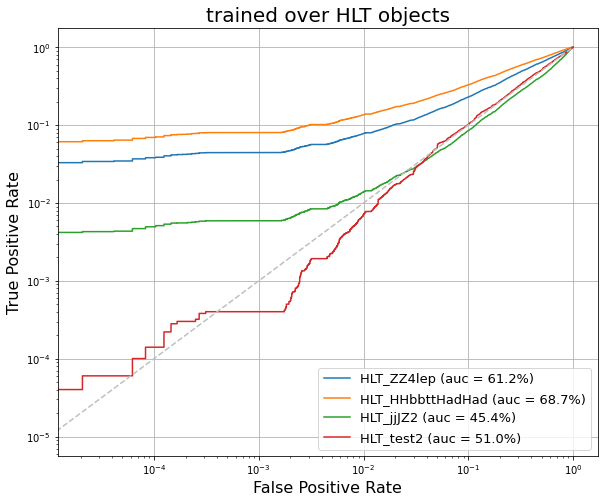

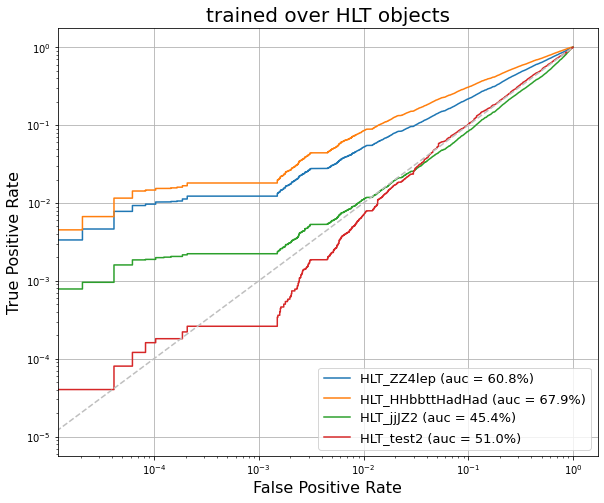

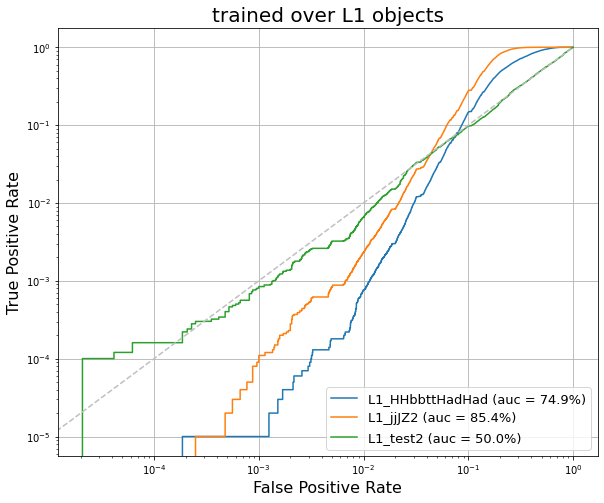

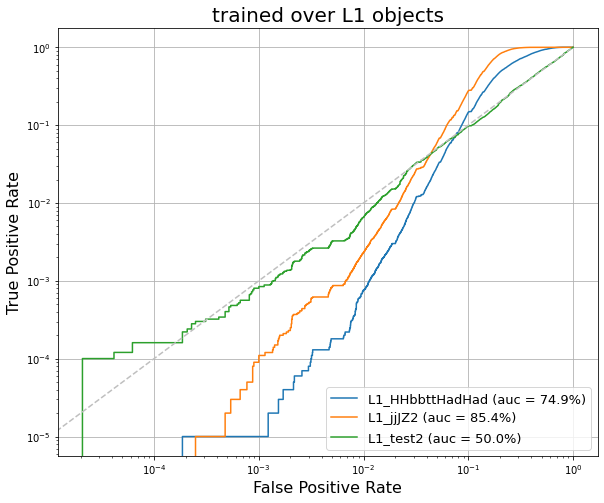

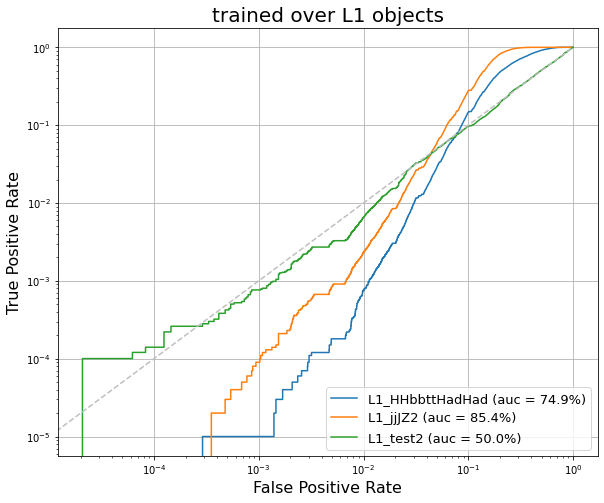

In [40]:
good_tags = ['HLT_test1', 'HLT_test2', 'L1_test1', 'L1_test2', 'HLT_HHbbttHadHad', 'L1_HHbbttHadHad', 'HLT_ZZ4lep', 'HLT_jjJZ2', 'L1_jjJZ2'] # Evaluate over a smaller number of tags for now so this doesn't take 10 years
num_models_per_batch = 14
batch_TPRs_HLT = {}
batch_AUCs_HLT = {}
batch_TPRs_L1 = {}
batch_AUCs_L1 = {}

for batch in range(7):
    print(f'Starting batch {batch}!')

    # Load models for the current batch
    start_num = batch * num_models_per_batch
    models_HLT = [load_models(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]
    models_L1 = [load_models(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]

    # Background data for normalization
    background_data_HLT = datasets['HLT_test1']
    background_data_L1 = datasets['L1_test1']

    # Fit normalizers for each model
    scalers_HLT, qts_HLT = fit_normalizers(models_HLT, background_data_HLT)
    scalers_L1, qts_L1 = fit_normalizers(models_L1, background_data_L1)

    # Results dictionaries for this batch
    raw_scores_dict_HLT = {}
    zscore_normalized_scores_dict_HLT = {}
    quantile_normalized_scores_dict_HLT = {}
    raw_scores_dict_L1 = {}
    zscore_normalized_scores_dict_L1 = {}
    quantile_normalized_scores_dict_L1 = {}

    # Process HLT signals
    for tag, data in datasets.items():
        if tag.startswith('HLT') and tag in good_tags:
            print(f'starting batch {batch} ensembling of {tag} data!')
            raw_scores, zscore_normalized_scores, quantile_normalized_scores = ensemble_AD_scores(models_HLT, data, scalers_HLT, qts_HLT)
            raw_scores_dict_HLT[tag] = raw_scores
            zscore_normalized_scores_dict_HLT[tag] = zscore_normalized_scores
            quantile_normalized_scores_dict_HLT[tag] = quantile_normalized_scores

    # Process L1 signals
    for tag, data in datasets.items():
        if tag.startswith('L1') and tag in good_tags:
            print(f'starting batch {batch} ensembling of {tag} data!')
            raw_scores, zscore_normalized_scores, quantile_normalized_scores = ensemble_AD_scores(models_L1, data, scalers_L1, qts_L1)
            raw_scores_dict_L1[tag] = raw_scores
            zscore_normalized_scores_dict_L1[tag] = zscore_normalized_scores
            quantile_normalized_scores_dict_L1[tag] = quantile_normalized_scores

    # Compute and store ROC results for HLT
    for norm_type, scores_dict in [('raw', raw_scores_dict_HLT), ('zscore', zscore_normalized_scores_dict_HLT), ('quantile', quantile_normalized_scores_dict_HLT)]:
        TPRs, AUCs = ROC_curve(scores_dict, weights, bkg_tag='HLT_test1')
        batch_TPRs_HLT[f'{norm_type}_{batch}'] = TPRs
        batch_AUCs_HLT[f'{norm_type}_{batch}'] = AUCs

    # Compute and store ROC results for L1
    for norm_type, scores_dict in [('raw', raw_scores_dict_L1), ('zscore', zscore_normalized_scores_dict_L1), ('quantile', quantile_normalized_scores_dict_L1)]:
        TPRs, AUCs = ROC_curve(scores_dict, weights, bkg_tag='L1_test1')
        batch_TPRs_L1[f'{norm_type}_{batch}'] = TPRs
        batch_AUCs_L1[f'{norm_type}_{batch}'] = AUCs

    print('')

In [41]:
# Save HLT results to JSON files
with open('./trained_models/ensemble_5-13-2024/batch_TPRs_HLT_11.json', 'w') as f:
    json.dump(batch_TPRs_HLT, f)

with open('./trained_models/ensemble_5-13-2024/batch_AUCs_HLT_11.json', 'w') as f:
    json.dump(batch_AUCs_HLT, f)

# Save L1 results to JSON files
with open('./trained_models/ensemble_5-13-2024/batch_TPRs_L1_11.json', 'w') as f:
    json.dump(batch_TPRs_L1, f)

with open('./trained_models/ensemble_5-13-2024/batch_AUCs_L1_11.json', 'w') as f:
    json.dump(batch_AUCs_L1, f)

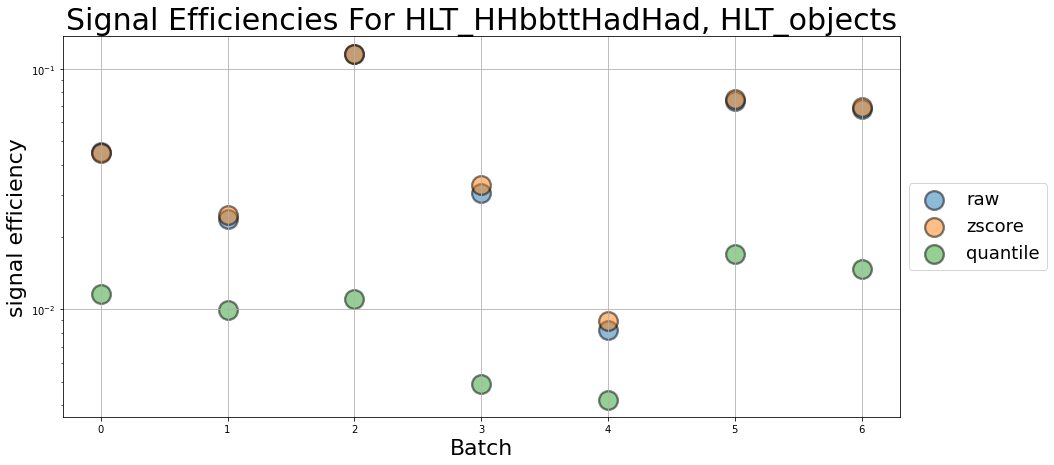

In [62]:
# Extract TPRs
plt.figure(figsize=(15, 7))
signal_tag = 'HLT_HHbbttHadHad'
for norm_type in ['raw', 'zscore', 'quantile']:
    TPRs = []
    for i in range(7):
        TPRs.append(batch_TPRs_HLT[norm_type+'_'+str(i)][signal_tag])

    plt.scatter(np.arange(7), TPRs, label=norm_type, s=350, edgecolors='k', linewidth=2.3, alpha=0.5)
plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('Batch', fontsize=22)
plt.title(f"Signal Efficiencies For {signal_tag}, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

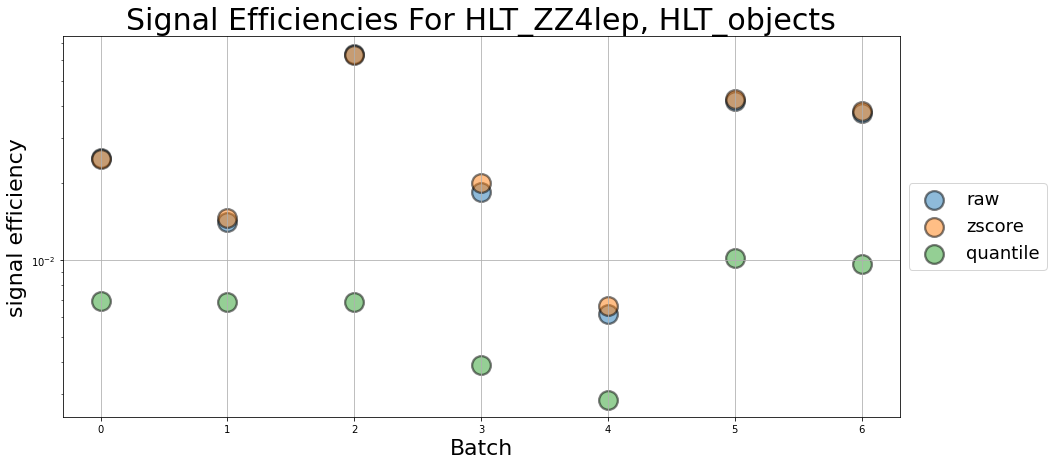

In [63]:
# Extract TPRs
plt.figure(figsize=(15, 7))
signal_tag = 'HLT_ZZ4lep'
for norm_type in ['raw', 'zscore', 'quantile']:
    TPRs = []
    for i in range(7):
        TPRs.append(batch_TPRs_HLT[norm_type+'_'+str(i)][signal_tag])

    plt.scatter(np.arange(7), TPRs, label=norm_type, s=350, edgecolors='k', linewidth=2.3, alpha=0.5)
plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('Batch', fontsize=22)
plt.title(f"Signal Efficiencies For {signal_tag}, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

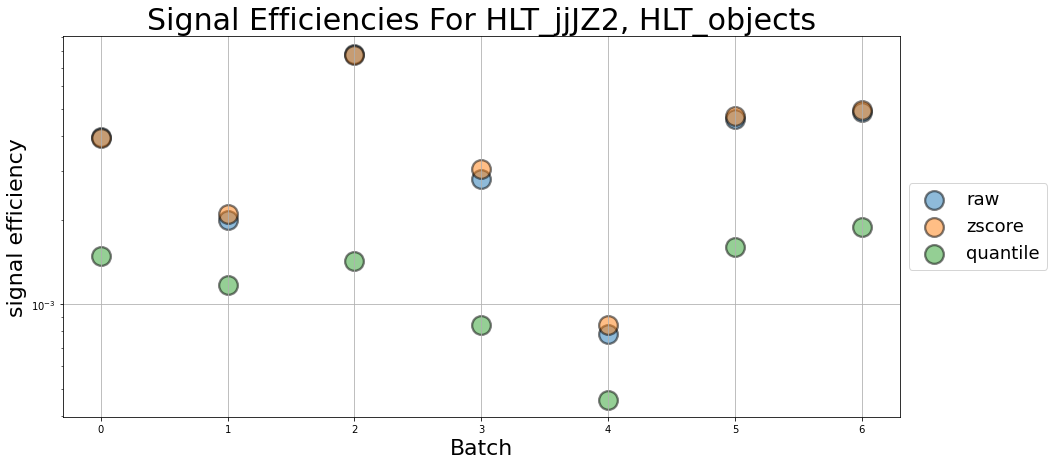

In [64]:
# Extract TPRs
plt.figure(figsize=(15, 7))
signal_tag = 'HLT_jjJZ2'
for norm_type in ['raw', 'zscore', 'quantile']:
    TPRs = []
    for i in range(7):
        TPRs.append(batch_TPRs_HLT[norm_type+'_'+str(i)][signal_tag])

    plt.scatter(np.arange(7), TPRs, label=norm_type, s=350, edgecolors='k', linewidth=2.3, alpha=0.5)
plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('Batch', fontsize=22)
plt.title(f"Signal Efficiencies For {signal_tag}, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Old Old

In [25]:
with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs3.json', 'r') as file:
    batch_TPRs = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs_scaled3.json', 'r') as file:
    batch_TPRs_scaled = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs3.json', 'r') as file:
    batch_AUCs = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs_scaled3.json', 'r') as file:
    batch_AUCs_scaled = json.load(file)

['HLT_ZZ4lep', 'HLT_HHbbttHadHad', 'HLT_jjJZ2', 'HLT_test2']


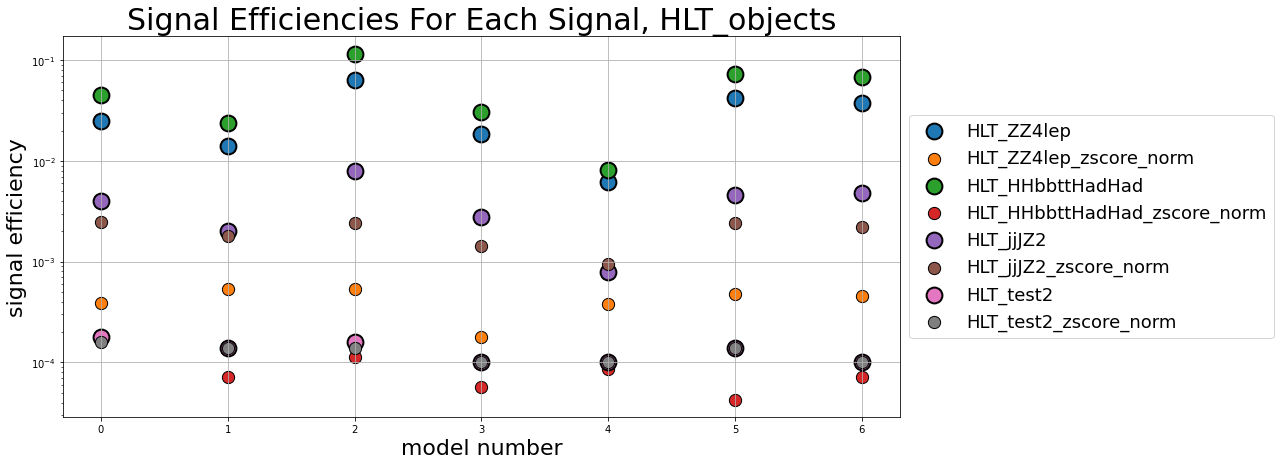

In [26]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in next(iter(batch_TPRs.values())).keys()]
print(good_tags)

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    TPR_scaled = []
    #model_ids = []
    for batch_tag, TPR_dict in batch_TPRs.items():
        if batch_tag.startswith('HLT'):
            #model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
            TPR_scaled.append(batch_TPRs_scaled[batch_tag][tag])
        
    plt.scatter(np.arange(len(TPR)), TPR, label=tag, s=250, edgecolors='k', linewidth=2)
    plt.scatter(np.arange(len(TPR_scaled)), TPR_scaled, label=tag+'_zscore_norm', s=150, edgecolors='k', linewidth=1)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiencies For Each Signal, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

['HLT_ZZ4lep', 'HLT_HHbbttHadHad', 'HLT_jjJZ2', 'HLT_test2']


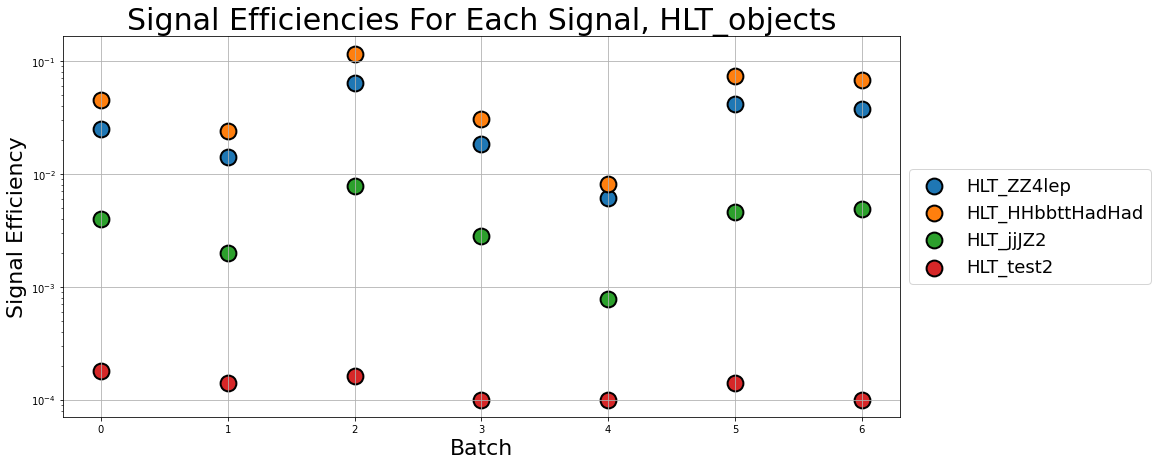

In [27]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in next(iter(batch_TPRs.values())).keys()]
print(good_tags)

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    TPR_scaled = []
    #model_ids = []
    for batch_tag, TPR_dict in batch_TPRs.items():
        if batch_tag.startswith('HLT'):
            #model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
            TPR_scaled.append(batch_TPRs_scaled[batch_tag][tag])
        
    plt.scatter(np.arange(len(TPR)), TPR, label=tag, s=250, edgecolors='k', linewidth=2)
    #plt.scatter(np.arange(len(TPR_scaled)), TPR_scaled, label=tag+'_scaled', s=150, edgecolors='k', linewidth=1)

plt.yscale('log')
plt.ylabel('Signal Efficiency', fontsize=22)
plt.xlabel('Batch', fontsize=22)
plt.title(f"Signal Efficiencies For Each Signal, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Plotting the AD scores before and after normalization to see what's happening

My theory is that the different models are choosing different events to be the most anomalous, and so this normalizing average doesn't work so well. Actually, I'm not sure normalizing would be any different than not. Unsure here.

Starting batch 0!
starting batch 0 ensembling of HLT_ZZ4lep data!


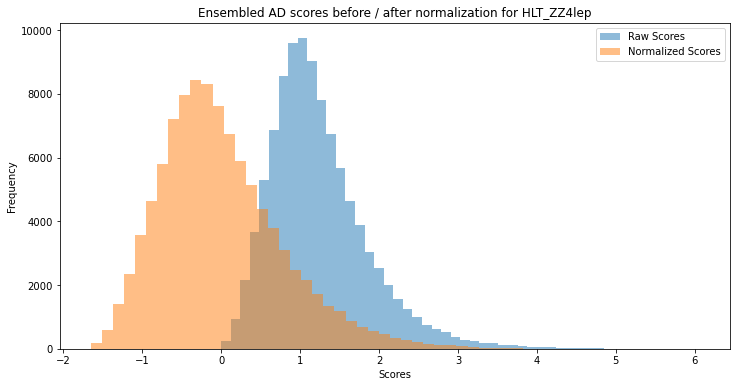

starting batch 0 ensembling of HLT_HHbbttHadHad data!


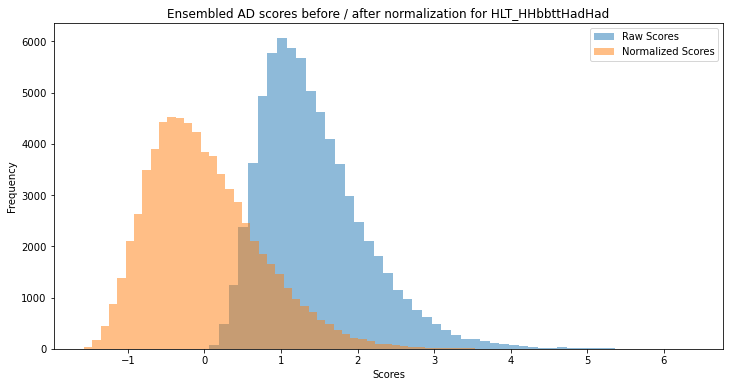

starting batch 0 ensembling of HLT_jjJZ2 data!


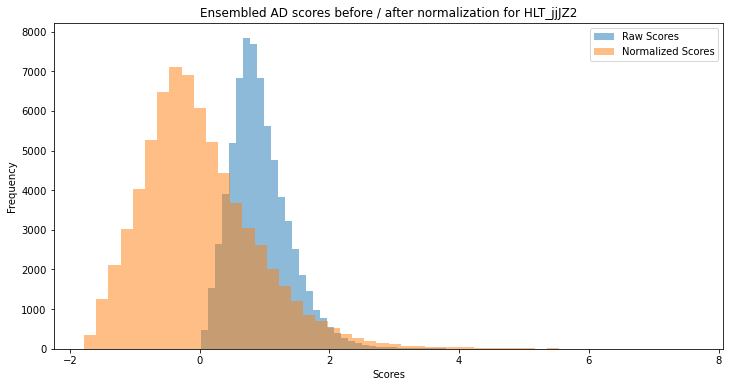

starting batch 0 ensembling of HLT_test1 data!


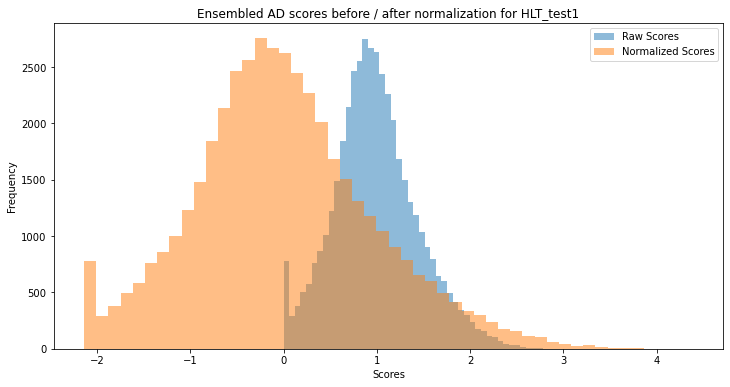

starting batch 0 ensembling of HLT_test2 data!


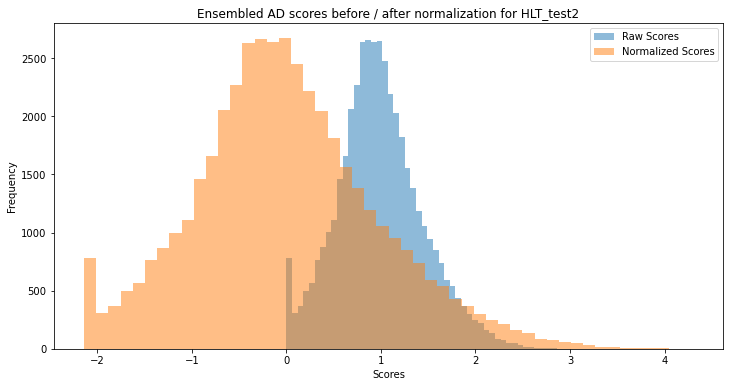

starting batch 0 ensembling of L1_HHbbttHadHad data!


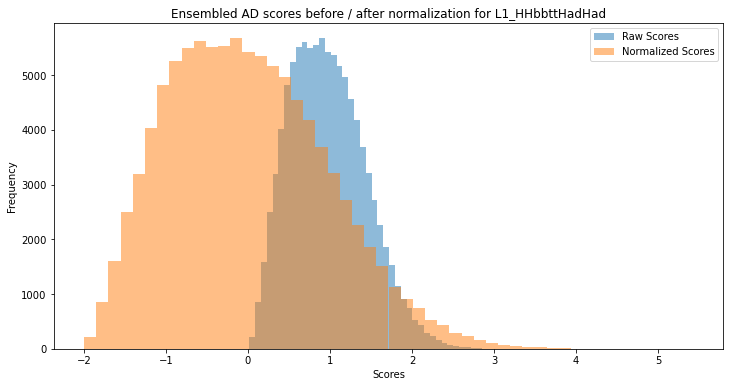

starting batch 0 ensembling of L1_jjJZ2 data!


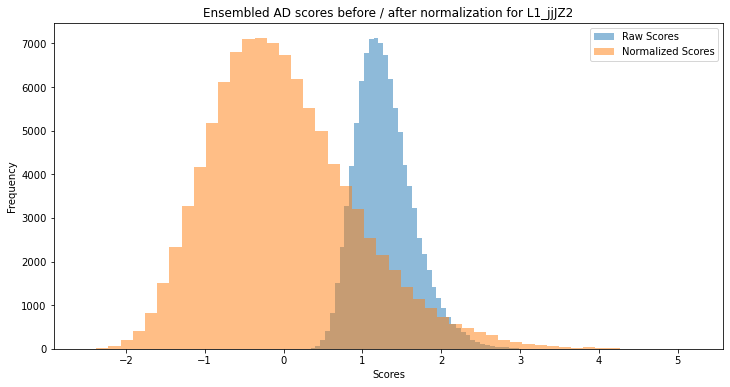

starting batch 0 ensembling of L1_test1 data!


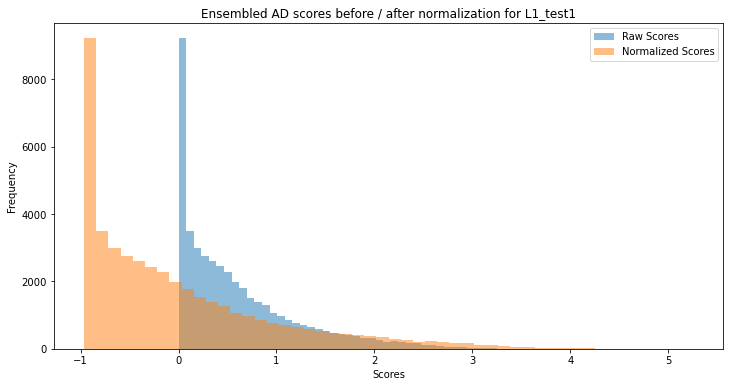

starting batch 0 ensembling of L1_test2 data!


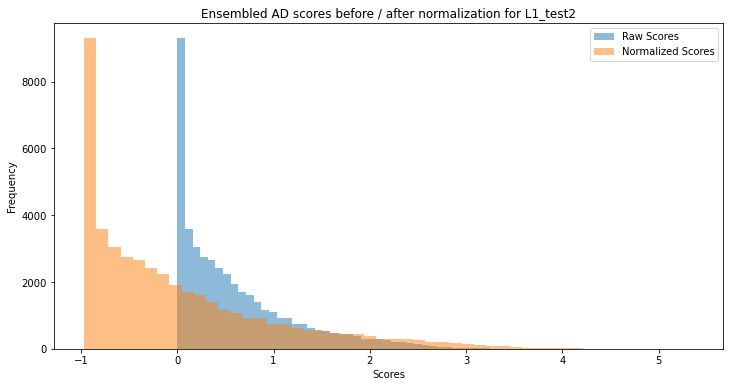

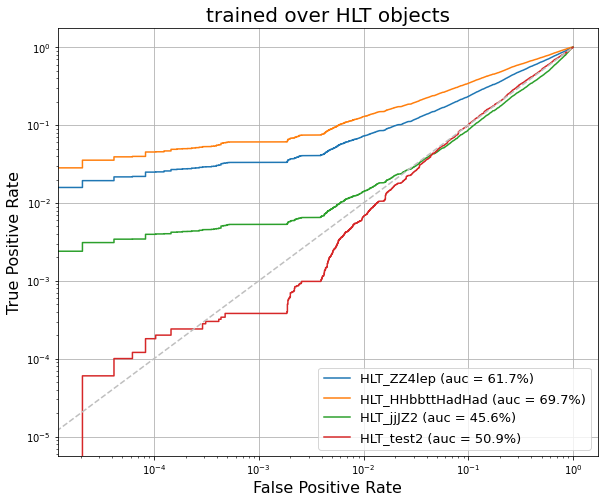

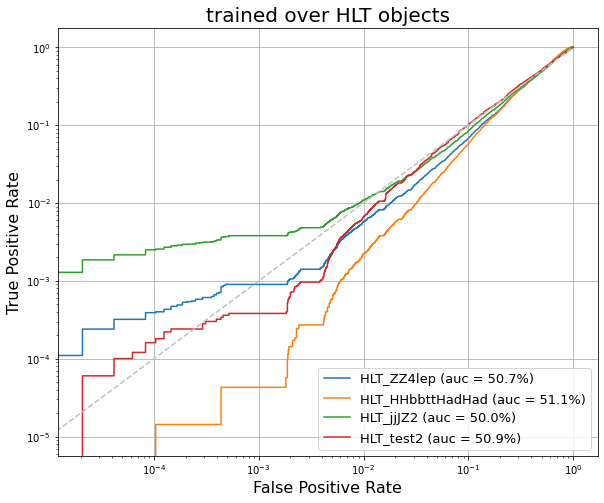

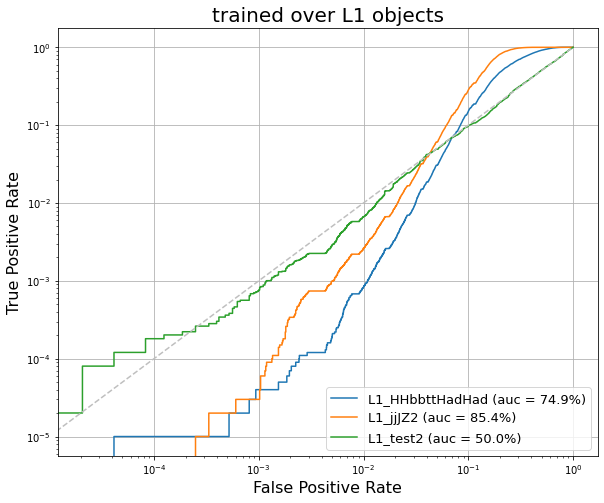

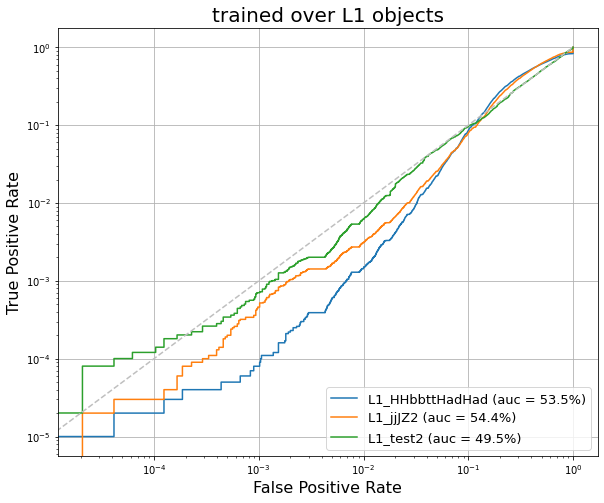

In [33]:
# Pass the data through all these models and collect results.
# There are 99 total models, I'm going to ensemble in batches of 14 models, with 7 total batches
# So we will have 7 ensembled results to compare and check stability.


skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets
good_tags = ['HLT_test1', 'HLT_test2', 'L1_test1', 'L1_test2', 'HLT_HHbbttHadHad', 'L1_HHbbttHadHad', 'HLT_ZZ4lep', 'HLT_jjJZ2', 'L1_jjJZ2'] # Evaluate over a smaller number of tags for now so this doesn't take 10 years
num_models_per_batch = 14

# Dictionaries to hold the results. The values of these dictionaries will hold 7 dictionaries, one for each batch
# They will map {modelType_batchNum : dictionary} e.g. {HLT_1 : TPR_dict}
batch_TPRs = {}
batch_TPRs_scaled = {}
batch_AUCs = {}
batch_AUCs_scaled = {}

for batch in range(7):
    if batch > 0: break
    print(f'Starting batch {batch}!')

    # Setup + load in models # --------------------------------------------------------------------------------
    avg_AD_scores = {}
    avg_scaled_AD_scores = {}

    start_num = batch*num_models_per_batch # the first model number that has not been tested already
    
    models = {
        'HLT': [load_model(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)],
        'L1': [load_model(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]
    }
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Pass the data through the models ------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        for tag, data in datasets.items():
            if tag.startswith(model_type) and tag in good_tags: # only pass HLT datasets through HLT model and vice versa
        
                print(f'starting batch {batch} ensembling of {tag} data!')
                avg_AD, avg_scaled_AD = ensemble_AD_scores_with_zscore(models[model_type], data)
                avg_AD_scores[tag] = avg_AD
                avg_scaled_AD_scores[tag] = avg_scaled_AD

                plt.figure(figsize=(12, 6))
                plt.hist(avg_AD, bins=50, alpha=0.5, label='Raw Scores')
                plt.hist(avg_scaled_AD, bins=50, alpha=0.5, label='Normalized Scores')
                plt.legend(loc='upper right')
                plt.title(f'Ensembled AD scores before / after normalization for {tag}')
                plt.xlabel('Scores')
                plt.ylabel('Frequency')
                plt.show()
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Append results # ----------------------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        TPRs_avg, AUCs_avg = ROC_curve(avg_AD_scores, weights, bkg_tag=f'{model_type}_test1')
        batch_TPRs[f'{model_type}_{batch}'] = TPRs_avg
        batch_AUCs[f'{model_type}_{batch}'] = AUCs_avg
    
    
        TPRs_avg_scaled, AUCs_avg_scaled = ROC_curve(avg_scaled_AD_scores, weights, bkg_tag=f'{model_type}_test1')
        batch_TPRs_scaled[f'{model_type}_{batch}'] = TPRs_avg_scaled
        batch_AUCs_scaled[f'{model_type}_{batch}'] = AUCs_avg_scaled
    # ---------------------------------------------------------------------------------------------------------
    print('')

In [34]:
def ensemble_AD_scores(models, data):
    
    # make predictions
    model_outputs = [model.predict(data, verbose=0) for model in models]

    # Calculate AD scores
    model_AD_scores = [AD_score(data, model_output) for model_output in model_outputs]
    model_AD_scores_scaled = [quantile_transform(AD_scores.reshape(-1, 1)).flatten() for AD_scores in model_AD_scores]
    
    # average across ensemble members
    avg_AD_scores = np.mean(model_AD_scores, axis=0)
    avg_scaled_AD_scores = np.mean(model_AD_scores_scaled, axis=0)
    
    return avg_AD_scores, avg_scaled_AD_scores

Starting batch 0!
starting batch 0 ensembling of HLT_ZZ4lep data!


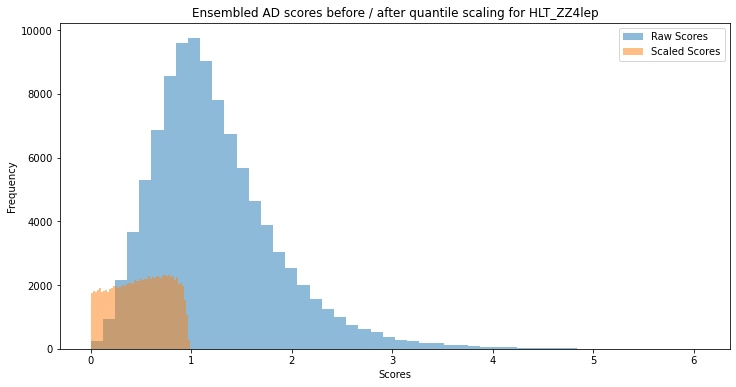

starting batch 0 ensembling of HLT_HHbbttHadHad data!


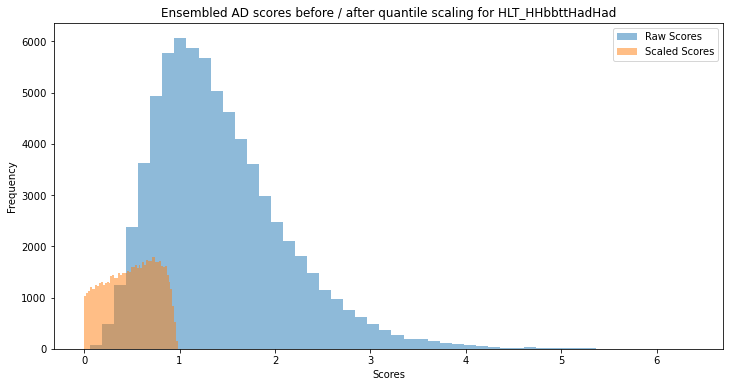

starting batch 0 ensembling of HLT_jjJZ2 data!


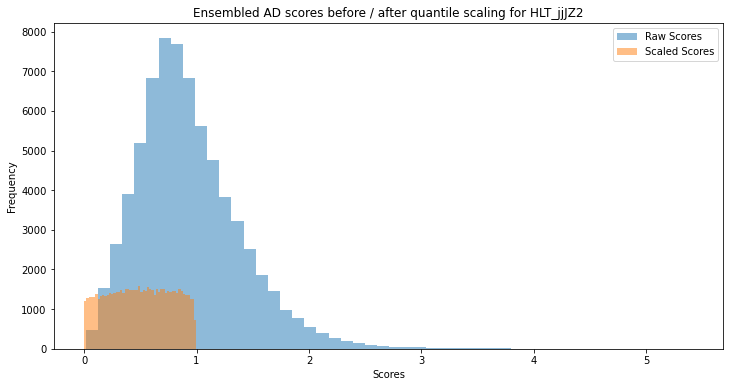

starting batch 0 ensembling of HLT_test1 data!


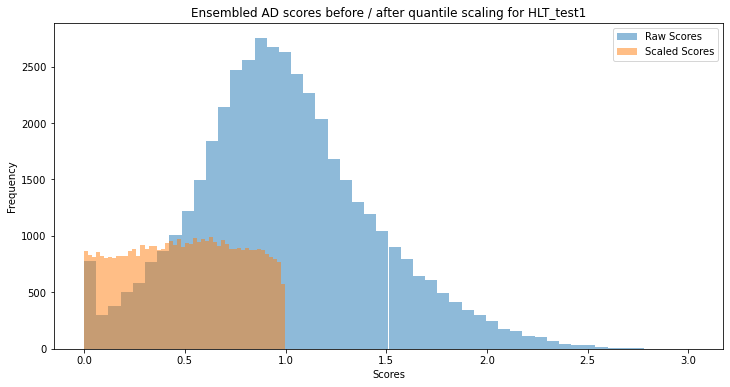

starting batch 0 ensembling of HLT_test2 data!


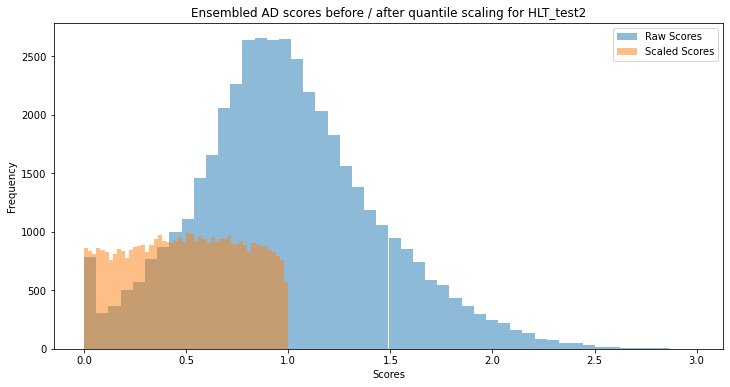

starting batch 0 ensembling of L1_HHbbttHadHad data!


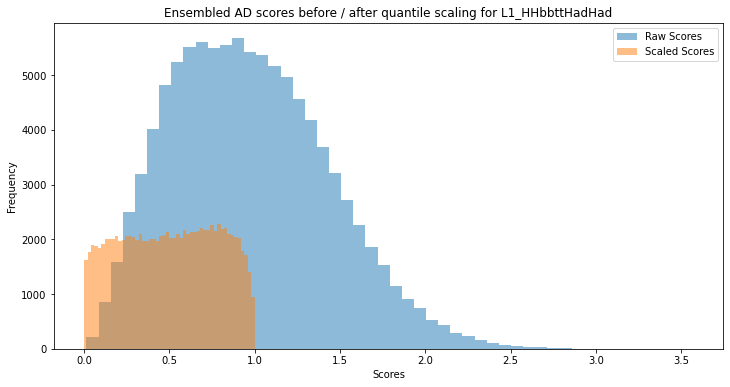

starting batch 0 ensembling of L1_jjJZ2 data!


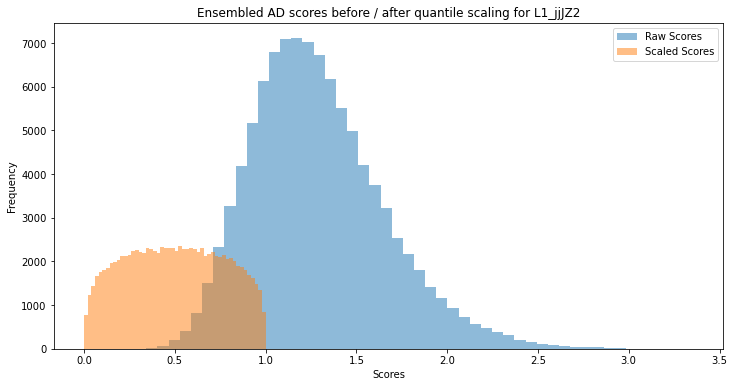

starting batch 0 ensembling of L1_test1 data!


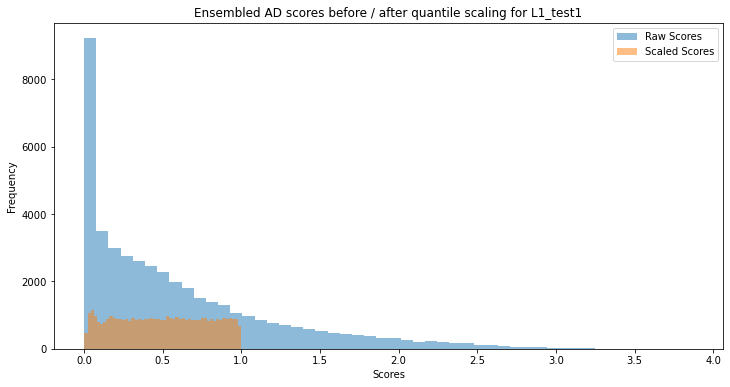

starting batch 0 ensembling of L1_test2 data!


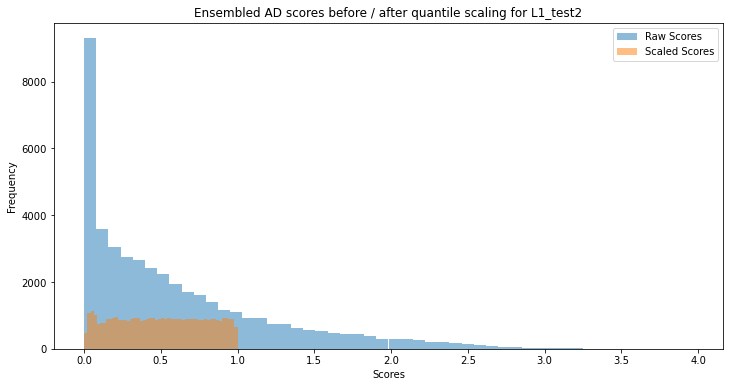

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

In [35]:
# Pass the data through all these models and collect results.
# There are 99 total models, I'm going to ensemble in batches of 14 models, with 7 total batches
# So we will have 7 ensembled results to compare and check stability.


skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets
good_tags = ['HLT_test1', 'HLT_test2', 'L1_test1', 'L1_test2', 'HLT_HHbbttHadHad', 'L1_HHbbttHadHad', 'HLT_ZZ4lep', 'HLT_jjJZ2', 'L1_jjJZ2'] # Evaluate over a smaller number of tags for now so this doesn't take 10 years
num_models_per_batch = 14

# Dictionaries to hold the results. The values of these dictionaries will hold 7 dictionaries, one for each batch
# They will map {modelType_batchNum : dictionary} e.g. {HLT_1 : TPR_dict}
batch_TPRs = {}
batch_TPRs_scaled = {}
batch_AUCs = {}
batch_AUCs_scaled = {}

for batch in range(7):
    if batch > 0: break
    print(f'Starting batch {batch}!')

    # Setup + load in models # --------------------------------------------------------------------------------
    avg_AD_scores = {}
    avg_scaled_AD_scores = {}

    start_num = batch*num_models_per_batch # the first model number that has not been tested already
    
    models = {
        'HLT': [load_model(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)],
        'L1': [load_model(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]
    }
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Pass the data through the models ------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        for tag, data in datasets.items():
            if tag.startswith(model_type) and tag in good_tags: # only pass HLT datasets through HLT model and vice versa
        
                print(f'starting batch {batch} ensembling of {tag} data!')
                avg_AD, avg_scaled_AD = ensemble_AD_scores(models[model_type], data)
                avg_AD_scores[tag] = avg_AD
                avg_scaled_AD_scores[tag] = avg_scaled_AD

                plt.figure(figsize=(12, 6))
                plt.hist(avg_AD, bins=50, alpha=0.5, label='Raw Scores')
                plt.hist(avg_scaled_AD, bins=50, alpha=0.5, label='Scaled Scores')
                plt.legend(loc='upper right')
                plt.title(f'Ensembled AD scores before / after quantile scaling for {tag}')
                plt.xlabel('Scores')
                plt.ylabel('Frequency')
                plt.show()
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Append results # ----------------------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        TPRs_avg, AUCs_avg = ROC_curve(avg_AD_scores, weights, bkg_tag=f'{model_type}_test1', plot=False)
        batch_TPRs[f'{model_type}_{batch}'] = TPRs_avg
        batch_AUCs[f'{model_type}_{batch}'] = AUCs_avg
    
    
        TPRs_avg_scaled, AUCs_avg_scaled = ROC_curve(avg_scaled_AD_scores, weights, bkg_tag=f'{model_type}_test1', plot=False)
        batch_TPRs_scaled[f'{model_type}_{batch}'] = TPRs_avg_scaled
        batch_AUCs_scaled[f'{model_type}_{batch}'] = AUCs_avg_scaled
    # ---------------------------------------------------------------------------------------------------------
    print('')

## Old Ensembling: (didn't work well at all)

In [19]:
def ensemble_predictions(models, data):
    
    # make predictions
    model_outputs = [model.predict(data, verbose=0) for model in models]
    model_outputs_scaled = [quantile_transform(output) for output in model_outputs]
    
    # average across ensemble members
    avg_reconstruction = np.mean(model_outputs, axis=0)
    avg_scaled_recon = np.mean(model_outputs_scaled, axis=0)
    return avg_reconstruction, avg_scaled_recon

In [25]:
# Pass the data through all these models and collect results.
# There are 99 total models, I'm going to ensemble in batches of 14 models, with 7 total batches
# So we will have 7 ensembled results to compare and check stability.


skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets
good_tags = ['HLT_test1', 'HLT_test2', 'L1_test1', 'L1_test2', 'HLT_HHbbttHadHad', 'L1_HHbbttHadHad', 'HLT_ZZ4lep', 'HLT_jjJZ2', 'L1_jjJZ2'] # Evaluate over a smaller number of tags for now so this doesn't take 10 years
num_models_per_batch = 14

# Dictionaries to hold the results. The values of these dictionaries will hold 7 dictionaries, one for each batch
# They will map {modelType_batchNum : dictionary} e.g. {HLT_1 : TPR_dict}
batch_TPRs = {}
batch_TPRs_scaled = {}
batch_AUCs = {}
batch_AUCs_scaled = {}

for batch in range(7):
    print(f'Starting batch {batch}!')

    # Setup + load in models # --------------------------------------------------------------------------------
    avg_model_outputs = {}
    avg_scaled_model_outputs = {}
    avg_AD_scores = {}
    avg_scaled_AD_scores = {}

    start_num = batch*num_models_per_batch # the first model number that has not been tested already
    
    models = {
        'HLT': [load_model(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)],
        'L1': [load_model(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]
    }
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Pass the data through the models ------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        for tag, data in datasets.items():
            if tag.startswith(model_type) and tag in good_tags: # only pass HLT datasets through HLT model and vice versa
        
                print(f'starting batch {batch} ensembling of {tag} data!')
                avg_recon, avg_scaled_recon = ensemble_predictions(models[model_type], data)
                avg_model_outputs[tag] = avg_recon
                avg_scaled_model_outputs[tag] = avg_scaled_recon
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Calculate the AD scores ---------------------------------------------------------------------------------
    for tag, model_output in avg_model_outputs.items():
        avg_AD_scores[tag] = AD_score(datasets[tag], model_output)
    
    for tag, model_output in avg_scaled_model_outputs.items():
        avg_scaled_AD_scores[tag] = AD_score(datasets[tag], model_output)
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Append results # ----------------------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        TPRs_avg, AUCs_avg = ROC_curve(avg_AD_scores, weights, bkg_tag=f'{model_type}_test1', plot=False)
        batch_TPRs[f'{model_type}_{batch}'] = TPRs_avg
        batch_AUCs[f'{model_type}_{batch}'] = AUCs_avg
    
    
        TPRs_avg_scaled, AUCs_avg_scaled = ROC_curve(avg_scaled_AD_scores, weights, bkg_tag=f'{model_type}_test1', plot=False)
        batch_TPRs_scaled[f'{model_type}_{batch}'] = TPRs_avg_scaled
        batch_AUCs_scaled[f'{model_type}_{batch}'] = AUCs_avg_scaled
    # ---------------------------------------------------------------------------------------------------------
    print('')

Starting batch 0!
starting batch 0 ensembling of HLT_ZZ4lep data!
starting batch 0 ensembling of HLT_HHbbttHadHad data!
starting batch 0 ensembling of HLT_jjJZ2 data!
starting batch 0 ensembling of HLT_test1 data!
starting batch 0 ensembling of HLT_test2 data!
starting batch 0 ensembling of L1_HHbbttHadHad data!
starting batch 0 ensembling of L1_jjJZ2 data!
starting batch 0 ensembling of L1_test1 data!
starting batch 0 ensembling of L1_test2 data!

Starting batch 1!
starting batch 1 ensembling of HLT_ZZ4lep data!
starting batch 1 ensembling of HLT_HHbbttHadHad data!
starting batch 1 ensembling of HLT_jjJZ2 data!
starting batch 1 ensembling of HLT_test1 data!
starting batch 1 ensembling of HLT_test2 data!
starting batch 1 ensembling of L1_HHbbttHadHad data!
starting batch 1 ensembling of L1_jjJZ2 data!
starting batch 1 ensembling of L1_test1 data!
starting batch 1 ensembling of L1_test2 data!

Starting batch 2!
starting batch 2 ensembling of HLT_ZZ4lep data!
starting batch 2 ensembling 

/tmp/ipykernel_337/3436382117.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8.5,6.8))



Starting batch 6!
starting batch 6 ensembling of HLT_ZZ4lep data!
starting batch 6 ensembling of HLT_HHbbttHadHad data!
starting batch 6 ensembling of HLT_jjJZ2 data!
starting batch 6 ensembling of HLT_test1 data!
starting batch 6 ensembling of HLT_test2 data!
starting batch 6 ensembling of L1_HHbbttHadHad data!
starting batch 6 ensembling of L1_jjJZ2 data!
starting batch 6 ensembling of L1_test1 data!
starting batch 6 ensembling of L1_test2 data!



<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

<Figure size 612x489.6 with 0 Axes>

In [26]:
import json

with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs.json', 'w') as file:
    json.dump(batch_TPRs, file, indent=4)

with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs_scaled.json', 'w') as file:
    json.dump(batch_TPRs_scaled, file, indent=4)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs.json', 'w') as file:
    json.dump(batch_AUCs, file, indent=4)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs_scaled.json', 'w') as file:
    json.dump(batch_AUCs_scaled, file, indent=4)

print(batch_TPRs.keys())

dict_keys(['HLT_0', 'L1_0', 'HLT_1', 'L1_1', 'HLT_2', 'L1_2', 'HLT_3', 'L1_3', 'HLT_4', 'L1_4', 'HLT_5', 'L1_5', 'HLT_6', 'L1_6'])


In [29]:
with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs.json', 'r') as file:
    batch_TPRs = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_TPRs_scaled.json', 'r') as file:
    batch_TPRs_scaled = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs.json', 'r') as file:
    batch_AUCs = json.load(file)

with open(f'./trained_models/ensemble_5-13-2024/batch_AUCs_scaled.json', 'r') as file:
    batch_AUCs_scaled = json.load(file)

In [30]:
print(batch_TPRs['HLT_0'].items())

dict_items([('HLT_ZZ4lep', 0.00107), ('HLT_HHbbttHadHad', 0.0010285714285714286), ('HLT_jjJZ2', 0.00018571428571428572), ('HLT_test2', 0.00014044500673543955)])


['HLT_ZZ4lep', 'HLT_HHbbttHadHad', 'HLT_jjJZ2', 'HLT_test2']


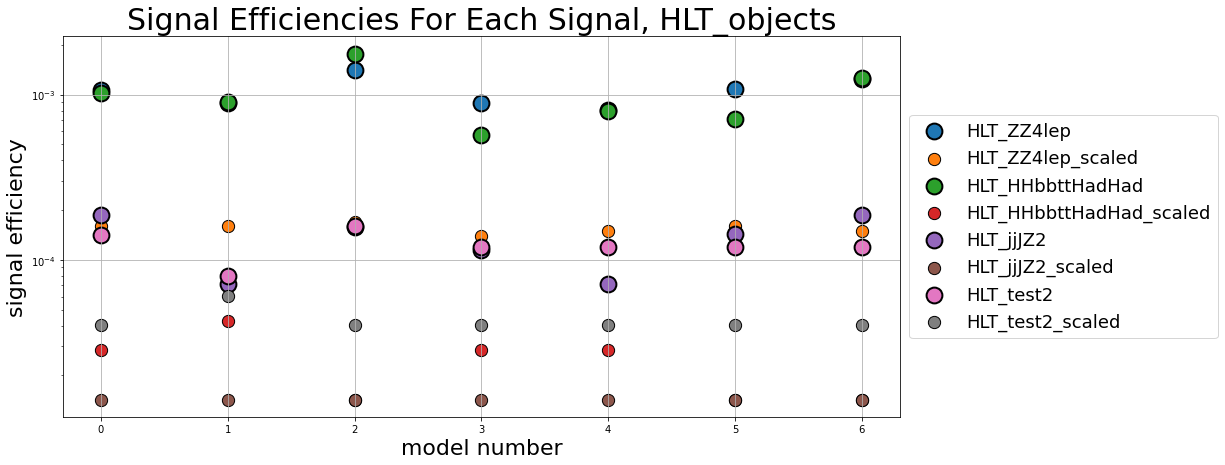

In [31]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in next(iter(batch_TPRs.values())).keys()]
print(good_tags)

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    TPR_scaled = []
    #model_ids = []
    for batch_tag, TPR_dict in batch_TPRs.items():
        if batch_tag.startswith('HLT'):
            #model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
            TPR_scaled.append(batch_TPRs_scaled[batch_tag][tag])
        
    plt.scatter(np.arange(len(TPR)), TPR, label=tag, s=250, edgecolors='k', linewidth=2)
    plt.scatter(np.arange(len(TPR_scaled)), TPR_scaled, label=tag+'_scaled', s=150, edgecolors='k', linewidth=1)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiencies For Each Signal, HLT_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

['L1_HHbbttHadHad', 'L1_jjJZ2', 'L1_test2']
[0.0, 0.0, 0.0, 0.0, 1e-05, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.00014044500673545508, 0.00014164505596121318, 0.00014044500673545546, 0.00012038143434467509, 0.00018057215151701195, 0.0001404450067354535, 0.00014044500673545543]


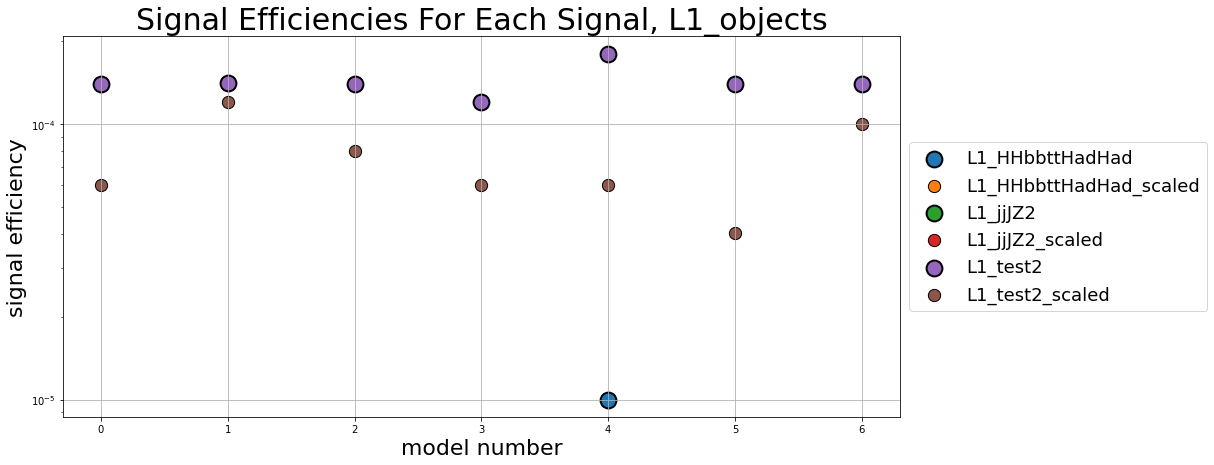

In [34]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in batch_TPRs['L1_0'].keys()]
print(good_tags)

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    TPR_scaled = []
    #model_ids = []
    for batch_tag, TPR_dict in batch_TPRs.items():
        if batch_tag.startswith('L1'):
            #model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
            TPR_scaled.append(batch_TPRs_scaled[batch_tag][tag])

    print(TPR)
    plt.scatter(np.arange(len(TPR)), TPR, label=tag, s=250, edgecolors='k', linewidth=2)
    plt.scatter(np.arange(len(TPR_scaled)), TPR_scaled, label=tag+'_scaled', s=150, edgecolors='k', linewidth=1)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiencies For Each Signal, L1_objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
small_datasets = {key : value[0:1000] for key, value in datasets.items()}
small_weights = {key : value[0:1000] for key, value in weights.items()}

Starting batch 0!
starting batch 0 ensembling of HLT_ZZ4lep data!
starting batch 0 ensembling of HLT_HHbbttHadHad data!
starting batch 0 ensembling of HLT_jjJZ2 data!
starting batch 0 ensembling of HLT_test1 data!
starting batch 0 ensembling of HLT_test2 data!
starting batch 0 ensembling of L1_HHbbttHadHad data!
starting batch 0 ensembling of L1_jjJZ2 data!
starting batch 0 ensembling of L1_test1 data!
starting batch 0 ensembling of L1_test2 data!


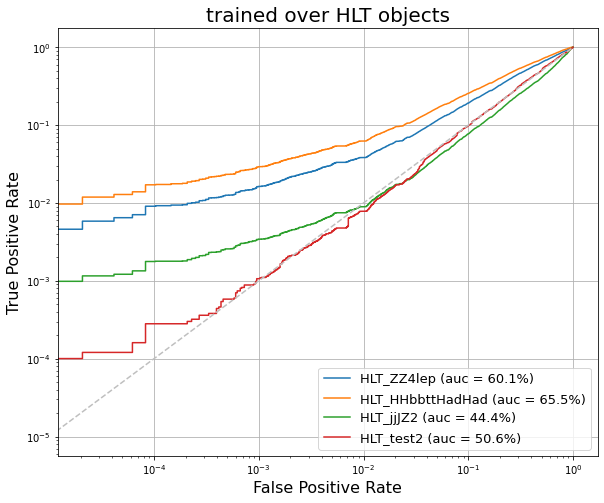

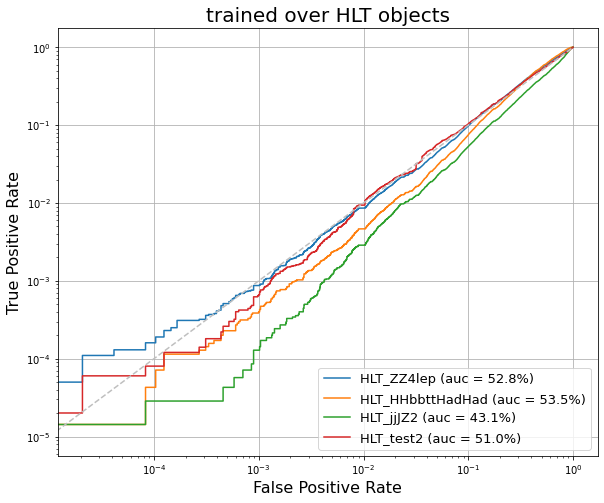

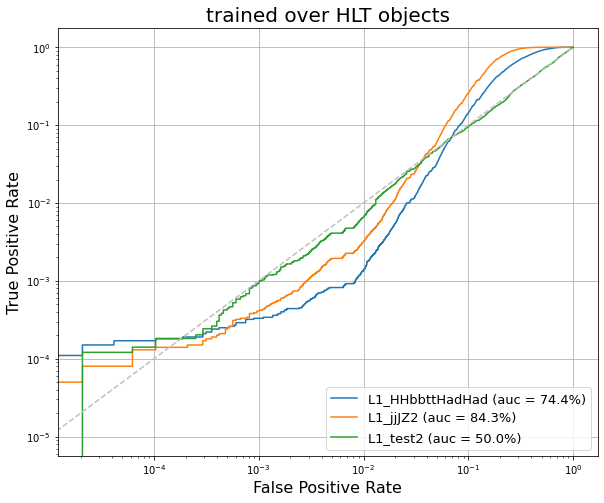

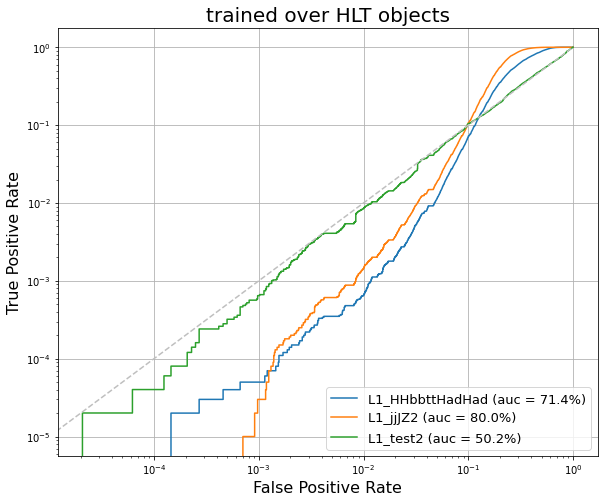


Starting batch 1!
starting batch 1 ensembling of HLT_ZZ4lep data!
starting batch 1 ensembling of HLT_HHbbttHadHad data!
starting batch 1 ensembling of HLT_jjJZ2 data!
starting batch 1 ensembling of HLT_test1 data!
starting batch 1 ensembling of HLT_test2 data!
starting batch 1 ensembling of L1_HHbbttHadHad data!
starting batch 1 ensembling of L1_jjJZ2 data!
starting batch 1 ensembling of L1_test1 data!
starting batch 1 ensembling of L1_test2 data!


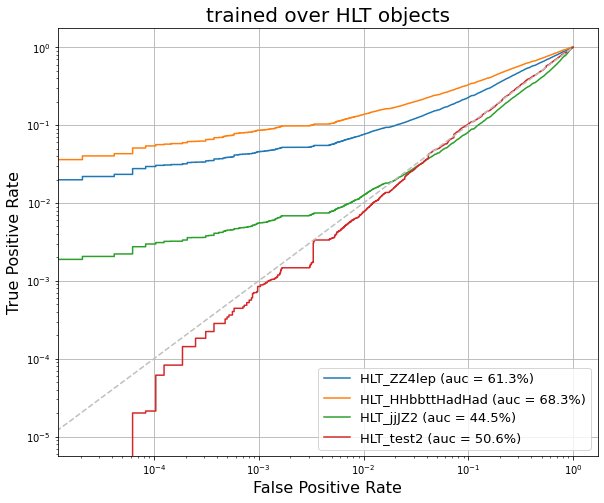

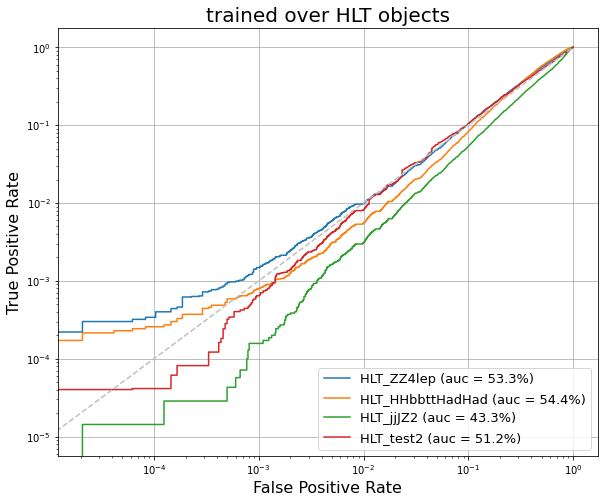

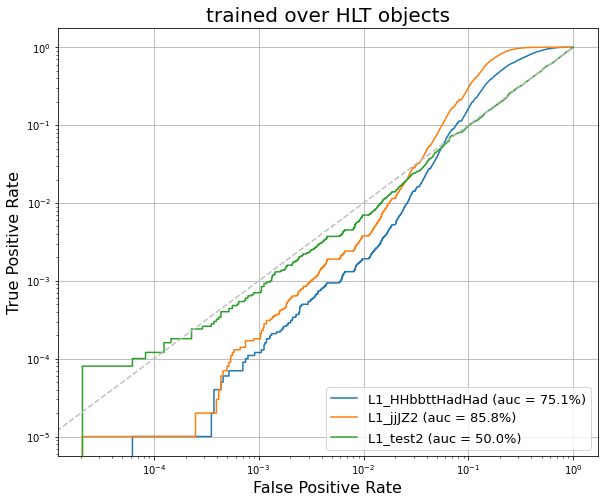

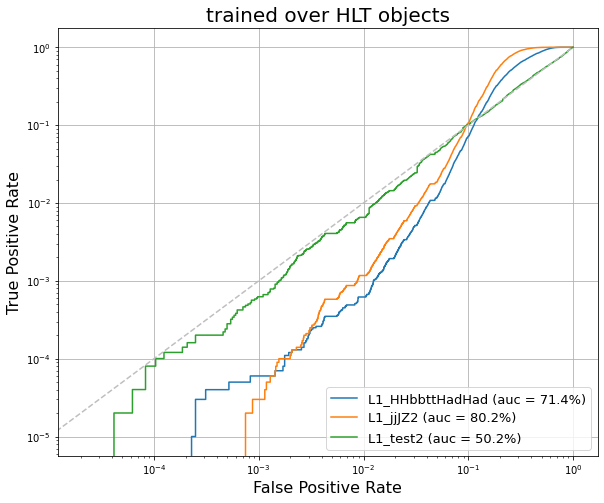


Starting batch 2!
starting batch 2 ensembling of HLT_ZZ4lep data!
starting batch 2 ensembling of HLT_HHbbttHadHad data!
starting batch 2 ensembling of HLT_jjJZ2 data!
starting batch 2 ensembling of HLT_test1 data!
starting batch 2 ensembling of HLT_test2 data!
starting batch 2 ensembling of L1_HHbbttHadHad data!
starting batch 2 ensembling of L1_jjJZ2 data!
starting batch 2 ensembling of L1_test1 data!
starting batch 2 ensembling of L1_test2 data!


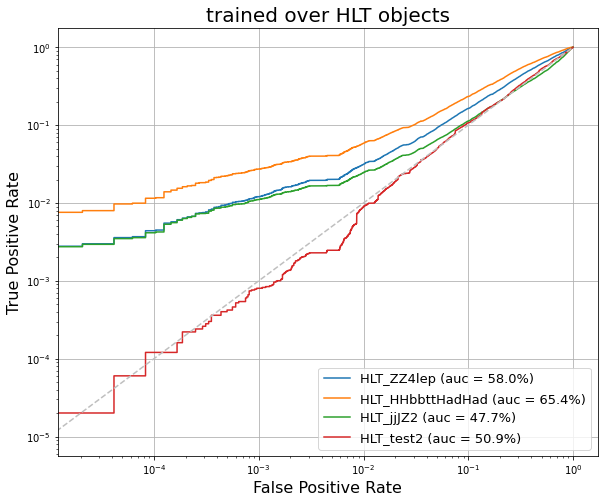

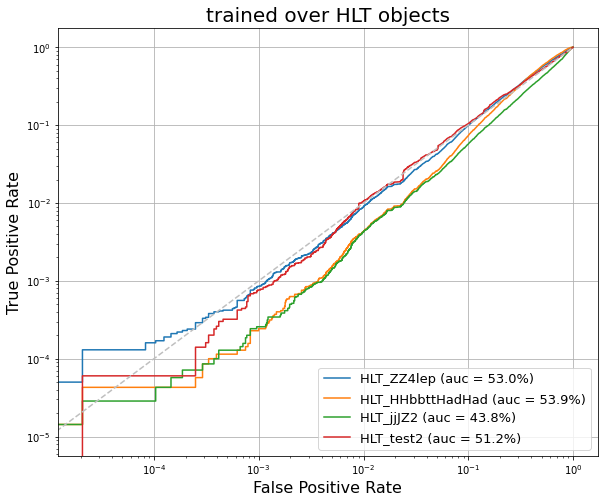

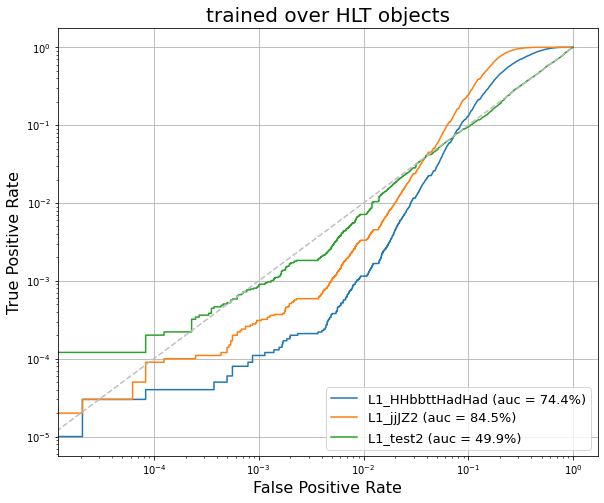

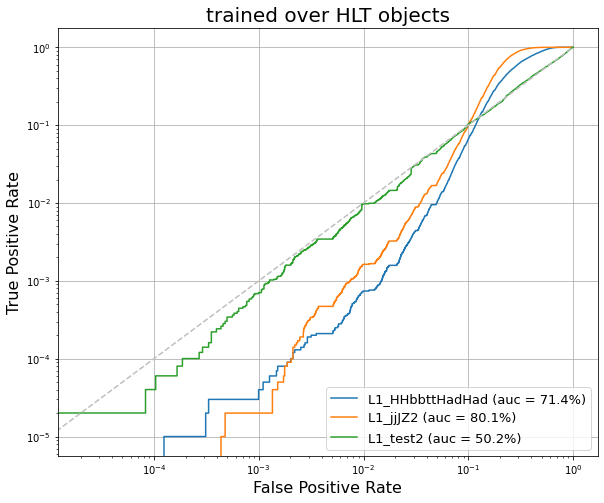


Starting batch 3!
starting batch 3 ensembling of HLT_ZZ4lep data!
starting batch 3 ensembling of HLT_HHbbttHadHad data!
starting batch 3 ensembling of HLT_jjJZ2 data!
starting batch 3 ensembling of HLT_test1 data!
starting batch 3 ensembling of HLT_test2 data!
starting batch 3 ensembling of L1_HHbbttHadHad data!
starting batch 3 ensembling of L1_jjJZ2 data!
starting batch 3 ensembling of L1_test1 data!
starting batch 3 ensembling of L1_test2 data!


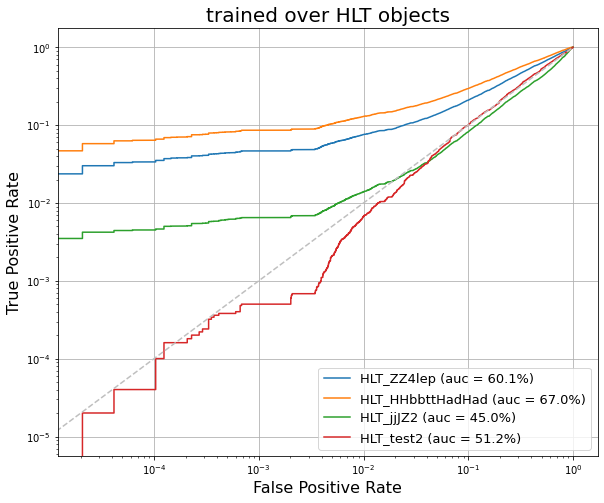

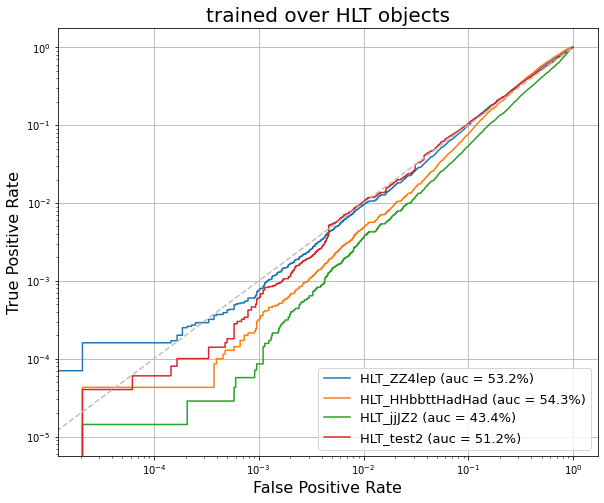

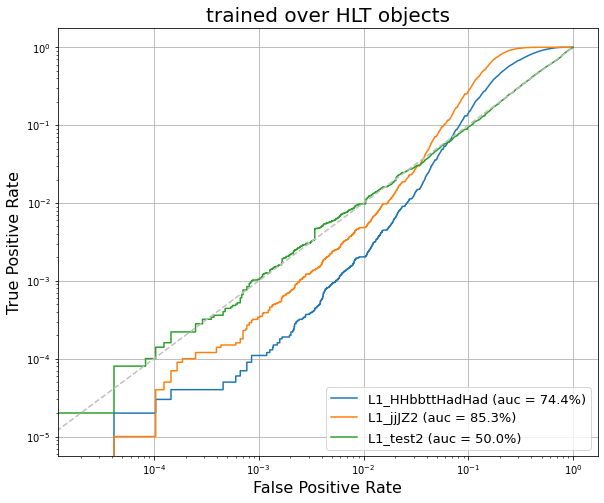

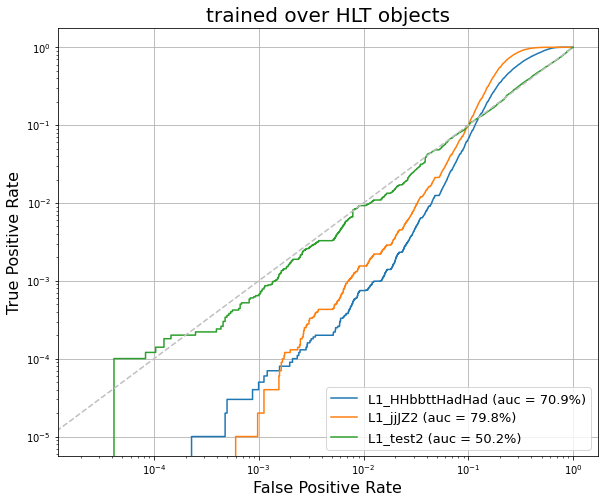


Starting batch 4!
starting batch 4 ensembling of HLT_ZZ4lep data!
starting batch 4 ensembling of HLT_HHbbttHadHad data!
starting batch 4 ensembling of HLT_jjJZ2 data!
starting batch 4 ensembling of HLT_test1 data!
starting batch 4 ensembling of HLT_test2 data!
starting batch 4 ensembling of L1_HHbbttHadHad data!
starting batch 4 ensembling of L1_jjJZ2 data!
starting batch 4 ensembling of L1_test1 data!
starting batch 4 ensembling of L1_test2 data!


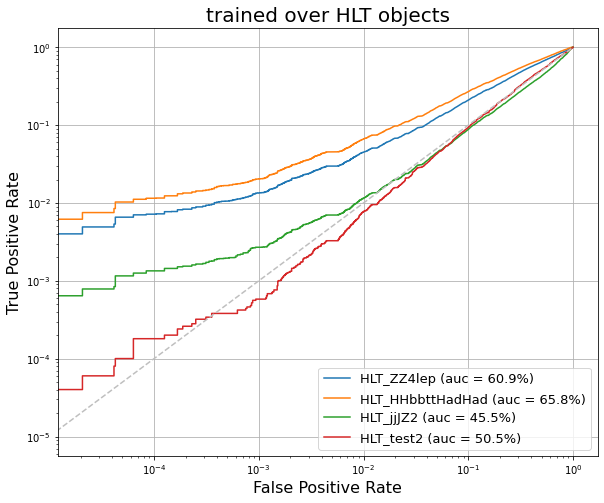

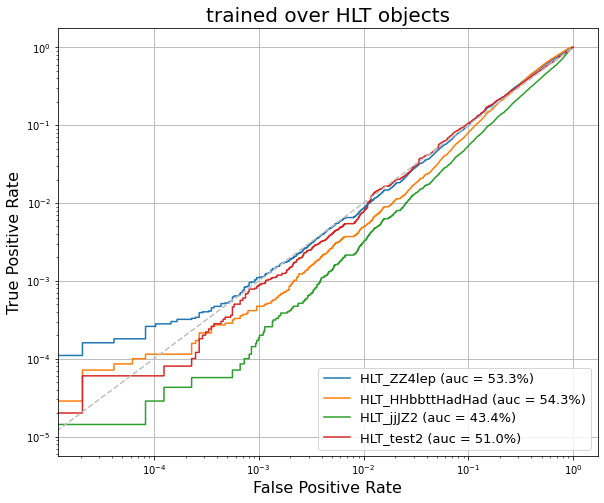

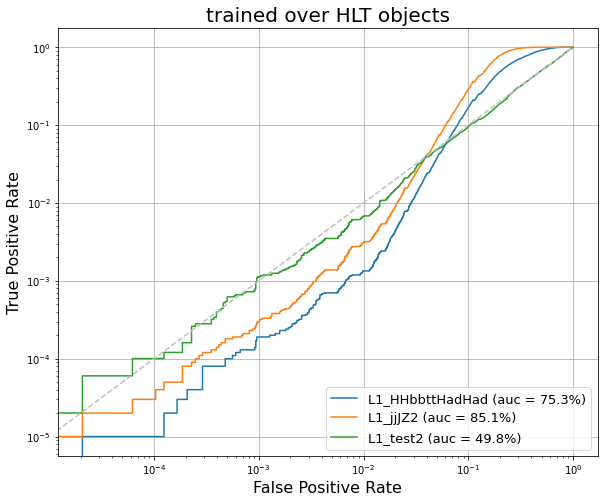

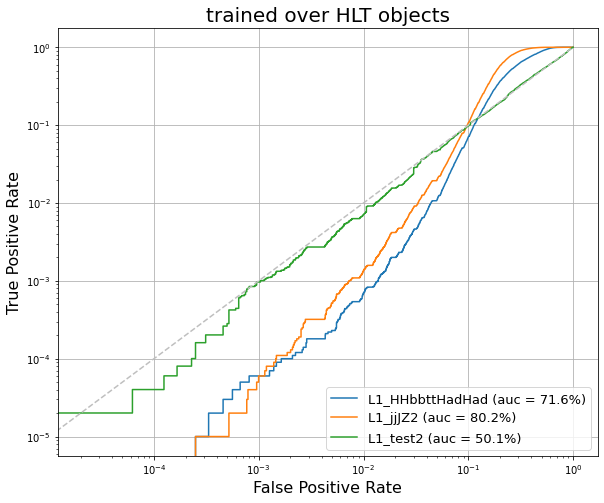


Starting batch 5!
starting batch 5 ensembling of HLT_ZZ4lep data!
starting batch 5 ensembling of HLT_HHbbttHadHad data!
starting batch 5 ensembling of HLT_jjJZ2 data!
starting batch 5 ensembling of HLT_test1 data!
starting batch 5 ensembling of HLT_test2 data!
starting batch 5 ensembling of L1_HHbbttHadHad data!
starting batch 5 ensembling of L1_jjJZ2 data!
starting batch 5 ensembling of L1_test1 data!
starting batch 5 ensembling of L1_test2 data!


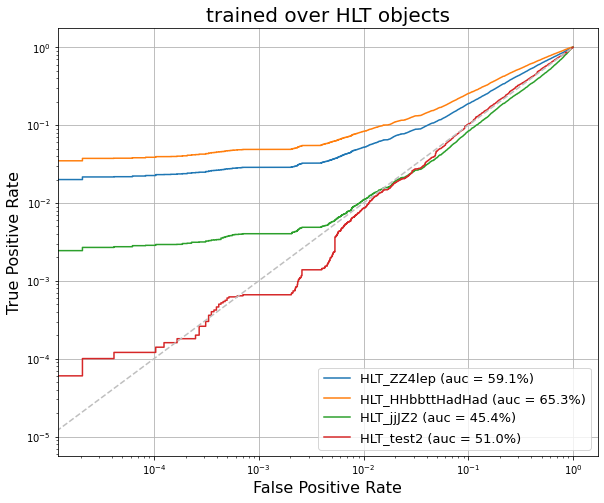

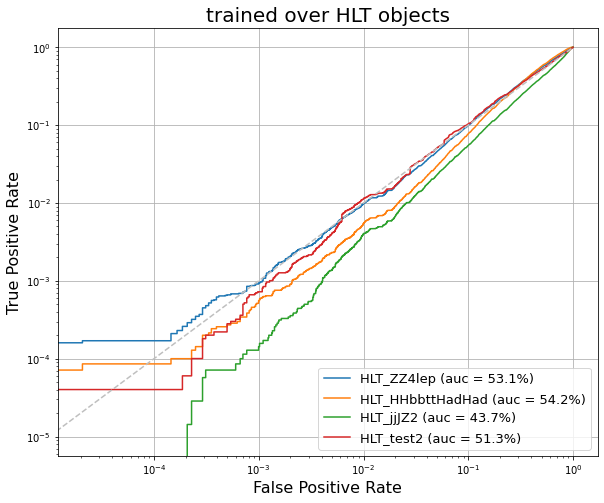

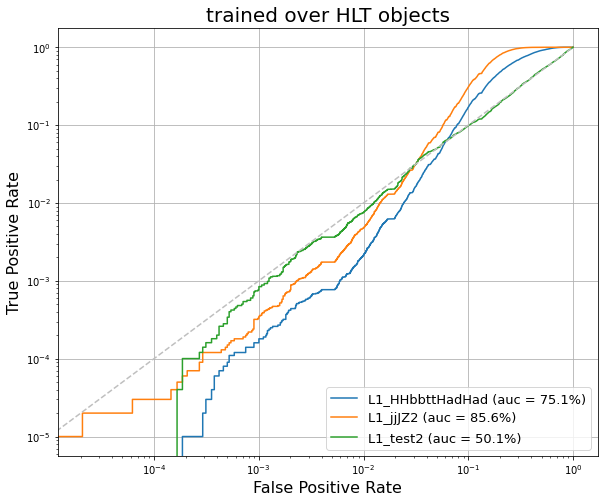

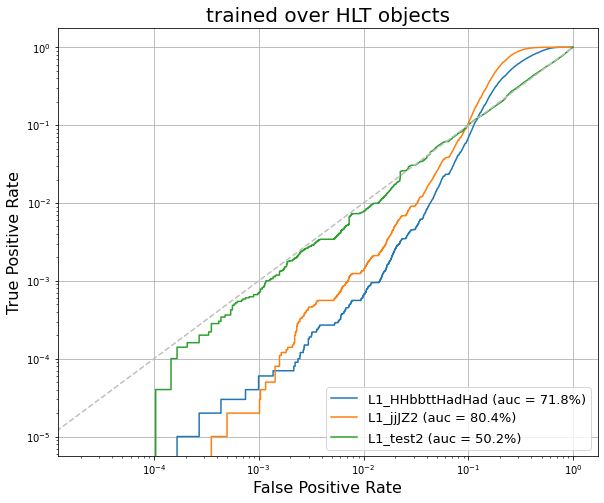


Starting batch 6!
starting batch 6 ensembling of HLT_ZZ4lep data!
starting batch 6 ensembling of HLT_HHbbttHadHad data!
starting batch 6 ensembling of HLT_jjJZ2 data!
starting batch 6 ensembling of HLT_test1 data!
starting batch 6 ensembling of HLT_test2 data!
starting batch 6 ensembling of L1_HHbbttHadHad data!
starting batch 6 ensembling of L1_jjJZ2 data!
starting batch 6 ensembling of L1_test1 data!
starting batch 6 ensembling of L1_test2 data!


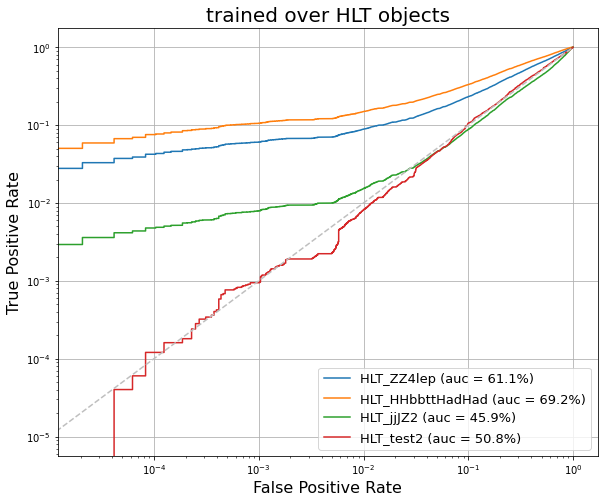

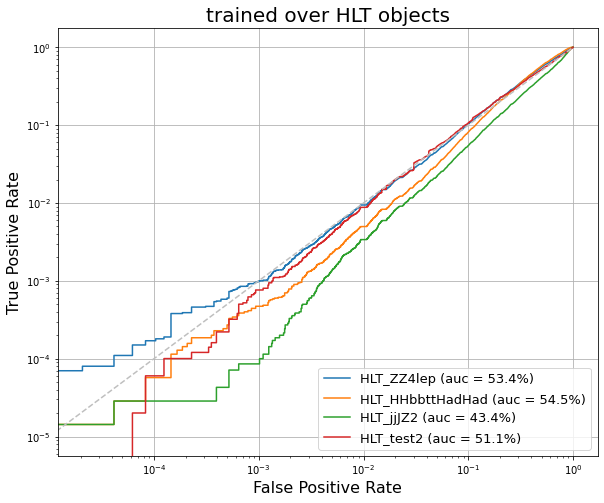

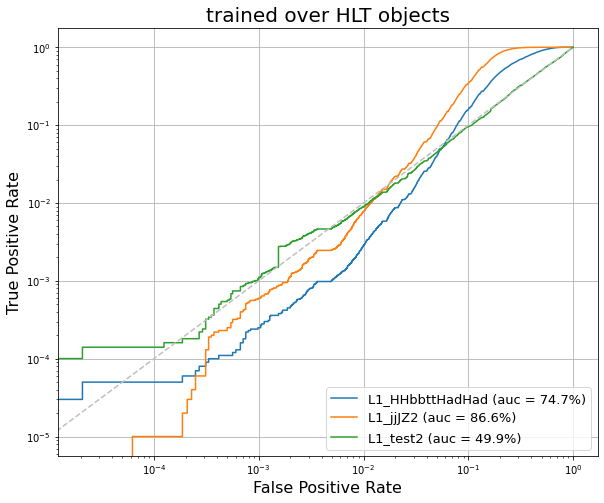

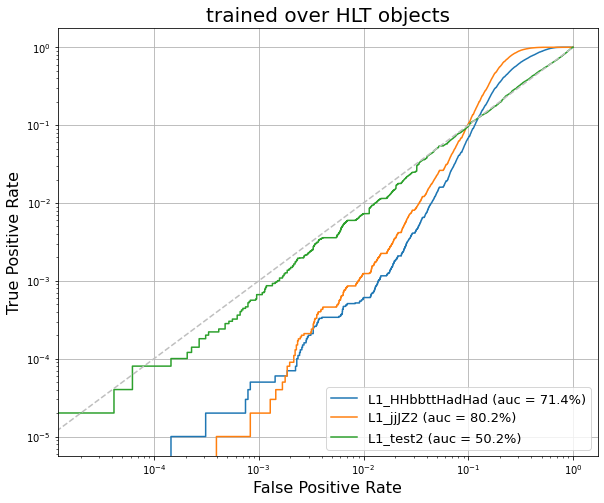

In [35]:
# Pass the data through all these models and collect results.
# There are 99 total models, I'm going to ensemble in batches of 14 models, with 7 total batches
# So we will have 7 ensembled results to compare and check stability.


skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets
good_tags = ['HLT_test1', 'HLT_test2', 'L1_test1', 'L1_test2', 'HLT_HHbbttHadHad', 'L1_HHbbttHadHad', 'HLT_ZZ4lep', 'HLT_jjJZ2', 'L1_jjJZ2'] # Evaluate over a smaller number of tags for now so this doesn't take 10 years
num_models_per_batch = 1

# Dictionaries to hold the results. The values of these dictionaries will hold 7 dictionaries, one for each batch
# They will map {modelType_batchNum : dictionary} e.g. {HLT_1 : TPR_dict}
batch_TPRs = {}
batch_TPRs_scaled = {}
batch_AUCs = {}
batch_AUCs_scaled = {}

for batch in range(7):
    print(f'Starting batch {batch}!')

    # Setup + load in models # --------------------------------------------------------------------------------
    avg_model_outputs = {}
    avg_scaled_model_outputs = {}
    avg_AD_scores = {}
    avg_scaled_AD_scores = {}

    start_num = batch*num_models_per_batch # the first model number that has not been tested already
    
    models = {
        'HLT': [load_model(f'./trained_models/ensemble_5-13-2024/HLT_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)],
        'L1': [load_model(f'./trained_models/ensemble_5-13-2024/L1_AE_{i}.keras') for i in range(start_num, start_num + num_models_per_batch)]
    }
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Pass the data through the models ------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        for tag, data in datasets.items():
            if tag.startswith(model_type) and tag in good_tags: # only pass HLT datasets through HLT model and vice versa
        
                print(f'starting batch {batch} ensembling of {tag} data!')
                avg_recon, avg_scaled_recon = ensemble_predictions(models[model_type], data)
                avg_model_outputs[tag] = avg_recon
                avg_scaled_model_outputs[tag] = avg_scaled_recon
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Calculate the AD scores ---------------------------------------------------------------------------------
    for tag, model_output in avg_model_outputs.items():
        avg_AD_scores[tag] = AD_score(datasets[tag], model_output)
    
    for tag, model_output in avg_scaled_model_outputs.items():
        avg_scaled_AD_scores[tag] = AD_score(datasets[tag], model_output)
    # ---------------------------------------------------------------------------------------------------------
    
    
    # Append results # ----------------------------------------------------------------------------------------
    for model_type in ['HLT', 'L1']:
        TPRs_avg, AUCs_avg = ROC_curve(avg_AD_scores, weights, bkg_tag=f'{model_type}_test1')
        batch_TPRs[f'{model_type}_{batch}'] = TPRs_avg
        batch_AUCs[f'{model_type}_{batch}'] = AUCs_avg
    
    
        TPRs_avg_scaled, AUCs_avg_scaled = ROC_curve(avg_scaled_AD_scores, weights, bkg_tag=f'{model_type}_test1')
        batch_TPRs_scaled[f'{model_type}_{batch}'] = TPRs_avg_scaled
        batch_AUCs_scaled[f'{model_type}_{batch}'] = AUCs_avg_scaled
    # ---------------------------------------------------------------------------------------------------------
    print('')